In [1]:
import cv2
import shutil
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import matplotlib.pyplot as plt

C:\Users\Tai Hoang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
tf.reset_default_graph()

In [3]:
FACES_DIR = '../data/HvN/faces_full'
FACES_DIR_TEST = '../data/face_croped'
FACES_DIR_PREDICTED = '../data/face_predicted'
FACES_DIR_PREDICTED_MALE = '../data/face_predicted/Male'
FACES_DIR_PREDICTED_FEMALE = '../data/face_predicted/Female'
IMG_SIZE = 100
LR = 1e-4
FRACTION = 8/10
MODEL_NAME = '../CNNModels/malevsfemale-{}-{}.model'.format(LR, '4-conv-basic')

In [4]:
def process_file(file_name):
    label = file_name[-5:][:1]
    if label == 'M':
        return [1,0]
    elif label == 'F':
        return [0,1]

In [5]:
img = process_file('1-06-M.jpg')
print(img)

[1, 0]


In [6]:
def process_folder(input_folder_path):
    data = []
    for img in tqdm(os.listdir(input_folder_path)):
        label = process_file(img)
        path = os.path.join(input_folder_path, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append([np.array(img), np.array(label)])
    shuffle(data)
    return data

In [7]:
data = process_folder(FACES_DIR)


100%|██████████████████████████████████████████████████████████████████████████████| 927/927 [00:00<00:00, 1805.41it/s]


In [29]:
#CNN

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='../data/tensorboard/log')

In [30]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [31]:
train = data[:int(len(data)*FRACTION)]
test = data[int(len(data)*FRACTION):]

In [32]:
def prepare_for_CNN(train, test):
    X=[]
    Y=[]
    test_x=[]
    test_y=[]
    for x in train:
        X.append(x[0])
        Y.append(x[1])
        
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)    
    
    for x in test:
        test_x.append(x[0])
        test_y.append(x[1])
    
    test_x = np.array(test_x).reshape(-1, IMG_SIZE, IMG_SIZE, 1)    
    
    return X, Y, test_x, test_y

In [33]:
X, Y, test_x, test_y = prepare_for_CNN(train, test)

In [34]:
print(np.array(X).shape)

(1413, 100, 100, 1)


In [35]:
model.fit(X_inputs=X, 
          Y_targets=Y, 
          n_epoch=100, 
          validation_set=({'input':test_x}, {'targets': test_y}), 
          snapshot_step=50000, 
          show_metric=True, run_id=MODEL_NAME)

Training Step: 2299  | total loss: 0.30640 | time: 8.062s
| Adam | epoch: 100 | loss: 0.30640 - acc: 0.9632 -- iter: 1408/1413
Training Step: 2300  | total loss: 0.27625 | time: 9.467s
| Adam | epoch: 100 | loss: 0.27625 - acc: 0.9669 | val_loss: 0.63622 - val_acc: 0.8418 -- iter: 1413/1413
--


In [36]:
def process_test_folder(input_folder_path):
    data = []
    for img in tqdm(os.listdir(input_folder_path)):
        img_name = img.split('.')[0]
        path = os.path.join(input_folder_path, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append([np.array(img), img_name])
    shuffle(data)
    return data

In [37]:
predict_data = process_test_folder(FACES_DIR_TEST)


100%|████████████████████████████████████████████████████████████████████████████| 2411/2411 [00:00<00:00, 5731.76it/s]


40it [00:00, 66.65it/s]


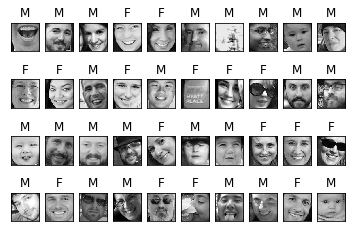

In [38]:
fig = plt.figure()
for num,data in tqdm(enumerate(predict_data[:40])):
#     [1,0]: M
#     [0,1]: F 
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,10, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]

    if np.argmax(model_out) == 1:
        str_label = 'F'
    else:
        str_label = 'M'
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [20]:
def save_predicted_files(predict_data, input_folder_path, output_male_folder_path, output_female_folder_path, output_folder_path):
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    if not os.path.exists(output_male_folder_path):
        os.makedirs(output_male_folder_path)
    if not os.path.exists(output_female_folder_path):
        os.makedirs(output_female_folder_path)
        
    for num,data in tqdm(enumerate(predict_data[:])):
        img_num = data[1]
        img_data = data[0]
       
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]

        if np.argmax(model_out) == 1:
            str_label = 'F'
        else:
            str_label = 'M'
    
        img_file = img_num+'.jpg'
        new_image_file = img_num + '_' + str_label + '.jpg'         
        print('copy from {0} to {1}'.format(os.path.join(input_folder_path,img_file), os.path.join(output_folder_path, new_image_file)))
        shutil.copy2(os.path.join(input_folder_path,img_file), os.path.join(output_folder_path, new_image_file))
        
        if str_label == 'F':
            shutil.copy2(os.path.join(input_folder_path,img_file), os.path.join(output_female_folder_path, new_image_file))
        elif str_label == 'M':
            shutil.copy2(os.path.join(input_folder_path,img_file), os.path.join(output_male_folder_path, new_image_file))

In [21]:
save_predicted_files(predict_data, FACES_DIR_TEST, FACES_DIR_PREDICTED_MALE, FACES_DIR_PREDICTED_FEMALE, FACES_DIR_PREDICTED)

0it [00:00, ?it/s]

copy from ../data/face_croped\3744.jpg to ../data/face_predicted\3744_F.jpg
copy from ../data/face_croped\22903.jpg to ../data/face_predicted\22903_F.jpg
copy from ../data/face_croped\12095.jpg to ../data/face_predicted\12095_M.jpg
copy from ../data/face_croped\7598.jpg to ../data/face_predicted\7598_F.jpg
copy from ../data/face_croped\10335.jpg to ../data/face_predicted\10335_F.jpg
copy from ../data/face_croped\11158.jpg to ../data/face_predicted\11158_M.jpg
copy from ../data/face_croped\16442.jpg to ../data/face_predicted\16442_M.jpg
copy from ../data/face_croped\5630.jpg to ../data/face_predicted\5630_M.jpg
copy from ../data/face_croped\31114.jpg to ../data/face_predicted\31114_M.jpg
copy from ../data/face_croped\20088.jpg to ../data/face_predicted\20088_M.jpg
copy from ../data/face_croped\13105.jpg to ../data/face_predicted\13105_M.jpg


11it [00:00, 109.22it/s]

copy from ../data/face_croped\12951.jpg to ../data/face_predicted\12951_M.jpg
copy from ../data/face_croped\9283.jpg to ../data/face_predicted\9283_M.jpg
copy from ../data/face_croped\5479.jpg to ../data/face_predicted\5479_F.jpg
copy from ../data/face_croped\8374.jpg to ../data/face_predicted\8374_M.jpg
copy from ../data/face_croped\14031.jpg to ../data/face_predicted\14031_M.jpg
copy from ../data/face_croped\30531.jpg to ../data/face_predicted\30531_F.jpg
copy from ../data/face_croped\7437.jpg to ../data/face_predicted\7437_F.jpg
copy from ../data/face_croped\12828.jpg to ../data/face_predicted\12828_M.jpg
copy from ../data/face_croped\21109.jpg to ../data/face_predicted\21109_F.jpg
copy from ../data/face_croped\6193.jpg to ../data/face_predicted\6193_M.jpg
copy from ../data/face_croped\21210.jpg to ../data/face_predicted\21210_F.jpg


22it [00:00, 106.24it/s]

copy from ../data/face_croped\27132.jpg to ../data/face_predicted\27132_M.jpg
copy from ../data/face_croped\15566.jpg to ../data/face_predicted\15566_F.jpg
copy from ../data/face_croped\30107.jpg to ../data/face_predicted\30107_F.jpg
copy from ../data/face_croped\25296.jpg to ../data/face_predicted\25296_F.jpg
copy from ../data/face_croped\31136.jpg to ../data/face_predicted\31136_F.jpg
copy from ../data/face_croped\14739.jpg to ../data/face_predicted\14739_M.jpg
copy from ../data/face_croped\24741.jpg to ../data/face_predicted\24741_M.jpg
copy from ../data/face_croped\5941.jpg to ../data/face_predicted\5941_F.jpg
copy from ../data/face_croped\13706.jpg to ../data/face_predicted\13706_F.jpg
copy from ../data/face_croped\3295.jpg to ../data/face_predicted\3295_M.jpg
copy from ../data/face_croped\9510.jpg to ../data/face_predicted\9510_M.jpg
copy from ../data/face_croped\5194.jpg to ../data/face_predicted\5194_M.jpg


34it [00:00, 107.63it/s]

copy from ../data/face_croped\3698.jpg to ../data/face_predicted\3698_F.jpg
copy from ../data/face_croped\28283.jpg to ../data/face_predicted\28283_F.jpg
copy from ../data/face_croped\12864.jpg to ../data/face_predicted\12864_M.jpg
copy from ../data/face_croped\4572.jpg to ../data/face_predicted\4572_F.jpg
copy from ../data/face_croped\3156.jpg to ../data/face_predicted\3156_F.jpg
copy from ../data/face_croped\13518.jpg to ../data/face_predicted\13518_F.jpg
copy from ../data/face_croped\4573.jpg to ../data/face_predicted\4573_F.jpg
copy from ../data/face_croped\22780.jpg to ../data/face_predicted\22780_M.jpg
copy from ../data/face_croped\31419.jpg to ../data/face_predicted\31419_F.jpg
copy from ../data/face_croped\5636.jpg to ../data/face_predicted\5636_F.jpg
copy from ../data/face_croped\9461.jpg to ../data/face_predicted\9461_F.jpg


45it [00:00, 107.94it/s]

copy from ../data/face_croped\26333.jpg to ../data/face_predicted\26333_M.jpg
copy from ../data/face_croped\6243.jpg to ../data/face_predicted\6243_F.jpg
copy from ../data/face_croped\4404.jpg to ../data/face_predicted\4404_M.jpg
copy from ../data/face_croped\22257.jpg to ../data/face_predicted\22257_M.jpg
copy from ../data/face_croped\12011.jpg to ../data/face_predicted\12011_F.jpg
copy from ../data/face_croped\15451.jpg to ../data/face_predicted\15451_F.jpg
copy from ../data/face_croped\24416.jpg to ../data/face_predicted\24416_M.jpg
copy from ../data/face_croped\27828.jpg to ../data/face_predicted\27828_F.jpg
copy from ../data/face_croped\15029.jpg to ../data/face_predicted\15029_M.jpg
copy from ../data/face_croped\16254.jpg to ../data/face_predicted\16254_F.jpg
copy from ../data/face_croped\30625.jpg to ../data/face_predicted\30625_M.jpg


56it [00:00, 105.11it/s]

copy from ../data/face_croped\12048.jpg to ../data/face_predicted\12048_M.jpg
copy from ../data/face_croped\13505.jpg to ../data/face_predicted\13505_M.jpg
copy from ../data/face_croped\3869.jpg to ../data/face_predicted\3869_M.jpg
copy from ../data/face_croped\25020.jpg to ../data/face_predicted\25020_M.jpg
copy from ../data/face_croped\6014.jpg to ../data/face_predicted\6014_F.jpg
copy from ../data/face_croped\31499.jpg to ../data/face_predicted\31499_M.jpg
copy from ../data/face_croped\5622.jpg to ../data/face_predicted\5622_F.jpg
copy from ../data/face_croped\28095.jpg to ../data/face_predicted\28095_F.jpg
copy from ../data/face_croped\3710.jpg to ../data/face_predicted\3710_F.jpg
copy from ../data/face_croped\5417.jpg to ../data/face_predicted\5417_M.jpg
copy from ../data/face_croped\16446.jpg to ../data/face_predicted\16446_F.jpg


67it [00:00, 103.92it/s]

copy from ../data/face_croped\12037.jpg to ../data/face_predicted\12037_F.jpg
copy from ../data/face_croped\19300.jpg to ../data/face_predicted\19300_M.jpg
copy from ../data/face_croped\20407.jpg to ../data/face_predicted\20407_M.jpg
copy from ../data/face_croped\29730.jpg to ../data/face_predicted\29730_F.jpg
copy from ../data/face_croped\31258.jpg to ../data/face_predicted\31258_M.jpg
copy from ../data/face_croped\10084.jpg to ../data/face_predicted\10084_M.jpg
copy from ../data/face_croped\10398.jpg to ../data/face_predicted\10398_F.jpg
copy from ../data/face_croped\4213.jpg to ../data/face_predicted\4213_F.jpg
copy from ../data/face_croped\29401.jpg to ../data/face_predicted\29401_M.jpg
copy from ../data/face_croped\30415.jpg to ../data/face_predicted\30415_M.jpg
copy from ../data/face_croped\3065.jpg to ../data/face_predicted\3065_M.jpg


78it [00:00, 104.41it/s]

copy from ../data/face_croped\13213.jpg to ../data/face_predicted\13213_M.jpg
copy from ../data/face_croped\11058.jpg to ../data/face_predicted\11058_M.jpg
copy from ../data/face_croped\31292.jpg to ../data/face_predicted\31292_F.jpg
copy from ../data/face_croped\16074.jpg to ../data/face_predicted\16074_M.jpg
copy from ../data/face_croped\11759.jpg to ../data/face_predicted\11759_F.jpg
copy from ../data/face_croped\21405.jpg to ../data/face_predicted\21405_M.jpg
copy from ../data/face_croped\16882.jpg to ../data/face_predicted\16882_M.jpg
copy from ../data/face_croped\9508.jpg to ../data/face_predicted\9508_F.jpg
copy from ../data/face_croped\22146.jpg to ../data/face_predicted\22146_M.jpg
copy from ../data/face_croped\12559.jpg to ../data/face_predicted\12559_M.jpg
copy from ../data/face_croped\29484.jpg to ../data/face_predicted\29484_M.jpg


89it [00:00, 105.88it/s]

copy from ../data/face_croped\11446.jpg to ../data/face_predicted\11446_M.jpg
copy from ../data/face_croped\19213.jpg to ../data/face_predicted\19213_M.jpg
copy from ../data/face_croped\3985.jpg to ../data/face_predicted\3985_M.jpg
copy from ../data/face_croped\30806.jpg to ../data/face_predicted\30806_M.jpg
copy from ../data/face_croped\16253.jpg to ../data/face_predicted\16253_F.jpg
copy from ../data/face_croped\21900.jpg to ../data/face_predicted\21900_M.jpg
copy from ../data/face_croped\20250.jpg to ../data/face_predicted\20250_M.jpg
copy from ../data/face_croped\28738.jpg to ../data/face_predicted\28738_M.jpg
copy from ../data/face_croped\19596.jpg to ../data/face_predicted\19596_F.jpg
copy from ../data/face_croped\20522.jpg to ../data/face_predicted\20522_M.jpg
copy from ../data/face_croped\3237.jpg to ../data/face_predicted\3237_F.jpg
copy from ../data/face_croped\4852.jpg to ../data/face_predicted\4852_M.jpg


101it [00:00, 109.40it/s]

copy from ../data/face_croped\30258.jpg to ../data/face_predicted\30258_M.jpg
copy from ../data/face_croped\18616.jpg to ../data/face_predicted\18616_M.jpg
copy from ../data/face_croped\3324.jpg to ../data/face_predicted\3324_F.jpg
copy from ../data/face_croped\7167.jpg to ../data/face_predicted\7167_F.jpg
copy from ../data/face_croped\26915.jpg to ../data/face_predicted\26915_M.jpg
copy from ../data/face_croped\16037.jpg to ../data/face_predicted\16037_M.jpg
copy from ../data/face_croped\6594.jpg to ../data/face_predicted\6594_M.jpg
copy from ../data/face_croped\13077.jpg to ../data/face_predicted\13077_F.jpg
copy from ../data/face_croped\15982.jpg to ../data/face_predicted\15982_F.jpg
copy from ../data/face_croped\20886.jpg to ../data/face_predicted\20886_F.jpg
copy from ../data/face_croped\30820.jpg to ../data/face_predicted\30820_M.jpg
copy from ../data/face_croped\31476.jpg to ../data/face_predicted\31476_M.jpg


113it [00:01, 110.29it/s]

copy from ../data/face_croped\25247.jpg to ../data/face_predicted\25247_F.jpg
copy from ../data/face_croped\9409.jpg to ../data/face_predicted\9409_M.jpg
copy from ../data/face_croped\14106.jpg to ../data/face_predicted\14106_F.jpg
copy from ../data/face_croped\28268.jpg to ../data/face_predicted\28268_M.jpg
copy from ../data/face_croped\20090.jpg to ../data/face_predicted\20090_M.jpg
copy from ../data/face_croped\4531.jpg to ../data/face_predicted\4531_M.jpg
copy from ../data/face_croped\25469.jpg to ../data/face_predicted\25469_M.jpg
copy from ../data/face_croped\4557.jpg to ../data/face_predicted\4557_M.jpg
copy from ../data/face_croped\6514.jpg to ../data/face_predicted\6514_F.jpg
copy from ../data/face_croped\4863.jpg to ../data/face_predicted\4863_F.jpg
copy from ../data/face_croped\25734.jpg to ../data/face_predicted\25734_F.jpg


124it [00:01, 106.79it/s]

copy from ../data/face_croped\30442.jpg to ../data/face_predicted\30442_M.jpg
copy from ../data/face_croped\17121.jpg to ../data/face_predicted\17121_F.jpg
copy from ../data/face_croped\6985.jpg to ../data/face_predicted\6985_M.jpg
copy from ../data/face_croped\9272.jpg to ../data/face_predicted\9272_M.jpg
copy from ../data/face_croped\22927.jpg to ../data/face_predicted\22927_F.jpg
copy from ../data/face_croped\5818.jpg to ../data/face_predicted\5818_M.jpg
copy from ../data/face_croped\25582.jpg to ../data/face_predicted\25582_F.jpg
copy from ../data/face_croped\19715.jpg to ../data/face_predicted\19715_M.jpg
copy from ../data/face_croped\7974.jpg to ../data/face_predicted\7974_F.jpg
copy from ../data/face_croped\11106.jpg to ../data/face_predicted\11106_F.jpg
copy from ../data/face_croped\26113.jpg to ../data/face_predicted\26113_M.jpg
copy from ../data/face_croped\27939.jpg to ../data/face_predicted\27939_M.jpg
copy from ../data/face_croped\3643.jpg to ../data/face_predicted\3643_M.

137it [00:01, 110.92it/s]

copy from ../data/face_croped\12014.jpg to ../data/face_predicted\12014_M.jpg
copy from ../data/face_croped\12794.jpg to ../data/face_predicted\12794_F.jpg
copy from ../data/face_croped\20335.jpg to ../data/face_predicted\20335_F.jpg
copy from ../data/face_croped\25086.jpg to ../data/face_predicted\25086_M.jpg
copy from ../data/face_croped\29824.jpg to ../data/face_predicted\29824_F.jpg
copy from ../data/face_croped\5462.jpg to ../data/face_predicted\5462_M.jpg
copy from ../data/face_croped\8427.jpg to ../data/face_predicted\8427_M.jpg
copy from ../data/face_croped\20247.jpg to ../data/face_predicted\20247_M.jpg
copy from ../data/face_croped\14349.jpg to ../data/face_predicted\14349_F.jpg
copy from ../data/face_croped\5913.jpg to ../data/face_predicted\5913_M.jpg
copy from ../data/face_croped\24872.jpg to ../data/face_predicted\24872_F.jpg
copy from ../data/face_croped\11609.jpg to ../data/face_predicted\11609_F.jpg


149it [00:01, 112.33it/s]

copy from ../data/face_croped\15293.jpg to ../data/face_predicted\15293_F.jpg
copy from ../data/face_croped\13783.jpg to ../data/face_predicted\13783_M.jpg
copy from ../data/face_croped\6425.jpg to ../data/face_predicted\6425_M.jpg
copy from ../data/face_croped\7897.jpg to ../data/face_predicted\7897_F.jpg
copy from ../data/face_croped\18430.jpg to ../data/face_predicted\18430_M.jpg
copy from ../data/face_croped\6953.jpg to ../data/face_predicted\6953_F.jpg
copy from ../data/face_croped\16188.jpg to ../data/face_predicted\16188_M.jpg
copy from ../data/face_croped\15368.jpg to ../data/face_predicted\15368_M.jpg
copy from ../data/face_croped\3484.jpg to ../data/face_predicted\3484_M.jpg
copy from ../data/face_croped\21122.jpg to ../data/face_predicted\21122_M.jpg
copy from ../data/face_croped\11608.jpg to ../data/face_predicted\11608_F.jpg
copy from ../data/face_croped\13504.jpg to ../data/face_predicted\13504_F.jpg


161it [00:01, 112.38it/s]

copy from ../data/face_croped\21145.jpg to ../data/face_predicted\21145_M.jpg
copy from ../data/face_croped\20266.jpg to ../data/face_predicted\20266_F.jpg
copy from ../data/face_croped\13071.jpg to ../data/face_predicted\13071_F.jpg
copy from ../data/face_croped\29230.jpg to ../data/face_predicted\29230_M.jpg
copy from ../data/face_croped\7583.jpg to ../data/face_predicted\7583_M.jpg
copy from ../data/face_croped\4279.jpg to ../data/face_predicted\4279_M.jpg
copy from ../data/face_croped\6369.jpg to ../data/face_predicted\6369_F.jpg
copy from ../data/face_croped\12430.jpg to ../data/face_predicted\12430_M.jpg
copy from ../data/face_croped\3318.jpg to ../data/face_predicted\3318_M.jpg
copy from ../data/face_croped\21961.jpg to ../data/face_predicted\21961_F.jpg
copy from ../data/face_croped\30483.jpg to ../data/face_predicted\30483_F.jpg
copy from ../data/face_croped\23870.jpg to ../data/face_predicted\23870_F.jpg


173it [00:01, 111.66it/s]

copy from ../data/face_croped\27942.jpg to ../data/face_predicted\27942_M.jpg
copy from ../data/face_croped\3208.jpg to ../data/face_predicted\3208_M.jpg
copy from ../data/face_croped\3068.jpg to ../data/face_predicted\3068_F.jpg
copy from ../data/face_croped\20408.jpg to ../data/face_predicted\20408_F.jpg
copy from ../data/face_croped\14132.jpg to ../data/face_predicted\14132_F.jpg
copy from ../data/face_croped\28282.jpg to ../data/face_predicted\28282_M.jpg
copy from ../data/face_croped\7822.jpg to ../data/face_predicted\7822_M.jpg
copy from ../data/face_croped\30180.jpg to ../data/face_predicted\30180_F.jpg
copy from ../data/face_croped\4014.jpg to ../data/face_predicted\4014_F.jpg
copy from ../data/face_croped\17343.jpg to ../data/face_predicted\17343_F.jpg
copy from ../data/face_croped\12722.jpg to ../data/face_predicted\12722_F.jpg
copy from ../data/face_croped\28988.jpg to ../data/face_predicted\28988_F.jpg


185it [00:01, 111.29it/s]

copy from ../data/face_croped\6980.jpg to ../data/face_predicted\6980_M.jpg
copy from ../data/face_croped\5229.jpg to ../data/face_predicted\5229_M.jpg
copy from ../data/face_croped\20338.jpg to ../data/face_predicted\20338_F.jpg
copy from ../data/face_croped\14408.jpg to ../data/face_predicted\14408_F.jpg
copy from ../data/face_croped\16176.jpg to ../data/face_predicted\16176_F.jpg
copy from ../data/face_croped\4542.jpg to ../data/face_predicted\4542_M.jpg
copy from ../data/face_croped\6652.jpg to ../data/face_predicted\6652_F.jpg
copy from ../data/face_croped\31190.jpg to ../data/face_predicted\31190_M.jpg
copy from ../data/face_croped\7371.jpg to ../data/face_predicted\7371_M.jpg
copy from ../data/face_croped\19508.jpg to ../data/face_predicted\19508_M.jpg
copy from ../data/face_croped\4446.jpg to ../data/face_predicted\4446_M.jpg
copy from ../data/face_croped\8372.jpg to ../data/face_predicted\8372_M.jpg


197it [00:01, 113.39it/s]

copy from ../data/face_croped\5146.jpg to ../data/face_predicted\5146_M.jpg
copy from ../data/face_croped\16252.jpg to ../data/face_predicted\16252_F.jpg
copy from ../data/face_croped\22038.jpg to ../data/face_predicted\22038_F.jpg
copy from ../data/face_croped\29593.jpg to ../data/face_predicted\29593_M.jpg
copy from ../data/face_croped\21490.jpg to ../data/face_predicted\21490_F.jpg
copy from ../data/face_croped\8192.jpg to ../data/face_predicted\8192_F.jpg
copy from ../data/face_croped\12845.jpg to ../data/face_predicted\12845_F.jpg
copy from ../data/face_croped\18442.jpg to ../data/face_predicted\18442_M.jpg
copy from ../data/face_croped\4459.jpg to ../data/face_predicted\4459_M.jpg
copy from ../data/face_croped\20336.jpg to ../data/face_predicted\20336_F.jpg
copy from ../data/face_croped\5134.jpg to ../data/face_predicted\5134_F.jpg
copy from ../data/face_croped\8061.jpg to ../data/face_predicted\8061_F.jpg


209it [00:01, 114.25it/s]

copy from ../data/face_croped\10128.jpg to ../data/face_predicted\10128_F.jpg
copy from ../data/face_croped\4750.jpg to ../data/face_predicted\4750_M.jpg
copy from ../data/face_croped\25090.jpg to ../data/face_predicted\25090_F.jpg
copy from ../data/face_croped\13431.jpg to ../data/face_predicted\13431_M.jpg
copy from ../data/face_croped\8377.jpg to ../data/face_predicted\8377_M.jpg
copy from ../data/face_croped\12850.jpg to ../data/face_predicted\12850_M.jpg
copy from ../data/face_croped\29044.jpg to ../data/face_predicted\29044_M.jpg
copy from ../data/face_croped\15707.jpg to ../data/face_predicted\15707_F.jpg
copy from ../data/face_croped\8656.jpg to ../data/face_predicted\8656_M.jpg
copy from ../data/face_croped\3893.jpg to ../data/face_predicted\3893_M.jpg
copy from ../data/face_croped\4419.jpg to ../data/face_predicted\4419_M.jpg
copy from ../data/face_croped\11131.jpg to ../data/face_predicted\11131_F.jpg


221it [00:02, 115.03it/s]

copy from ../data/face_croped\29487.jpg to ../data/face_predicted\29487_M.jpg
copy from ../data/face_croped\20437.jpg to ../data/face_predicted\20437_F.jpg
copy from ../data/face_croped\4137.jpg to ../data/face_predicted\4137_F.jpg
copy from ../data/face_croped\20492.jpg to ../data/face_predicted\20492_F.jpg
copy from ../data/face_croped\4623.jpg to ../data/face_predicted\4623_F.jpg
copy from ../data/face_croped\25966.jpg to ../data/face_predicted\25966_M.jpg
copy from ../data/face_croped\15347.jpg to ../data/face_predicted\15347_F.jpg
copy from ../data/face_croped\13284.jpg to ../data/face_predicted\13284_F.jpg
copy from ../data/face_croped\3426.jpg to ../data/face_predicted\3426_M.jpg
copy from ../data/face_croped\3989.jpg to ../data/face_predicted\3989_M.jpg
copy from ../data/face_croped\6544.jpg to ../data/face_predicted\6544_F.jpg
copy from ../data/face_croped\7847.jpg to ../data/face_predicted\7847_M.jpg


233it [00:02, 115.92it/s]

copy from ../data/face_croped\27781.jpg to ../data/face_predicted\27781_M.jpg
copy from ../data/face_croped\6516.jpg to ../data/face_predicted\6516_M.jpg
copy from ../data/face_croped\4743.jpg to ../data/face_predicted\4743_F.jpg
copy from ../data/face_croped\15694.jpg to ../data/face_predicted\15694_F.jpg
copy from ../data/face_croped\14094.jpg to ../data/face_predicted\14094_F.jpg
copy from ../data/face_croped\5624.jpg to ../data/face_predicted\5624_M.jpg
copy from ../data/face_croped\31295.jpg to ../data/face_predicted\31295_M.jpg
copy from ../data/face_croped\21774.jpg to ../data/face_predicted\21774_M.jpg
copy from ../data/face_croped\31367.jpg to ../data/face_predicted\31367_M.jpg
copy from ../data/face_croped\6996.jpg to ../data/face_predicted\6996_F.jpg
copy from ../data/face_croped\23443.jpg to ../data/face_predicted\23443_F.jpg
copy from ../data/face_croped\4660.jpg to ../data/face_predicted\4660_M.jpg


245it [00:02, 115.37it/s]

copy from ../data/face_croped\13136.jpg to ../data/face_predicted\13136_M.jpg
copy from ../data/face_croped\3645.jpg to ../data/face_predicted\3645_M.jpg
copy from ../data/face_croped\15751.jpg to ../data/face_predicted\15751_F.jpg
copy from ../data/face_croped\14964.jpg to ../data/face_predicted\14964_M.jpg
copy from ../data/face_croped\20359.jpg to ../data/face_predicted\20359_F.jpg
copy from ../data/face_croped\29698.jpg to ../data/face_predicted\29698_F.jpg
copy from ../data/face_croped\27940.jpg to ../data/face_predicted\27940_F.jpg
copy from ../data/face_croped\20978.jpg to ../data/face_predicted\20978_F.jpg
copy from ../data/face_croped\20449.jpg to ../data/face_predicted\20449_M.jpg
copy from ../data/face_croped\20204.jpg to ../data/face_predicted\20204_M.jpg
copy from ../data/face_croped\3315.jpg to ../data/face_predicted\3315_M.jpg
copy from ../data/face_croped\11404.jpg to ../data/face_predicted\11404_F.jpg


257it [00:02, 114.50it/s]

copy from ../data/face_croped\7436.jpg to ../data/face_predicted\7436_M.jpg
copy from ../data/face_croped\5633.jpg to ../data/face_predicted\5633_M.jpg
copy from ../data/face_croped\5157.jpg to ../data/face_predicted\5157_M.jpg
copy from ../data/face_croped\29957.jpg to ../data/face_predicted\29957_M.jpg
copy from ../data/face_croped\20964.jpg to ../data/face_predicted\20964_F.jpg
copy from ../data/face_croped\10065.jpg to ../data/face_predicted\10065_M.jpg
copy from ../data/face_croped\7895.jpg to ../data/face_predicted\7895_F.jpg
copy from ../data/face_croped\4420.jpg to ../data/face_predicted\4420_F.jpg
copy from ../data/face_croped\24965.jpg to ../data/face_predicted\24965_F.jpg
copy from ../data/face_croped\9144.jpg to ../data/face_predicted\9144_F.jpg
copy from ../data/face_croped\10276.jpg to ../data/face_predicted\10276_F.jpg
copy from ../data/face_croped\8401.jpg to ../data/face_predicted\8401_M.jpg


269it [00:02, 109.86it/s]

copy from ../data/face_croped\3369.jpg to ../data/face_predicted\3369_F.jpg
copy from ../data/face_croped\29791.jpg to ../data/face_predicted\29791_M.jpg
copy from ../data/face_croped\23486.jpg to ../data/face_predicted\23486_F.jpg
copy from ../data/face_croped\30403.jpg to ../data/face_predicted\30403_M.jpg
copy from ../data/face_croped\4510.jpg to ../data/face_predicted\4510_F.jpg
copy from ../data/face_croped\29757.jpg to ../data/face_predicted\29757_M.jpg
copy from ../data/face_croped\5341.jpg to ../data/face_predicted\5341_M.jpg
copy from ../data/face_croped\5582.jpg to ../data/face_predicted\5582_F.jpg
copy from ../data/face_croped\13831.jpg to ../data/face_predicted\13831_M.jpg
copy from ../data/face_croped\3374.jpg to ../data/face_predicted\3374_M.jpg
copy from ../data/face_croped\3301.jpg to ../data/face_predicted\3301_M.jpg
copy from ../data/face_croped\28106.jpg to ../data/face_predicted\28106_M.jpg


281it [00:02, 106.14it/s]

copy from ../data/face_croped\16073.jpg to ../data/face_predicted\16073_M.jpg
copy from ../data/face_croped\4626.jpg to ../data/face_predicted\4626_M.jpg
copy from ../data/face_croped\16652.jpg to ../data/face_predicted\16652_M.jpg
copy from ../data/face_croped\10168.jpg to ../data/face_predicted\10168_M.jpg
copy from ../data/face_croped\21487.jpg to ../data/face_predicted\21487_F.jpg
copy from ../data/face_croped\14509.jpg to ../data/face_predicted\14509_M.jpg
copy from ../data/face_croped\23756.jpg to ../data/face_predicted\23756_F.jpg
copy from ../data/face_croped\8375.jpg to ../data/face_predicted\8375_F.jpg
copy from ../data/face_croped\12720.jpg to ../data/face_predicted\12720_F.jpg
copy from ../data/face_croped\6427.jpg to ../data/face_predicted\6427_M.jpg
copy from ../data/face_croped\26745.jpg to ../data/face_predicted\26745_M.jpg


292it [00:02, 104.63it/s]

copy from ../data/face_croped\31135.jpg to ../data/face_predicted\31135_M.jpg
copy from ../data/face_croped\10422.jpg to ../data/face_predicted\10422_M.jpg
copy from ../data/face_croped\12823.jpg to ../data/face_predicted\12823_F.jpg
copy from ../data/face_croped\24861.jpg to ../data/face_predicted\24861_M.jpg
copy from ../data/face_croped\18852.jpg to ../data/face_predicted\18852_M.jpg
copy from ../data/face_croped\5218.jpg to ../data/face_predicted\5218_F.jpg
copy from ../data/face_croped\31464.jpg to ../data/face_predicted\31464_M.jpg
copy from ../data/face_croped\6825.jpg to ../data/face_predicted\6825_F.jpg
copy from ../data/face_croped\29960.jpg to ../data/face_predicted\29960_M.jpg
copy from ../data/face_croped\20881.jpg to ../data/face_predicted\20881_M.jpg
copy from ../data/face_croped\7346.jpg to ../data/face_predicted\7346_F.jpg
copy from ../data/face_croped\22648.jpg to ../data/face_predicted\22648_F.jpg
copy from ../data/face_croped\9337.jpg to ../data/face_predicted\9337_

306it [00:02, 111.01it/s]

copy from ../data/face_croped\29731.jpg to ../data/face_predicted\29731_F.jpg
copy from ../data/face_croped\6596.jpg to ../data/face_predicted\6596_F.jpg
copy from ../data/face_croped\12221.jpg to ../data/face_predicted\12221_F.jpg
copy from ../data/face_croped\29732.jpg to ../data/face_predicted\29732_F.jpg
copy from ../data/face_croped\4158.jpg to ../data/face_predicted\4158_M.jpg
copy from ../data/face_croped\14508.jpg to ../data/face_predicted\14508_F.jpg
copy from ../data/face_croped\11074.jpg to ../data/face_predicted\11074_M.jpg
copy from ../data/face_croped\31352.jpg to ../data/face_predicted\31352_M.jpg
copy from ../data/face_croped\4002.jpg to ../data/face_predicted\4002_F.jpg
copy from ../data/face_croped\4011.jpg to ../data/face_predicted\4011_M.jpg
copy from ../data/face_croped\3319.jpg to ../data/face_predicted\3319_M.jpg
copy from ../data/face_croped\29357.jpg to ../data/face_predicted\29357_F.jpg


318it [00:02, 112.09it/s]

copy from ../data/face_croped\5785.jpg to ../data/face_predicted\5785_F.jpg
copy from ../data/face_croped\6368.jpg to ../data/face_predicted\6368_M.jpg
copy from ../data/face_croped\12748.jpg to ../data/face_predicted\12748_F.jpg
copy from ../data/face_croped\6277.jpg to ../data/face_predicted\6277_F.jpg
copy from ../data/face_croped\9745.jpg to ../data/face_predicted\9745_M.jpg
copy from ../data/face_croped\12082.jpg to ../data/face_predicted\12082_F.jpg
copy from ../data/face_croped\14032.jpg to ../data/face_predicted\14032_F.jpg
copy from ../data/face_croped\22972.jpg to ../data/face_predicted\22972_F.jpg
copy from ../data/face_croped\4003.jpg to ../data/face_predicted\4003_F.jpg
copy from ../data/face_croped\31403.jpg to ../data/face_predicted\31403_M.jpg
copy from ../data/face_croped\30639.jpg to ../data/face_predicted\30639_M.jpg
copy from ../data/face_croped\7483.jpg to ../data/face_predicted\7483_F.jpg


330it [00:02, 113.16it/s]

copy from ../data/face_croped\20205.jpg to ../data/face_predicted\20205_M.jpg
copy from ../data/face_croped\9582.jpg to ../data/face_predicted\9582_M.jpg
copy from ../data/face_croped\20635.jpg to ../data/face_predicted\20635_M.jpg
copy from ../data/face_croped\17069.jpg to ../data/face_predicted\17069_F.jpg
copy from ../data/face_croped\10261.jpg to ../data/face_predicted\10261_M.jpg
copy from ../data/face_croped\4741.jpg to ../data/face_predicted\4741_M.jpg
copy from ../data/face_croped\7753.jpg to ../data/face_predicted\7753_M.jpg
copy from ../data/face_croped\4009.jpg to ../data/face_predicted\4009_F.jpg
copy from ../data/face_croped\6135.jpg to ../data/face_predicted\6135_M.jpg
copy from ../data/face_croped\9340.jpg to ../data/face_predicted\9340_F.jpg
copy from ../data/face_croped\13855.jpg to ../data/face_predicted\13855_M.jpg
copy from ../data/face_croped\7180.jpg to ../data/face_predicted\7180_M.jpg


342it [00:03, 113.77it/s]

copy from ../data/face_croped\4142.jpg to ../data/face_predicted\4142_M.jpg
copy from ../data/face_croped\6697.jpg to ../data/face_predicted\6697_F.jpg
copy from ../data/face_croped\13462.jpg to ../data/face_predicted\13462_F.jpg
copy from ../data/face_croped\30181.jpg to ../data/face_predicted\30181_F.jpg
copy from ../data/face_croped\30351.jpg to ../data/face_predicted\30351_M.jpg
copy from ../data/face_croped\21079.jpg to ../data/face_predicted\21079_M.jpg
copy from ../data/face_croped\4159.jpg to ../data/face_predicted\4159_M.jpg
copy from ../data/face_croped\5181.jpg to ../data/face_predicted\5181_F.jpg
copy from ../data/face_croped\7749.jpg to ../data/face_predicted\7749_M.jpg
copy from ../data/face_croped\12534.jpg to ../data/face_predicted\12534_M.jpg
copy from ../data/face_croped\10424.jpg to ../data/face_predicted\10424_M.jpg
copy from ../data/face_croped\20589.jpg to ../data/face_predicted\20589_F.jpg
copy from ../data/face_croped\16651.jpg to ../data/face_predicted\16651_F.

355it [00:03, 116.10it/s]

copy from ../data/face_croped\25021.jpg to ../data/face_predicted\25021_F.jpg
copy from ../data/face_croped\11716.jpg to ../data/face_predicted\11716_M.jpg
copy from ../data/face_croped\25702.jpg to ../data/face_predicted\25702_F.jpg
copy from ../data/face_croped\5084.jpg to ../data/face_predicted\5084_F.jpg
copy from ../data/face_croped\9614.jpg to ../data/face_predicted\9614_F.jpg
copy from ../data/face_croped\5593.jpg to ../data/face_predicted\5593_M.jpg
copy from ../data/face_croped\20494.jpg to ../data/face_predicted\20494_F.jpg
copy from ../data/face_croped\25987.jpg to ../data/face_predicted\25987_M.jpg
copy from ../data/face_croped\17282.jpg to ../data/face_predicted\17282_M.jpg
copy from ../data/face_croped\4587.jpg to ../data/face_predicted\4587_F.jpg
copy from ../data/face_croped\8347.jpg to ../data/face_predicted\8347_M.jpg
copy from ../data/face_croped\29570.jpg to ../data/face_predicted\29570_F.jpg


367it [00:03, 116.32it/s]

copy from ../data/face_croped\13296.jpg to ../data/face_predicted\13296_M.jpg
copy from ../data/face_croped\7537.jpg to ../data/face_predicted\7537_F.jpg
copy from ../data/face_croped\9914.jpg to ../data/face_predicted\9914_F.jpg
copy from ../data/face_croped\4005.jpg to ../data/face_predicted\4005_M.jpg
copy from ../data/face_croped\12036.jpg to ../data/face_predicted\12036_M.jpg
copy from ../data/face_croped\20495.jpg to ../data/face_predicted\20495_F.jpg
copy from ../data/face_croped\21461.jpg to ../data/face_predicted\21461_M.jpg
copy from ../data/face_croped\8300.jpg to ../data/face_predicted\8300_M.jpg
copy from ../data/face_croped\21038.jpg to ../data/face_predicted\21038_F.jpg
copy from ../data/face_croped\9383.jpg to ../data/face_predicted\9383_F.jpg
copy from ../data/face_croped\21866.jpg to ../data/face_predicted\21866_M.jpg
copy from ../data/face_croped\4284.jpg to ../data/face_predicted\4284_M.jpg


379it [00:03, 115.49it/s]

copy from ../data/face_croped\18648.jpg to ../data/face_predicted\18648_F.jpg
copy from ../data/face_croped\13075.jpg to ../data/face_predicted\13075_M.jpg
copy from ../data/face_croped\26860.jpg to ../data/face_predicted\26860_M.jpg
copy from ../data/face_croped\15650.jpg to ../data/face_predicted\15650_M.jpg
copy from ../data/face_croped\7184.jpg to ../data/face_predicted\7184_F.jpg
copy from ../data/face_croped\30876.jpg to ../data/face_predicted\30876_M.jpg
copy from ../data/face_croped\12585.jpg to ../data/face_predicted\12585_F.jpg
copy from ../data/face_croped\4588.jpg to ../data/face_predicted\4588_M.jpg
copy from ../data/face_croped\24999.jpg to ../data/face_predicted\24999_F.jpg
copy from ../data/face_croped\6066.jpg to ../data/face_predicted\6066_M.jpg
copy from ../data/face_croped\30807.jpg to ../data/face_predicted\30807_F.jpg
copy from ../data/face_croped\4549.jpg to ../data/face_predicted\4549_M.jpg


391it [00:03, 113.61it/s]

copy from ../data/face_croped\6848.jpg to ../data/face_predicted\6848_M.jpg
copy from ../data/face_croped\8613.jpg to ../data/face_predicted\8613_M.jpg
copy from ../data/face_croped\12911.jpg to ../data/face_predicted\12911_F.jpg
copy from ../data/face_croped\10167.jpg to ../data/face_predicted\10167_F.jpg
copy from ../data/face_croped\30697.jpg to ../data/face_predicted\30697_F.jpg
copy from ../data/face_croped\14105.jpg to ../data/face_predicted\14105_M.jpg
copy from ../data/face_croped\20248.jpg to ../data/face_predicted\20248_F.jpg
copy from ../data/face_croped\30152.jpg to ../data/face_predicted\30152_F.jpg
copy from ../data/face_croped\7399.jpg to ../data/face_predicted\7399_M.jpg
copy from ../data/face_croped\27308.jpg to ../data/face_predicted\27308_F.jpg
copy from ../data/face_croped\29958.jpg to ../data/face_predicted\29958_F.jpg
copy from ../data/face_croped\19563.jpg to ../data/face_predicted\19563_F.jpg


403it [00:03, 108.27it/s]

copy from ../data/face_croped\4551.jpg to ../data/face_predicted\4551_M.jpg
copy from ../data/face_croped\3674.jpg to ../data/face_predicted\3674_F.jpg
copy from ../data/face_croped\26291.jpg to ../data/face_predicted\26291_M.jpg
copy from ../data/face_croped\30527.jpg to ../data/face_predicted\30527_F.jpg
copy from ../data/face_croped\23169.jpg to ../data/face_predicted\23169_F.jpg
copy from ../data/face_croped\9768.jpg to ../data/face_predicted\9768_M.jpg
copy from ../data/face_croped\5594.jpg to ../data/face_predicted\5594_M.jpg
copy from ../data/face_croped\29690.jpg to ../data/face_predicted\29690_F.jpg
copy from ../data/face_croped\15198.jpg to ../data/face_predicted\15198_F.jpg
copy from ../data/face_croped\4162.jpg to ../data/face_predicted\4162_M.jpg
copy from ../data/face_croped\30978.jpg to ../data/face_predicted\30978_M.jpg
copy from ../data/face_croped\20241.jpg to ../data/face_predicted\20241_M.jpg


415it [00:03, 110.71it/s]

copy from ../data/face_croped\7372.jpg to ../data/face_predicted\7372_M.jpg
copy from ../data/face_croped\29758.jpg to ../data/face_predicted\29758_F.jpg
copy from ../data/face_croped\30471.jpg to ../data/face_predicted\30471_F.jpg
copy from ../data/face_croped\20190.jpg to ../data/face_predicted\20190_F.jpg
copy from ../data/face_croped\23986.jpg to ../data/face_predicted\23986_M.jpg
copy from ../data/face_croped\14487.jpg to ../data/face_predicted\14487_M.jpg
copy from ../data/face_croped\19128.jpg to ../data/face_predicted\19128_M.jpg
copy from ../data/face_croped\3577.jpg to ../data/face_predicted\3577_F.jpg
copy from ../data/face_croped\6956.jpg to ../data/face_predicted\6956_F.jpg
copy from ../data/face_croped\29368.jpg to ../data/face_predicted\29368_M.jpg
copy from ../data/face_croped\9689.jpg to ../data/face_predicted\9689_M.jpg
copy from ../data/face_croped\5041.jpg to ../data/face_predicted\5041_F.jpg


427it [00:03, 111.20it/s]

copy from ../data/face_croped\5004.jpg to ../data/face_predicted\5004_F.jpg
copy from ../data/face_croped\7182.jpg to ../data/face_predicted\7182_M.jpg
copy from ../data/face_croped\19278.jpg to ../data/face_predicted\19278_M.jpg
copy from ../data/face_croped\20706.jpg to ../data/face_predicted\20706_M.jpg
copy from ../data/face_croped\10045.jpg to ../data/face_predicted\10045_M.jpg
copy from ../data/face_croped\3298.jpg to ../data/face_predicted\3298_F.jpg
copy from ../data/face_croped\27332.jpg to ../data/face_predicted\27332_M.jpg
copy from ../data/face_croped\24181.jpg to ../data/face_predicted\24181_M.jpg
copy from ../data/face_croped\8146.jpg to ../data/face_predicted\8146_F.jpg
copy from ../data/face_croped\9647.jpg to ../data/face_predicted\9647_M.jpg
copy from ../data/face_croped\3197.jpg to ../data/face_predicted\3197_F.jpg
copy from ../data/face_croped\6220.jpg to ../data/face_predicted\6220_M.jpg


439it [00:03, 111.38it/s]

copy from ../data/face_croped\20309.jpg to ../data/face_predicted\20309_F.jpg
copy from ../data/face_croped\11940.jpg to ../data/face_predicted\11940_F.jpg
copy from ../data/face_croped\29693.jpg to ../data/face_predicted\29693_F.jpg
copy from ../data/face_croped\30329.jpg to ../data/face_predicted\30329_F.jpg
copy from ../data/face_croped\29441.jpg to ../data/face_predicted\29441_F.jpg
copy from ../data/face_croped\20393.jpg to ../data/face_predicted\20393_M.jpg
copy from ../data/face_croped\5048.jpg to ../data/face_predicted\5048_M.jpg
copy from ../data/face_croped\3905.jpg to ../data/face_predicted\3905_F.jpg
copy from ../data/face_croped\7796.jpg to ../data/face_predicted\7796_F.jpg
copy from ../data/face_croped\26175.jpg to ../data/face_predicted\26175_F.jpg
copy from ../data/face_croped\30555.jpg to ../data/face_predicted\30555_M.jpg
copy from ../data/face_croped\14195.jpg to ../data/face_predicted\14195_M.jpg


451it [00:04, 110.95it/s]

copy from ../data/face_croped\30921.jpg to ../data/face_predicted\30921_M.jpg
copy from ../data/face_croped\5376.jpg to ../data/face_predicted\5376_F.jpg
copy from ../data/face_croped\7989.jpg to ../data/face_predicted\7989_M.jpg
copy from ../data/face_croped\20966.jpg to ../data/face_predicted\20966_F.jpg
copy from ../data/face_croped\4683.jpg to ../data/face_predicted\4683_M.jpg
copy from ../data/face_croped\3911.jpg to ../data/face_predicted\3911_F.jpg
copy from ../data/face_croped\17134.jpg to ../data/face_predicted\17134_F.jpg
copy from ../data/face_croped\29597.jpg to ../data/face_predicted\29597_M.jpg
copy from ../data/face_croped\15971.jpg to ../data/face_predicted\15971_M.jpg
copy from ../data/face_croped\24966.jpg to ../data/face_predicted\24966_F.jpg
copy from ../data/face_croped\25156.jpg to ../data/face_predicted\25156_M.jpg
copy from ../data/face_croped\5133.jpg to ../data/face_predicted\5133_F.jpg


463it [00:04, 111.11it/s]

copy from ../data/face_croped\25268.jpg to ../data/face_predicted\25268_M.jpg
copy from ../data/face_croped\6955.jpg to ../data/face_predicted\6955_F.jpg
copy from ../data/face_croped\31540.jpg to ../data/face_predicted\31540_F.jpg
copy from ../data/face_croped\29261.jpg to ../data/face_predicted\29261_M.jpg
copy from ../data/face_croped\6190.jpg to ../data/face_predicted\6190_F.jpg
copy from ../data/face_croped\20725.jpg to ../data/face_predicted\20725_M.jpg
copy from ../data/face_croped\4276.jpg to ../data/face_predicted\4276_M.jpg
copy from ../data/face_croped\19507.jpg to ../data/face_predicted\19507_M.jpg
copy from ../data/face_croped\16927.jpg to ../data/face_predicted\16927_F.jpg
copy from ../data/face_croped\16906.jpg to ../data/face_predicted\16906_F.jpg
copy from ../data/face_croped\3141.jpg to ../data/face_predicted\3141_F.jpg
copy from ../data/face_croped\28383.jpg to ../data/face_predicted\28383_F.jpg


475it [00:04, 112.90it/s]

copy from ../data/face_croped\28114.jpg to ../data/face_predicted\28114_F.jpg
copy from ../data/face_croped\5047.jpg to ../data/face_predicted\5047_F.jpg
copy from ../data/face_croped\14888.jpg to ../data/face_predicted\14888_M.jpg
copy from ../data/face_croped\9744.jpg to ../data/face_predicted\9744_M.jpg
copy from ../data/face_croped\19704.jpg to ../data/face_predicted\19704_M.jpg
copy from ../data/face_croped\18810.jpg to ../data/face_predicted\18810_M.jpg
copy from ../data/face_croped\24644.jpg to ../data/face_predicted\24644_M.jpg
copy from ../data/face_croped\13718.jpg to ../data/face_predicted\13718_F.jpg
copy from ../data/face_croped\4277.jpg to ../data/face_predicted\4277_M.jpg
copy from ../data/face_croped\23432.jpg to ../data/face_predicted\23432_F.jpg
copy from ../data/face_croped\6655.jpg to ../data/face_predicted\6655_F.jpg
copy from ../data/face_croped\9861.jpg to ../data/face_predicted\9861_M.jpg


487it [00:04, 113.42it/s]

copy from ../data/face_croped\8979.jpg to ../data/face_predicted\8979_F.jpg
copy from ../data/face_croped\3841.jpg to ../data/face_predicted\3841_M.jpg
copy from ../data/face_croped\4548.jpg to ../data/face_predicted\4548_M.jpg
copy from ../data/face_croped\29863.jpg to ../data/face_predicted\29863_F.jpg
copy from ../data/face_croped\30110.jpg to ../data/face_predicted\30110_M.jpg
copy from ../data/face_croped\3084.jpg to ../data/face_predicted\3084_F.jpg
copy from ../data/face_croped\10063.jpg to ../data/face_predicted\10063_F.jpg
copy from ../data/face_croped\21037.jpg to ../data/face_predicted\21037_F.jpg
copy from ../data/face_croped\21889.jpg to ../data/face_predicted\21889_M.jpg
copy from ../data/face_croped\5036.jpg to ../data/face_predicted\5036_F.jpg
copy from ../data/face_croped\21826.jpg to ../data/face_predicted\21826_M.jpg
copy from ../data/face_croped\30019.jpg to ../data/face_predicted\30019_F.jpg


499it [00:04, 112.64it/s]

copy from ../data/face_croped\11568.jpg to ../data/face_predicted\11568_F.jpg
copy from ../data/face_croped\4705.jpg to ../data/face_predicted\4705_M.jpg
copy from ../data/face_croped\5567.jpg to ../data/face_predicted\5567_M.jpg
copy from ../data/face_croped\10399.jpg to ../data/face_predicted\10399_M.jpg
copy from ../data/face_croped\30175.jpg to ../data/face_predicted\30175_M.jpg
copy from ../data/face_croped\4777.jpg to ../data/face_predicted\4777_M.jpg
copy from ../data/face_croped\3142.jpg to ../data/face_predicted\3142_F.jpg
copy from ../data/face_croped\4263.jpg to ../data/face_predicted\4263_F.jpg
copy from ../data/face_croped\3805.jpg to ../data/face_predicted\3805_F.jpg
copy from ../data/face_croped\8534.jpg to ../data/face_predicted\8534_M.jpg
copy from ../data/face_croped\19845.jpg to ../data/face_predicted\19845_M.jpg
copy from ../data/face_croped\20354.jpg to ../data/face_predicted\20354_M.jpg
copy from ../data/face_croped\11278.jpg to ../data/face_predicted\11278_M.jpg


512it [00:04, 114.36it/s]

copy from ../data/face_croped\28783.jpg to ../data/face_predicted\28783_M.jpg
copy from ../data/face_croped\3670.jpg to ../data/face_predicted\3670_F.jpg
copy from ../data/face_croped\11059.jpg to ../data/face_predicted\11059_F.jpg
copy from ../data/face_croped\20435.jpg to ../data/face_predicted\20435_M.jpg
copy from ../data/face_croped\28864.jpg to ../data/face_predicted\28864_F.jpg
copy from ../data/face_croped\7850.jpg to ../data/face_predicted\7850_M.jpg
copy from ../data/face_croped\4552.jpg to ../data/face_predicted\4552_F.jpg
copy from ../data/face_croped\4119.jpg to ../data/face_predicted\4119_M.jpg
copy from ../data/face_croped\5018.jpg to ../data/face_predicted\5018_M.jpg
copy from ../data/face_croped\30910.jpg to ../data/face_predicted\30910_F.jpg
copy from ../data/face_croped\25701.jpg to ../data/face_predicted\25701_M.jpg
copy from ../data/face_croped\12816.jpg to ../data/face_predicted\12816_M.jpg


524it [00:04, 112.49it/s]

copy from ../data/face_croped\8533.jpg to ../data/face_predicted\8533_M.jpg
copy from ../data/face_croped\8100.jpg to ../data/face_predicted\8100_M.jpg
copy from ../data/face_croped\26570.jpg to ../data/face_predicted\26570_M.jpg
copy from ../data/face_croped\4611.jpg to ../data/face_predicted\4611_M.jpg
copy from ../data/face_croped\7435.jpg to ../data/face_predicted\7435_M.jpg
copy from ../data/face_croped\25135.jpg to ../data/face_predicted\25135_F.jpg
copy from ../data/face_croped\11338.jpg to ../data/face_predicted\11338_M.jpg
copy from ../data/face_croped\11897.jpg to ../data/face_predicted\11897_F.jpg
copy from ../data/face_croped\3297.jpg to ../data/face_predicted\3297_M.jpg
copy from ../data/face_croped\9913.jpg to ../data/face_predicted\9913_M.jpg
copy from ../data/face_croped\3807.jpg to ../data/face_predicted\3807_M.jpg
copy from ../data/face_croped\24417.jpg to ../data/face_predicted\24417_F.jpg
copy from ../data/face_croped\12012.jpg to ../data/face_predicted\12012_F.jpg


537it [00:04, 114.40it/s]

copy from ../data/face_croped\8076.jpg to ../data/face_predicted\8076_M.jpg
copy from ../data/face_croped\19812.jpg to ../data/face_predicted\19812_M.jpg
copy from ../data/face_croped\5111.jpg to ../data/face_predicted\5111_M.jpg
copy from ../data/face_croped\10058.jpg to ../data/face_predicted\10058_M.jpg
copy from ../data/face_croped\30183.jpg to ../data/face_predicted\30183_F.jpg
copy from ../data/face_croped\18212.jpg to ../data/face_predicted\18212_M.jpg
copy from ../data/face_croped\24213.jpg to ../data/face_predicted\24213_M.jpg
copy from ../data/face_croped\3819.jpg to ../data/face_predicted\3819_F.jpg
copy from ../data/face_croped\21347.jpg to ../data/face_predicted\21347_F.jpg
copy from ../data/face_croped\21569.jpg to ../data/face_predicted\21569_M.jpg
copy from ../data/face_croped\3731.jpg to ../data/face_predicted\3731_F.jpg
copy from ../data/face_croped\10044.jpg to ../data/face_predicted\10044_M.jpg


549it [00:04, 113.03it/s]

copy from ../data/face_croped\7217.jpg to ../data/face_predicted\7217_F.jpg
copy from ../data/face_croped\26539.jpg to ../data/face_predicted\26539_M.jpg
copy from ../data/face_croped\8990.jpg to ../data/face_predicted\8990_F.jpg
copy from ../data/face_croped\15970.jpg to ../data/face_predicted\15970_F.jpg
copy from ../data/face_croped\4084.jpg to ../data/face_predicted\4084_M.jpg
copy from ../data/face_croped\27444.jpg to ../data/face_predicted\27444_F.jpg
copy from ../data/face_croped\31380.jpg to ../data/face_predicted\31380_F.jpg
copy from ../data/face_croped\31205.jpg to ../data/face_predicted\31205_M.jpg
copy from ../data/face_croped\22605.jpg to ../data/face_predicted\22605_M.jpg
copy from ../data/face_croped\31179.jpg to ../data/face_predicted\31179_F.jpg
copy from ../data/face_croped\4765.jpg to ../data/face_predicted\4765_F.jpg
copy from ../data/face_croped\10064.jpg to ../data/face_predicted\10064_F.jpg


561it [00:05, 113.04it/s]

copy from ../data/face_croped\26883.jpg to ../data/face_predicted\26883_F.jpg
copy from ../data/face_croped\8060.jpg to ../data/face_predicted\8060_M.jpg
copy from ../data/face_croped\23051.jpg to ../data/face_predicted\23051_F.jpg
copy from ../data/face_croped\24655.jpg to ../data/face_predicted\24655_F.jpg
copy from ../data/face_croped\27635.jpg to ../data/face_predicted\27635_M.jpg
copy from ../data/face_croped\3190.jpg to ../data/face_predicted\3190_M.jpg
copy from ../data/face_croped\29571.jpg to ../data/face_predicted\29571_F.jpg
copy from ../data/face_croped\12429.jpg to ../data/face_predicted\12429_F.jpg
copy from ../data/face_croped\15826.jpg to ../data/face_predicted\15826_M.jpg
copy from ../data/face_croped\21094.jpg to ../data/face_predicted\21094_M.jpg
copy from ../data/face_croped\4745.jpg to ../data/face_predicted\4745_M.jpg
copy from ../data/face_croped\5900.jpg to ../data/face_predicted\5900_F.jpg


573it [00:05, 112.17it/s]

copy from ../data/face_croped\25911.jpg to ../data/face_predicted\25911_M.jpg
copy from ../data/face_croped\4298.jpg to ../data/face_predicted\4298_F.jpg
copy from ../data/face_croped\29631.jpg to ../data/face_predicted\29631_F.jpg
copy from ../data/face_croped\25236.jpg to ../data/face_predicted\25236_M.jpg
copy from ../data/face_croped\17216.jpg to ../data/face_predicted\17216_F.jpg
copy from ../data/face_croped\22480.jpg to ../data/face_predicted\22480_M.jpg
copy from ../data/face_croped\3234.jpg to ../data/face_predicted\3234_F.jpg
copy from ../data/face_croped\3296.jpg to ../data/face_predicted\3296_F.jpg
copy from ../data/face_croped\20374.jpg to ../data/face_predicted\20374_M.jpg
copy from ../data/face_croped\13280.jpg to ../data/face_predicted\13280_F.jpg
copy from ../data/face_croped\4008.jpg to ../data/face_predicted\4008_F.jpg
copy from ../data/face_croped\12862.jpg to ../data/face_predicted\12862_F.jpg


585it [00:05, 111.81it/s]

copy from ../data/face_croped\4749.jpg to ../data/face_predicted\4749_M.jpg
copy from ../data/face_croped\4214.jpg to ../data/face_predicted\4214_M.jpg
copy from ../data/face_croped\5135.jpg to ../data/face_predicted\5135_F.jpg
copy from ../data/face_croped\15008.jpg to ../data/face_predicted\15008_F.jpg
copy from ../data/face_croped\20378.jpg to ../data/face_predicted\20378_F.jpg
copy from ../data/face_croped\7438.jpg to ../data/face_predicted\7438_M.jpg
copy from ../data/face_croped\19321.jpg to ../data/face_predicted\19321_M.jpg
copy from ../data/face_croped\20373.jpg to ../data/face_predicted\20373_F.jpg
copy from ../data/face_croped\8453.jpg to ../data/face_predicted\8453_M.jpg
copy from ../data/face_croped\3986.jpg to ../data/face_predicted\3986_M.jpg
copy from ../data/face_croped\5086.jpg to ../data/face_predicted\5086_M.jpg
copy from ../data/face_croped\26290.jpg to ../data/face_predicted\26290_F.jpg


597it [00:05, 112.64it/s]

copy from ../data/face_croped\31381.jpg to ../data/face_predicted\31381_M.jpg
copy from ../data/face_croped\28506.jpg to ../data/face_predicted\28506_F.jpg
copy from ../data/face_croped\16317.jpg to ../data/face_predicted\16317_M.jpg
copy from ../data/face_croped\4800.jpg to ../data/face_predicted\4800_F.jpg
copy from ../data/face_croped\3842.jpg to ../data/face_predicted\3842_M.jpg
copy from ../data/face_croped\15695.jpg to ../data/face_predicted\15695_F.jpg
copy from ../data/face_croped\13610.jpg to ../data/face_predicted\13610_M.jpg
copy from ../data/face_croped\12863.jpg to ../data/face_predicted\12863_F.jpg
copy from ../data/face_croped\12736.jpg to ../data/face_predicted\12736_M.jpg
copy from ../data/face_croped\5491.jpg to ../data/face_predicted\5491_M.jpg
copy from ../data/face_croped\27131.jpg to ../data/face_predicted\27131_M.jpg
copy from ../data/face_croped\5388.jpg to ../data/face_predicted\5388_F.jpg


609it [00:05, 110.91it/s]

copy from ../data/face_croped\28219.jpg to ../data/face_predicted\28219_M.jpg
copy from ../data/face_croped\21494.jpg to ../data/face_predicted\21494_F.jpg
copy from ../data/face_croped\30281.jpg to ../data/face_predicted\30281_M.jpg
copy from ../data/face_croped\27445.jpg to ../data/face_predicted\27445_F.jpg
copy from ../data/face_croped\3143.jpg to ../data/face_predicted\3143_F.jpg
copy from ../data/face_croped\20279.jpg to ../data/face_predicted\20279_F.jpg
copy from ../data/face_croped\27769.jpg to ../data/face_predicted\27769_M.jpg
copy from ../data/face_croped\8528.jpg to ../data/face_predicted\8528_F.jpg
copy from ../data/face_croped\21827.jpg to ../data/face_predicted\21827_F.jpg
copy from ../data/face_croped\25271.jpg to ../data/face_predicted\25271_M.jpg
copy from ../data/face_croped\3523.jpg to ../data/face_predicted\3523_F.jpg
copy from ../data/face_croped\30247.jpg to ../data/face_predicted\30247_F.jpg


621it [00:05, 109.13it/s]

copy from ../data/face_croped\3326.jpg to ../data/face_predicted\3326_M.jpg
copy from ../data/face_croped\23829.jpg to ../data/face_predicted\23829_M.jpg
copy from ../data/face_croped\8977.jpg to ../data/face_predicted\8977_F.jpg
copy from ../data/face_croped\5915.jpg to ../data/face_predicted\5915_M.jpg
copy from ../data/face_croped\24418.jpg to ../data/face_predicted\24418_M.jpg
copy from ../data/face_croped\22663.jpg to ../data/face_predicted\22663_F.jpg
copy from ../data/face_croped\21850.jpg to ../data/face_predicted\21850_M.jpg
copy from ../data/face_croped\18949.jpg to ../data/face_predicted\18949_M.jpg
copy from ../data/face_croped\7710.jpg to ../data/face_predicted\7710_M.jpg
copy from ../data/face_croped\10062.jpg to ../data/face_predicted\10062_F.jpg
copy from ../data/face_croped\21439.jpg to ../data/face_predicted\21439_M.jpg
copy from ../data/face_croped\21622.jpg to ../data/face_predicted\21622_F.jpg


633it [00:05, 112.06it/s]

copy from ../data/face_croped\6930.jpg to ../data/face_predicted\6930_M.jpg
copy from ../data/face_croped\31187.jpg to ../data/face_predicted\31187_M.jpg
copy from ../data/face_croped\12626.jpg to ../data/face_predicted\12626_F.jpg
copy from ../data/face_croped\7727.jpg to ../data/face_predicted\7727_M.jpg
copy from ../data/face_croped\7709.jpg to ../data/face_predicted\7709_F.jpg
copy from ../data/face_croped\13878.jpg to ../data/face_predicted\13878_M.jpg
copy from ../data/face_croped\21344.jpg to ../data/face_predicted\21344_M.jpg
copy from ../data/face_croped\21065.jpg to ../data/face_predicted\21065_M.jpg
copy from ../data/face_croped\5754.jpg to ../data/face_predicted\5754_M.jpg
copy from ../data/face_croped\29272.jpg to ../data/face_predicted\29272_M.jpg
copy from ../data/face_croped\19856.jpg to ../data/face_predicted\19856_M.jpg
copy from ../data/face_croped\27286.jpg to ../data/face_predicted\27286_M.jpg


645it [00:05, 112.80it/s]

copy from ../data/face_croped\20134.jpg to ../data/face_predicted\20134_M.jpg
copy from ../data/face_croped\3646.jpg to ../data/face_predicted\3646_M.jpg
copy from ../data/face_croped\31182.jpg to ../data/face_predicted\31182_M.jpg
copy from ../data/face_croped\11457.jpg to ../data/face_predicted\11457_M.jpg
copy from ../data/face_croped\26070.jpg to ../data/face_predicted\26070_M.jpg
copy from ../data/face_croped\3482.jpg to ../data/face_predicted\3482_F.jpg
copy from ../data/face_croped\6540.jpg to ../data/face_predicted\6540_F.jpg
copy from ../data/face_croped\3920.jpg to ../data/face_predicted\3920_F.jpg
copy from ../data/face_croped\31007.jpg to ../data/face_predicted\31007_M.jpg
copy from ../data/face_croped\31049.jpg to ../data/face_predicted\31049_M.jpg
copy from ../data/face_croped\18726.jpg to ../data/face_predicted\18726_M.jpg
copy from ../data/face_croped\3897.jpg to ../data/face_predicted\3897_M.jpg


657it [00:05, 112.88it/s]

copy from ../data/face_croped\5634.jpg to ../data/face_predicted\5634_M.jpg
copy from ../data/face_croped\5627.jpg to ../data/face_predicted\5627_M.jpg
copy from ../data/face_croped\10275.jpg to ../data/face_predicted\10275_M.jpg
copy from ../data/face_croped\3430.jpg to ../data/face_predicted\3430_F.jpg
copy from ../data/face_croped\11866.jpg to ../data/face_predicted\11866_F.jpg
copy from ../data/face_croped\27720.jpg to ../data/face_predicted\27720_M.jpg
copy from ../data/face_croped\3456.jpg to ../data/face_predicted\3456_M.jpg
copy from ../data/face_croped\20376.jpg to ../data/face_predicted\20376_F.jpg
copy from ../data/face_croped\7368.jpg to ../data/face_predicted\7368_M.jpg
copy from ../data/face_croped\8148.jpg to ../data/face_predicted\8148_M.jpg
copy from ../data/face_croped\9398.jpg to ../data/face_predicted\9398_M.jpg
copy from ../data/face_croped\21623.jpg to ../data/face_predicted\21623_F.jpg


669it [00:05, 112.15it/s]

copy from ../data/face_croped\5313.jpg to ../data/face_predicted\5313_F.jpg
copy from ../data/face_croped\19791.jpg to ../data/face_predicted\19791_F.jpg
copy from ../data/face_croped\30106.jpg to ../data/face_predicted\30106_M.jpg
copy from ../data/face_croped\11130.jpg to ../data/face_predicted\11130_F.jpg
copy from ../data/face_croped\25214.jpg to ../data/face_predicted\25214_F.jpg
copy from ../data/face_croped\13877.jpg to ../data/face_predicted\13877_F.jpg
copy from ../data/face_croped\30404.jpg to ../data/face_predicted\30404_M.jpg
copy from ../data/face_croped\11219.jpg to ../data/face_predicted\11219_F.jpg
copy from ../data/face_croped\18133.jpg to ../data/face_predicted\18133_F.jpg
copy from ../data/face_croped\16444.jpg to ../data/face_predicted\16444_F.jpg
copy from ../data/face_croped\3363.jpg to ../data/face_predicted\3363_M.jpg
copy from ../data/face_croped\18101.jpg to ../data/face_predicted\18101_F.jpg


681it [00:06, 105.09it/s]

copy from ../data/face_croped\7400.jpg to ../data/face_predicted\7400_M.jpg
copy from ../data/face_croped\10011.jpg to ../data/face_predicted\10011_F.jpg
copy from ../data/face_croped\13307.jpg to ../data/face_predicted\13307_F.jpg
copy from ../data/face_croped\15281.jpg to ../data/face_predicted\15281_M.jpg
copy from ../data/face_croped\3913.jpg to ../data/face_predicted\3913_F.jpg
copy from ../data/face_croped\5281.jpg to ../data/face_predicted\5281_F.jpg
copy from ../data/face_croped\4168.jpg to ../data/face_predicted\4168_F.jpg
copy from ../data/face_croped\20940.jpg to ../data/face_predicted\20940_F.jpg
copy from ../data/face_croped\5495.jpg to ../data/face_predicted\5495_F.jpg
copy from ../data/face_croped\8849.jpg to ../data/face_predicted\8849_F.jpg
copy from ../data/face_croped\23083.jpg to ../data/face_predicted\23083_F.jpg


692it [00:06, 105.54it/s]

copy from ../data/face_croped\11513.jpg to ../data/face_predicted\11513_F.jpg
copy from ../data/face_croped\7898.jpg to ../data/face_predicted\7898_M.jpg
copy from ../data/face_croped\12285.jpg to ../data/face_predicted\12285_M.jpg
copy from ../data/face_croped\30002.jpg to ../data/face_predicted\30002_F.jpg
copy from ../data/face_croped\13247.jpg to ../data/face_predicted\13247_M.jpg
copy from ../data/face_croped\26702.jpg to ../data/face_predicted\26702_M.jpg
copy from ../data/face_croped\4280.jpg to ../data/face_predicted\4280_M.jpg
copy from ../data/face_croped\28519.jpg to ../data/face_predicted\28519_M.jpg
copy from ../data/face_croped\3901.jpg to ../data/face_predicted\3901_F.jpg
copy from ../data/face_croped\30179.jpg to ../data/face_predicted\30179_M.jpg
copy from ../data/face_croped\17024.jpg to ../data/face_predicted\17024_F.jpg
copy from ../data/face_croped\18712.jpg to ../data/face_predicted\18712_F.jpg


704it [00:06, 107.30it/s]

copy from ../data/face_croped\13869.jpg to ../data/face_predicted\13869_M.jpg
copy from ../data/face_croped\3222.jpg to ../data/face_predicted\3222_F.jpg
copy from ../data/face_croped\8431.jpg to ../data/face_predicted\8431_M.jpg
copy from ../data/face_croped\20563.jpg to ../data/face_predicted\20563_F.jpg
copy from ../data/face_croped\25111.jpg to ../data/face_predicted\25111_F.jpg
copy from ../data/face_croped\11983.jpg to ../data/face_predicted\11983_M.jpg
copy from ../data/face_croped\14107.jpg to ../data/face_predicted\14107_M.jpg
copy from ../data/face_croped\15050.jpg to ../data/face_predicted\15050_M.jpg
copy from ../data/face_croped\12472.jpg to ../data/face_predicted\12472_F.jpg
copy from ../data/face_croped\3175.jpg to ../data/face_predicted\3175_F.jpg
copy from ../data/face_croped\3496.jpg to ../data/face_predicted\3496_F.jpg
copy from ../data/face_croped\14557.jpg to ../data/face_predicted\14557_F.jpg


716it [00:06, 109.26it/s]

copy from ../data/face_croped\4282.jpg to ../data/face_predicted\4282_M.jpg
copy from ../data/face_croped\13370.jpg to ../data/face_predicted\13370_M.jpg
copy from ../data/face_croped\6589.jpg to ../data/face_predicted\6589_M.jpg
copy from ../data/face_croped\8899.jpg to ../data/face_predicted\8899_M.jpg
copy from ../data/face_croped\22330.jpg to ../data/face_predicted\22330_M.jpg
copy from ../data/face_croped\30984.jpg to ../data/face_predicted\30984_F.jpg
copy from ../data/face_croped\13871.jpg to ../data/face_predicted\13871_F.jpg
copy from ../data/face_croped\27839.jpg to ../data/face_predicted\27839_M.jpg
copy from ../data/face_croped\18197.jpg to ../data/face_predicted\18197_M.jpg
copy from ../data/face_croped\7849.jpg to ../data/face_predicted\7849_F.jpg
copy from ../data/face_croped\20243.jpg to ../data/face_predicted\20243_F.jpg


727it [00:06, 109.42it/s]

copy from ../data/face_croped\11630.jpg to ../data/face_predicted\11630_M.jpg
copy from ../data/face_croped\10169.jpg to ../data/face_predicted\10169_F.jpg
copy from ../data/face_croped\20711.jpg to ../data/face_predicted\20711_F.jpg
copy from ../data/face_croped\8149.jpg to ../data/face_predicted\8149_M.jpg
copy from ../data/face_croped\19002.jpg to ../data/face_predicted\19002_M.jpg
copy from ../data/face_croped\7624.jpg to ../data/face_predicted\7624_F.jpg
copy from ../data/face_croped\22993.jpg to ../data/face_predicted\22993_M.jpg
copy from ../data/face_croped\4433.jpg to ../data/face_predicted\4433_F.jpg
copy from ../data/face_croped\8373.jpg to ../data/face_predicted\8373_M.jpg
copy from ../data/face_croped\30852.jpg to ../data/face_predicted\30852_F.jpg
copy from ../data/face_croped\21658.jpg to ../data/face_predicted\21658_F.jpg


738it [00:06, 107.61it/s]

copy from ../data/face_croped\13875.jpg to ../data/face_predicted\13875_M.jpg
copy from ../data/face_croped\28850.jpg to ../data/face_predicted\28850_F.jpg
copy from ../data/face_croped\14030.jpg to ../data/face_predicted\14030_M.jpg
copy from ../data/face_croped\22157.jpg to ../data/face_predicted\22157_M.jpg
copy from ../data/face_croped\12546.jpg to ../data/face_predicted\12546_F.jpg
copy from ../data/face_croped\31204.jpg to ../data/face_predicted\31204_F.jpg
copy from ../data/face_croped\3519.jpg to ../data/face_predicted\3519_F.jpg
copy from ../data/face_croped\12923.jpg to ../data/face_predicted\12923_F.jpg
copy from ../data/face_croped\29127.jpg to ../data/face_predicted\29127_F.jpg
copy from ../data/face_croped\16338.jpg to ../data/face_predicted\16338_M.jpg
copy from ../data/face_croped\30967.jpg to ../data/face_predicted\30967_F.jpg
copy from ../data/face_croped\3987.jpg to ../data/face_predicted\3987_M.jpg


750it [00:06, 108.75it/s]

copy from ../data/face_croped\6566.jpg to ../data/face_predicted\6566_F.jpg
copy from ../data/face_croped\8064.jpg to ../data/face_predicted\8064_M.jpg
copy from ../data/face_croped\4886.jpg to ../data/face_predicted\4886_F.jpg
copy from ../data/face_croped\11882.jpg to ../data/face_predicted\11882_F.jpg
copy from ../data/face_croped\14065.jpg to ../data/face_predicted\14065_M.jpg
copy from ../data/face_croped\27806.jpg to ../data/face_predicted\27806_M.jpg
copy from ../data/face_croped\21392.jpg to ../data/face_predicted\21392_M.jpg
copy from ../data/face_croped\18209.jpg to ../data/face_predicted\18209_F.jpg
copy from ../data/face_croped\22926.jpg to ../data/face_predicted\22926_M.jpg
copy from ../data/face_croped\3526.jpg to ../data/face_predicted\3526_F.jpg
copy from ../data/face_croped\3939.jpg to ../data/face_predicted\3939_M.jpg


761it [00:06, 107.22it/s]

copy from ../data/face_croped\31416.jpg to ../data/face_predicted\31416_F.jpg
copy from ../data/face_croped\24265.jpg to ../data/face_predicted\24265_M.jpg
copy from ../data/face_croped\19619.jpg to ../data/face_predicted\19619_M.jpg
copy from ../data/face_croped\13685.jpg to ../data/face_predicted\13685_F.jpg
copy from ../data/face_croped\3085.jpg to ../data/face_predicted\3085_M.jpg
copy from ../data/face_croped\20423.jpg to ../data/face_predicted\20423_F.jpg
copy from ../data/face_croped\5512.jpg to ../data/face_predicted\5512_F.jpg
copy from ../data/face_croped\16758.jpg to ../data/face_predicted\16758_M.jpg
copy from ../data/face_croped\12848.jpg to ../data/face_predicted\12848_F.jpg
copy from ../data/face_croped\20549.jpg to ../data/face_predicted\20549_M.jpg
copy from ../data/face_croped\14053.jpg to ../data/face_predicted\14053_M.jpg


772it [00:06, 105.90it/s]

copy from ../data/face_croped\25448.jpg to ../data/face_predicted\25448_F.jpg
copy from ../data/face_croped\10233.jpg to ../data/face_predicted\10233_F.jpg
copy from ../data/face_croped\14391.jpg to ../data/face_predicted\14391_F.jpg
copy from ../data/face_croped\7128.jpg to ../data/face_predicted\7128_M.jpg
copy from ../data/face_croped\20693.jpg to ../data/face_predicted\20693_M.jpg
copy from ../data/face_croped\3714.jpg to ../data/face_predicted\3714_M.jpg
copy from ../data/face_croped\10057.jpg to ../data/face_predicted\10057_M.jpg
copy from ../data/face_croped\3270.jpg to ../data/face_predicted\3270_F.jpg
copy from ../data/face_croped\19365.jpg to ../data/face_predicted\19365_M.jpg
copy from ../data/face_croped\28999.jpg to ../data/face_predicted\28999_F.jpg
copy from ../data/face_croped\5610.jpg to ../data/face_predicted\5610_F.jpg


783it [00:07, 104.31it/s]

copy from ../data/face_croped\23326.jpg to ../data/face_predicted\23326_M.jpg
copy from ../data/face_croped\28848.jpg to ../data/face_predicted\28848_M.jpg
copy from ../data/face_croped\3906.jpg to ../data/face_predicted\3906_M.jpg
copy from ../data/face_croped\20265.jpg to ../data/face_predicted\20265_F.jpg
copy from ../data/face_croped\20613.jpg to ../data/face_predicted\20613_M.jpg
copy from ../data/face_croped\11884.jpg to ../data/face_predicted\11884_M.jpg
copy from ../data/face_croped\3760.jpg to ../data/face_predicted\3760_F.jpg
copy from ../data/face_croped\3349.jpg to ../data/face_predicted\3349_M.jpg
copy from ../data/face_croped\20466.jpg to ../data/face_predicted\20466_F.jpg
copy from ../data/face_croped\28107.jpg to ../data/face_predicted\28107_M.jpg
copy from ../data/face_croped\4864.jpg to ../data/face_predicted\4864_M.jpg
copy from ../data/face_croped\4919.jpg to ../data/face_predicted\4919_M.jpg


795it [00:07, 106.93it/s]

copy from ../data/face_croped\15763.jpg to ../data/face_predicted\15763_F.jpg
copy from ../data/face_croped\3376.jpg to ../data/face_predicted\3376_F.jpg
copy from ../data/face_croped\26966.jpg to ../data/face_predicted\26966_F.jpg
copy from ../data/face_croped\19814.jpg to ../data/face_predicted\19814_M.jpg
copy from ../data/face_croped\30638.jpg to ../data/face_predicted\30638_F.jpg
copy from ../data/face_croped\3659.jpg to ../data/face_predicted\3659_M.jpg
copy from ../data/face_croped\22448.jpg to ../data/face_predicted\22448_F.jpg
copy from ../data/face_croped\4351.jpg to ../data/face_predicted\4351_M.jpg
copy from ../data/face_croped\3844.jpg to ../data/face_predicted\3844_F.jpg
copy from ../data/face_croped\3269.jpg to ../data/face_predicted\3269_M.jpg
copy from ../data/face_croped\22841.jpg to ../data/face_predicted\22841_M.jpg


806it [00:07, 106.98it/s]

copy from ../data/face_croped\6392.jpg to ../data/face_predicted\6392_M.jpg
copy from ../data/face_croped\11281.jpg to ../data/face_predicted\11281_M.jpg
copy from ../data/face_croped\29154.jpg to ../data/face_predicted\29154_M.jpg
copy from ../data/face_croped\13597.jpg to ../data/face_predicted\13597_F.jpg
copy from ../data/face_croped\19322.jpg to ../data/face_predicted\19322_M.jpg
copy from ../data/face_croped\21289.jpg to ../data/face_predicted\21289_F.jpg
copy from ../data/face_croped\28436.jpg to ../data/face_predicted\28436_F.jpg
copy from ../data/face_croped\3919.jpg to ../data/face_predicted\3919_M.jpg
copy from ../data/face_croped\20454.jpg to ../data/face_predicted\20454_M.jpg
copy from ../data/face_croped\8334.jpg to ../data/face_predicted\8334_M.jpg
copy from ../data/face_croped\3195.jpg to ../data/face_predicted\3195_F.jpg


817it [00:07, 105.51it/s]

copy from ../data/face_croped\3312.jpg to ../data/face_predicted\3312_M.jpg
copy from ../data/face_croped\3988.jpg to ../data/face_predicted\3988_F.jpg
copy from ../data/face_croped\24120.jpg to ../data/face_predicted\24120_F.jpg
copy from ../data/face_croped\14216.jpg to ../data/face_predicted\14216_F.jpg
copy from ../data/face_croped\26882.jpg to ../data/face_predicted\26882_F.jpg
copy from ../data/face_croped\25924.jpg to ../data/face_predicted\25924_M.jpg
copy from ../data/face_croped\3806.jpg to ../data/face_predicted\3806_M.jpg
copy from ../data/face_croped\13853.jpg to ../data/face_predicted\13853_F.jpg
copy from ../data/face_croped\6333.jpg to ../data/face_predicted\6333_F.jpg
copy from ../data/face_croped\10060.jpg to ../data/face_predicted\10060_M.jpg
copy from ../data/face_croped\8838.jpg to ../data/face_predicted\8838_F.jpg
copy from ../data/face_croped\16821.jpg to ../data/face_predicted\16821_F.jpg


829it [00:07, 109.26it/s]

copy from ../data/face_croped\18713.jpg to ../data/face_predicted\18713_M.jpg
copy from ../data/face_croped\9732.jpg to ../data/face_predicted\9732_F.jpg
copy from ../data/face_croped\7711.jpg to ../data/face_predicted\7711_M.jpg
copy from ../data/face_croped\13402.jpg to ../data/face_predicted\13402_F.jpg
copy from ../data/face_croped\21752.jpg to ../data/face_predicted\21752_M.jpg
copy from ../data/face_croped\7894.jpg to ../data/face_predicted\7894_M.jpg
copy from ../data/face_croped\29653.jpg to ../data/face_predicted\29653_M.jpg
copy from ../data/face_croped\4742.jpg to ../data/face_predicted\4742_M.jpg
copy from ../data/face_croped\3372.jpg to ../data/face_predicted\3372_M.jpg
copy from ../data/face_croped\12106.jpg to ../data/face_predicted\12106_M.jpg
copy from ../data/face_croped\22182.jpg to ../data/face_predicted\22182_M.jpg


840it [00:07, 109.20it/s]

copy from ../data/face_croped\12637.jpg to ../data/face_predicted\12637_F.jpg
copy from ../data/face_croped\19681.jpg to ../data/face_predicted\19681_F.jpg
copy from ../data/face_croped\21888.jpg to ../data/face_predicted\21888_F.jpg
copy from ../data/face_croped\13202.jpg to ../data/face_predicted\13202_M.jpg
copy from ../data/face_croped\20350.jpg to ../data/face_predicted\20350_M.jpg
copy from ../data/face_croped\13339.jpg to ../data/face_predicted\13339_F.jpg
copy from ../data/face_croped\6954.jpg to ../data/face_predicted\6954_M.jpg
copy from ../data/face_croped\20351.jpg to ../data/face_predicted\20351_F.jpg
copy from ../data/face_croped\3413.jpg to ../data/face_predicted\3413_F.jpg
copy from ../data/face_croped\9261.jpg to ../data/face_predicted\9261_M.jpg
copy from ../data/face_croped\20623.jpg to ../data/face_predicted\20623_F.jpg
copy from ../data/face_croped\20450.jpg to ../data/face_predicted\20450_M.jpg


852it [00:07, 109.33it/s]

copy from ../data/face_croped\11134.jpg to ../data/face_predicted\11134_M.jpg
copy from ../data/face_croped\14108.jpg to ../data/face_predicted\14108_M.jpg
copy from ../data/face_croped\7798.jpg to ../data/face_predicted\7798_F.jpg
copy from ../data/face_croped\23618.jpg to ../data/face_predicted\23618_F.jpg
copy from ../data/face_croped\20795.jpg to ../data/face_predicted\20795_M.jpg
copy from ../data/face_croped\21023.jpg to ../data/face_predicted\21023_F.jpg
copy from ../data/face_croped\7450.jpg to ../data/face_predicted\7450_F.jpg
copy from ../data/face_croped\6983.jpg to ../data/face_predicted\6983_F.jpg
copy from ../data/face_croped\5280.jpg to ../data/face_predicted\5280_F.jpg
copy from ../data/face_croped\29081.jpg to ../data/face_predicted\29081_M.jpg
copy from ../data/face_croped\23871.jpg to ../data/face_predicted\23871_M.jpg
copy from ../data/face_croped\7599.jpg to ../data/face_predicted\7599_F.jpg


864it [00:07, 110.42it/s]

copy from ../data/face_croped\21959.jpg to ../data/face_predicted\21959_F.jpg
copy from ../data/face_croped\21062.jpg to ../data/face_predicted\21062_F.jpg
copy from ../data/face_croped\3371.jpg to ../data/face_predicted\3371_M.jpg
copy from ../data/face_croped\21492.jpg to ../data/face_predicted\21492_F.jpg
copy from ../data/face_croped\8529.jpg to ../data/face_predicted\8529_M.jpg
copy from ../data/face_croped\29049.jpg to ../data/face_predicted\29049_M.jpg
copy from ../data/face_croped\4461.jpg to ../data/face_predicted\4461_F.jpg
copy from ../data/face_croped\3082.jpg to ../data/face_predicted\3082_M.jpg
copy from ../data/face_croped\4746.jpg to ../data/face_predicted\4746_F.jpg
copy from ../data/face_croped\20728.jpg to ../data/face_predicted\20728_F.jpg
copy from ../data/face_croped\6488.jpg to ../data/face_predicted\6488_F.jpg
copy from ../data/face_croped\3415.jpg to ../data/face_predicted\3415_F.jpg


876it [00:07, 108.94it/s]

copy from ../data/face_croped\20216.jpg to ../data/face_predicted\20216_F.jpg
copy from ../data/face_croped\9316.jpg to ../data/face_predicted\9316_M.jpg
copy from ../data/face_croped\7258.jpg to ../data/face_predicted\7258_M.jpg
copy from ../data/face_croped\12222.jpg to ../data/face_predicted\12222_M.jpg
copy from ../data/face_croped\30569.jpg to ../data/face_predicted\30569_F.jpg
copy from ../data/face_croped\20135.jpg to ../data/face_predicted\20135_F.jpg
copy from ../data/face_croped\12844.jpg to ../data/face_predicted\12844_F.jpg
copy from ../data/face_croped\25319.jpg to ../data/face_predicted\25319_F.jpg
copy from ../data/face_croped\23086.jpg to ../data/face_predicted\23086_F.jpg
copy from ../data/face_croped\18210.jpg to ../data/face_predicted\18210_F.jpg
copy from ../data/face_croped\30627.jpg to ../data/face_predicted\30627_F.jpg
copy from ../data/face_croped\22925.jpg to ../data/face_predicted\22925_M.jpg


888it [00:08, 111.20it/s]

copy from ../data/face_croped\5595.jpg to ../data/face_predicted\5595_M.jpg
copy from ../data/face_croped\5193.jpg to ../data/face_predicted\5193_F.jpg
copy from ../data/face_croped\13088.jpg to ../data/face_predicted\13088_F.jpg
copy from ../data/face_croped\20467.jpg to ../data/face_predicted\20467_M.jpg
copy from ../data/face_croped\23817.jpg to ../data/face_predicted\23817_M.jpg
copy from ../data/face_croped\20261.jpg to ../data/face_predicted\20261_M.jpg
copy from ../data/face_croped\13030.jpg to ../data/face_predicted\13030_M.jpg
copy from ../data/face_croped\24202.jpg to ../data/face_predicted\24202_M.jpg
copy from ../data/face_croped\26497.jpg to ../data/face_predicted\26497_M.jpg
copy from ../data/face_croped\3370.jpg to ../data/face_predicted\3370_M.jpg
copy from ../data/face_croped\5722.jpg to ../data/face_predicted\5722_M.jpg
copy from ../data/face_croped\3325.jpg to ../data/face_predicted\3325_M.jpg


900it [00:08, 107.44it/s]

copy from ../data/face_croped\30530.jpg to ../data/face_predicted\30530_M.jpg
copy from ../data/face_croped\27885.jpg to ../data/face_predicted\27885_M.jpg
copy from ../data/face_croped\22015.jpg to ../data/face_predicted\22015_F.jpg
copy from ../data/face_croped\28306.jpg to ../data/face_predicted\28306_F.jpg
copy from ../data/face_croped\5478.jpg to ../data/face_predicted\5478_M.jpg
copy from ../data/face_croped\27768.jpg to ../data/face_predicted\27768_F.jpg
copy from ../data/face_croped\11760.jpg to ../data/face_predicted\11760_M.jpg
copy from ../data/face_croped\30328.jpg to ../data/face_predicted\30328_M.jpg
copy from ../data/face_croped\7178.jpg to ../data/face_predicted\7178_M.jpg
copy from ../data/face_croped\30626.jpg to ../data/face_predicted\30626_F.jpg
copy from ../data/face_croped\5315.jpg to ../data/face_predicted\5315_M.jpg


911it [00:08, 106.43it/s]

copy from ../data/face_croped\18864.jpg to ../data/face_predicted\18864_F.jpg
copy from ../data/face_croped\13805.jpg to ../data/face_predicted\13805_F.jpg
copy from ../data/face_croped\21474.jpg to ../data/face_predicted\21474_M.jpg
copy from ../data/face_croped\27782.jpg to ../data/face_predicted\27782_M.jpg
copy from ../data/face_croped\20339.jpg to ../data/face_predicted\20339_M.jpg
copy from ../data/face_croped\3630.jpg to ../data/face_predicted\3630_M.jpg
copy from ../data/face_croped\19682.jpg to ../data/face_predicted\19682_F.jpg
copy from ../data/face_croped\28750.jpg to ../data/face_predicted\28750_M.jpg
copy from ../data/face_croped\5317.jpg to ../data/face_predicted\5317_F.jpg
copy from ../data/face_croped\3157.jpg to ../data/face_predicted\3157_M.jpg
copy from ../data/face_croped\6850.jpg to ../data/face_predicted\6850_M.jpg


922it [00:08, 107.41it/s]

copy from ../data/face_croped\30932.jpg to ../data/face_predicted\30932_F.jpg
copy from ../data/face_croped\21393.jpg to ../data/face_predicted\21393_M.jpg
copy from ../data/face_croped\20332.jpg to ../data/face_predicted\20332_M.jpg
copy from ../data/face_croped\20590.jpg to ../data/face_predicted\20590_M.jpg
copy from ../data/face_croped\21838.jpg to ../data/face_predicted\21838_F.jpg
copy from ../data/face_croped\6391.jpg to ../data/face_predicted\6391_M.jpg
copy from ../data/face_croped\8914.jpg to ../data/face_predicted\8914_M.jpg
copy from ../data/face_croped\5623.jpg to ../data/face_predicted\5623_F.jpg
copy from ../data/face_croped\5568.jpg to ../data/face_predicted\5568_M.jpg
copy from ../data/face_croped\14911.jpg to ../data/face_predicted\14911_F.jpg
copy from ../data/face_croped\7367.jpg to ../data/face_predicted\7367_M.jpg
copy from ../data/face_croped\5168.jpg to ../data/face_predicted\5168_M.jpg


934it [00:08, 108.54it/s]

copy from ../data/face_croped\30184.jpg to ../data/face_predicted\30184_M.jpg
copy from ../data/face_croped\25396.jpg to ../data/face_predicted\25396_F.jpg
copy from ../data/face_croped\10129.jpg to ../data/face_predicted\10129_F.jpg
copy from ../data/face_croped\8935.jpg to ../data/face_predicted\8935_M.jpg
copy from ../data/face_croped\28749.jpg to ../data/face_predicted\28749_M.jpg
copy from ../data/face_croped\12805.jpg to ../data/face_predicted\12805_M.jpg
copy from ../data/face_croped\31183.jpg to ../data/face_predicted\31183_M.jpg
copy from ../data/face_croped\6595.jpg to ../data/face_predicted\6595_M.jpg
copy from ../data/face_croped\21475.jpg to ../data/face_predicted\21475_F.jpg
copy from ../data/face_croped\29001.jpg to ../data/face_predicted\29001_F.jpg
copy from ../data/face_croped\4729.jpg to ../data/face_predicted\4729_M.jpg


945it [00:08, 108.58it/s]

copy from ../data/face_croped\10274.jpg to ../data/face_predicted\10274_F.jpg
copy from ../data/face_croped\3541.jpg to ../data/face_predicted\3541_F.jpg
copy from ../data/face_croped\4659.jpg to ../data/face_predicted\4659_F.jpg
copy from ../data/face_croped\7751.jpg to ../data/face_predicted\7751_M.jpg
copy from ../data/face_croped\21947.jpg to ../data/face_predicted\21947_M.jpg
copy from ../data/face_croped\3711.jpg to ../data/face_predicted\3711_M.jpg
copy from ../data/face_croped\11995.jpg to ../data/face_predicted\11995_F.jpg
copy from ../data/face_croped\16477.jpg to ../data/face_predicted\16477_F.jpg
copy from ../data/face_croped\24710.jpg to ../data/face_predicted\24710_M.jpg
copy from ../data/face_croped\20750.jpg to ../data/face_predicted\20750_M.jpg
copy from ../data/face_croped\29936.jpg to ../data/face_predicted\29936_F.jpg


956it [00:08, 104.04it/s]

copy from ../data/face_croped\3628.jpg to ../data/face_predicted\3628_M.jpg
copy from ../data/face_croped\7413.jpg to ../data/face_predicted\7413_M.jpg
copy from ../data/face_croped\5632.jpg to ../data/face_predicted\5632_M.jpg
copy from ../data/face_croped\14440.jpg to ../data/face_predicted\14440_M.jpg
copy from ../data/face_croped\29674.jpg to ../data/face_predicted\29674_M.jpg
copy from ../data/face_croped\5314.jpg to ../data/face_predicted\5314_F.jpg
copy from ../data/face_croped\9050.jpg to ../data/face_predicted\9050_F.jpg
copy from ../data/face_croped\4107.jpg to ../data/face_predicted\4107_M.jpg
copy from ../data/face_croped\7637.jpg to ../data/face_predicted\7637_M.jpg
copy from ../data/face_croped\20965.jpg to ../data/face_predicted\20965_M.jpg
copy from ../data/face_croped\13281.jpg to ../data/face_predicted\13281_F.jpg
copy from ../data/face_croped\22636.jpg to ../data/face_predicted\22636_M.jpg


968it [00:08, 106.58it/s]

copy from ../data/face_croped\3673.jpg to ../data/face_predicted\3673_M.jpg
copy from ../data/face_croped\3896.jpg to ../data/face_predicted\3896_F.jpg
copy from ../data/face_croped\20262.jpg to ../data/face_predicted\20262_F.jpg
copy from ../data/face_croped\29102.jpg to ../data/face_predicted\29102_M.jpg
copy from ../data/face_croped\3213.jpg to ../data/face_predicted\3213_M.jpg
copy from ../data/face_croped\11880.jpg to ../data/face_predicted\11880_M.jpg
copy from ../data/face_croped\3427.jpg to ../data/face_predicted\3427_M.jpg
copy from ../data/face_croped\29697.jpg to ../data/face_predicted\29697_M.jpg
copy from ../data/face_croped\14441.jpg to ../data/face_predicted\14441_M.jpg
copy from ../data/face_croped\20101.jpg to ../data/face_predicted\20101_F.jpg
copy from ../data/face_croped\6529.jpg to ../data/face_predicted\6529_M.jpg
copy from ../data/face_croped\23882.jpg to ../data/face_predicted\23882_F.jpg


980it [00:08, 107.72it/s]

copy from ../data/face_croped\7752.jpg to ../data/face_predicted\7752_F.jpg
copy from ../data/face_croped\22059.jpg to ../data/face_predicted\22059_M.jpg
copy from ../data/face_croped\5942.jpg to ../data/face_predicted\5942_M.jpg
copy from ../data/face_croped\4001.jpg to ../data/face_predicted\4001_M.jpg
copy from ../data/face_croped\30485.jpg to ../data/face_predicted\30485_M.jpg
copy from ../data/face_croped\12388.jpg to ../data/face_predicted\12388_M.jpg
copy from ../data/face_croped\10066.jpg to ../data/face_predicted\10066_F.jpg
copy from ../data/face_croped\3411.jpg to ../data/face_predicted\3411_M.jpg
copy from ../data/face_croped\25374.jpg to ../data/face_predicted\25374_M.jpg
copy from ../data/face_croped\21960.jpg to ../data/face_predicted\21960_M.jpg
copy from ../data/face_croped\9093.jpg to ../data/face_predicted\9093_F.jpg


991it [00:08, 108.31it/s]

copy from ../data/face_croped\7597.jpg to ../data/face_predicted\7597_F.jpg
copy from ../data/face_croped\20826.jpg to ../data/face_predicted\20826_F.jpg
copy from ../data/face_croped\13818.jpg to ../data/face_predicted\13818_F.jpg
copy from ../data/face_croped\20244.jpg to ../data/face_predicted\20244_F.jpg
copy from ../data/face_croped\5631.jpg to ../data/face_predicted\5631_M.jpg
copy from ../data/face_croped\12223.jpg to ../data/face_predicted\12223_M.jpg
copy from ../data/face_croped\27719.jpg to ../data/face_predicted\27719_F.jpg
copy from ../data/face_croped\27088.jpg to ../data/face_predicted\27088_M.jpg
copy from ../data/face_croped\6123.jpg to ../data/face_predicted\6123_M.jpg
copy from ../data/face_croped\31100.jpg to ../data/face_predicted\31100_F.jpg
copy from ../data/face_croped\22779.jpg to ../data/face_predicted\22779_F.jpg
copy from ../data/face_croped\5511.jpg to ../data/face_predicted\5511_M.jpg


1003it [00:09, 109.01it/s]

copy from ../data/face_croped\29959.jpg to ../data/face_predicted\29959_F.jpg
copy from ../data/face_croped\19094.jpg to ../data/face_predicted\19094_M.jpg
copy from ../data/face_croped\30877.jpg to ../data/face_predicted\30877_F.jpg
copy from ../data/face_croped\4599.jpg to ../data/face_predicted\4599_M.jpg
copy from ../data/face_croped\19597.jpg to ../data/face_predicted\19597_F.jpg
copy from ../data/face_croped\3412.jpg to ../data/face_predicted\3412_F.jpg
copy from ../data/face_croped\12375.jpg to ../data/face_predicted\12375_F.jpg
copy from ../data/face_croped\3214.jpg to ../data/face_predicted\3214_M.jpg
copy from ../data/face_croped\30454.jpg to ../data/face_predicted\30454_F.jpg
copy from ../data/face_croped\13662.jpg to ../data/face_predicted\13662_F.jpg
copy from ../data/face_croped\11962.jpg to ../data/face_predicted\11962_F.jpg


1014it [00:09, 107.81it/s]

copy from ../data/face_croped\13975.jpg to ../data/face_predicted\13975_M.jpg
copy from ../data/face_croped\4828.jpg to ../data/face_predicted\4828_F.jpg
copy from ../data/face_croped\30708.jpg to ../data/face_predicted\30708_M.jpg
copy from ../data/face_croped\14019.jpg to ../data/face_predicted\14019_M.jpg
copy from ../data/face_croped\14119.jpg to ../data/face_predicted\14119_F.jpg
copy from ../data/face_croped\11516.jpg to ../data/face_predicted\11516_M.jpg
copy from ../data/face_croped\4013.jpg to ../data/face_predicted\4013_M.jpg
copy from ../data/face_croped\6812.jpg to ../data/face_predicted\6812_F.jpg
copy from ../data/face_croped\20337.jpg to ../data/face_predicted\20337_F.jpg
copy from ../data/face_croped\5207.jpg to ../data/face_predicted\5207_M.jpg
copy from ../data/face_croped\20883.jpg to ../data/face_predicted\20883_F.jpg
copy from ../data/face_croped\28188.jpg to ../data/face_predicted\28188_F.jpg


1026it [00:09, 109.49it/s]

copy from ../data/face_croped\11501.jpg to ../data/face_predicted\11501_F.jpg
copy from ../data/face_croped\16026.jpg to ../data/face_predicted\16026_M.jpg
copy from ../data/face_croped\20380.jpg to ../data/face_predicted\20380_F.jpg
copy from ../data/face_croped\31379.jpg to ../data/face_predicted\31379_F.jpg
copy from ../data/face_croped\12010.jpg to ../data/face_predicted\12010_M.jpg
copy from ../data/face_croped\3098.jpg to ../data/face_predicted\3098_M.jpg
copy from ../data/face_croped\8359.jpg to ../data/face_predicted\8359_M.jpg
copy from ../data/face_croped\5476.jpg to ../data/face_predicted\5476_M.jpg
copy from ../data/face_croped\5087.jpg to ../data/face_predicted\5087_M.jpg
copy from ../data/face_croped\26292.jpg to ../data/face_predicted\26292_F.jpg
copy from ../data/face_croped\10143.jpg to ../data/face_predicted\10143_M.jpg
copy from ../data/face_croped\5626.jpg to ../data/face_predicted\5626_F.jpg


1038it [00:09, 110.08it/s]

copy from ../data/face_croped\28307.jpg to ../data/face_predicted\28307_M.jpg
copy from ../data/face_croped\3983.jpg to ../data/face_predicted\3983_M.jpg
copy from ../data/face_croped\6591.jpg to ../data/face_predicted\6591_M.jpg
copy from ../data/face_croped\4139.jpg to ../data/face_predicted\4139_F.jpg
copy from ../data/face_croped\5338.jpg to ../data/face_predicted\5338_F.jpg
copy from ../data/face_croped\10287.jpg to ../data/face_predicted\10287_M.jpg
copy from ../data/face_croped\3377.jpg to ../data/face_predicted\3377_M.jpg
copy from ../data/face_croped\11231.jpg to ../data/face_predicted\11231_F.jpg
copy from ../data/face_croped\8913.jpg to ../data/face_predicted\8913_F.jpg
copy from ../data/face_croped\12865.jpg to ../data/face_predicted\12865_M.jpg
copy from ../data/face_croped\12083.jpg to ../data/face_predicted\12083_F.jpg
copy from ../data/face_croped\9800.jpg to ../data/face_predicted\9800_F.jpg


1050it [00:09, 110.80it/s]

copy from ../data/face_croped\3194.jpg to ../data/face_predicted\3194_M.jpg
copy from ../data/face_croped\21331.jpg to ../data/face_predicted\21331_F.jpg
copy from ../data/face_croped\3522.jpg to ../data/face_predicted\3522_F.jpg
copy from ../data/face_croped\12925.jpg to ../data/face_predicted\12925_F.jpg
copy from ../data/face_croped\22112.jpg to ../data/face_predicted\22112_M.jpg
copy from ../data/face_croped\3406.jpg to ../data/face_predicted\3406_M.jpg
copy from ../data/face_croped\27746.jpg to ../data/face_predicted\27746_F.jpg
copy from ../data/face_croped\21076.jpg to ../data/face_predicted\21076_M.jpg
copy from ../data/face_croped\30466.jpg to ../data/face_predicted\30466_F.jpg
copy from ../data/face_croped\9338.jpg to ../data/face_predicted\9338_M.jpg
copy from ../data/face_croped\21416.jpg to ../data/face_predicted\21416_F.jpg
copy from ../data/face_croped\13531.jpg to ../data/face_predicted\13531_F.jpg


1062it [00:09, 108.90it/s]

copy from ../data/face_croped\3409.jpg to ../data/face_predicted\3409_F.jpg
copy from ../data/face_croped\11961.jpg to ../data/face_predicted\11961_M.jpg
copy from ../data/face_croped\20577.jpg to ../data/face_predicted\20577_M.jpg
copy from ../data/face_croped\28837.jpg to ../data/face_predicted\28837_M.jpg
copy from ../data/face_croped\20239.jpg to ../data/face_predicted\20239_M.jpg
copy from ../data/face_croped\13008.jpg to ../data/face_predicted\13008_M.jpg
copy from ../data/face_croped\31189.jpg to ../data/face_predicted\31189_M.jpg
copy from ../data/face_croped\5034.jpg to ../data/face_predicted\5034_M.jpg
copy from ../data/face_croped\3972.jpg to ../data/face_predicted\3972_M.jpg
copy from ../data/face_croped\29583.jpg to ../data/face_predicted\29583_F.jpg
copy from ../data/face_croped\27793.jpg to ../data/face_predicted\27793_F.jpg


1073it [00:09, 107.90it/s]

copy from ../data/face_croped\3316.jpg to ../data/face_predicted\3316_F.jpg
copy from ../data/face_croped\9339.jpg to ../data/face_predicted\9339_M.jpg
copy from ../data/face_croped\27047.jpg to ../data/face_predicted\27047_F.jpg
copy from ../data/face_croped\21346.jpg to ../data/face_predicted\21346_M.jpg
copy from ../data/face_croped\6862.jpg to ../data/face_predicted\6862_F.jpg
copy from ../data/face_croped\22027.jpg to ../data/face_predicted\22027_M.jpg
copy from ../data/face_croped\8277.jpg to ../data/face_predicted\8277_M.jpg
copy from ../data/face_croped\29849.jpg to ../data/face_predicted\29849_F.jpg
copy from ../data/face_croped\30528.jpg to ../data/face_predicted\30528_M.jpg
copy from ../data/face_croped\20885.jpg to ../data/face_predicted\20885_M.jpg
copy from ../data/face_croped\20334.jpg to ../data/face_predicted\20334_M.jpg


1084it [00:09, 105.98it/s]

copy from ../data/face_croped\19726.jpg to ../data/face_predicted\19726_M.jpg
copy from ../data/face_croped\8430.jpg to ../data/face_predicted\8430_F.jpg
copy from ../data/face_croped\5043.jpg to ../data/face_predicted\5043_F.jpg
copy from ../data/face_croped\15250.jpg to ../data/face_predicted\15250_F.jpg
copy from ../data/face_croped\7302.jpg to ../data/face_predicted\7302_F.jpg
copy from ../data/face_croped\20535.jpg to ../data/face_predicted\20535_M.jpg
copy from ../data/face_croped\10080.jpg to ../data/face_predicted\10080_F.jpg
copy from ../data/face_croped\25796.jpg to ../data/face_predicted\25796_M.jpg
copy from ../data/face_croped\30182.jpg to ../data/face_predicted\30182_M.jpg
copy from ../data/face_croped\4508.jpg to ../data/face_predicted\4508_M.jpg
copy from ../data/face_croped\8332.jpg to ../data/face_predicted\8332_M.jpg


1095it [00:09, 106.16it/s]

copy from ../data/face_croped\29888.jpg to ../data/face_predicted\29888_M.jpg
copy from ../data/face_croped\8896.jpg to ../data/face_predicted\8896_M.jpg
copy from ../data/face_croped\12332.jpg to ../data/face_predicted\12332_M.jpg
copy from ../data/face_croped\30280.jpg to ../data/face_predicted\30280_F.jpg
copy from ../data/face_croped\7713.jpg to ../data/face_predicted\7713_M.jpg
copy from ../data/face_croped\7263.jpg to ../data/face_predicted\7263_M.jpg
copy from ../data/face_croped\21864.jpg to ../data/face_predicted\21864_F.jpg
copy from ../data/face_croped\13138.jpg to ../data/face_predicted\13138_F.jpg
copy from ../data/face_croped\6543.jpg to ../data/face_predicted\6543_M.jpg
copy from ../data/face_croped\15524.jpg to ../data/face_predicted\15524_M.jpg
copy from ../data/face_croped\29486.jpg to ../data/face_predicted\29486_F.jpg


1106it [00:10, 104.65it/s]

copy from ../data/face_croped\7538.jpg to ../data/face_predicted\7538_M.jpg
copy from ../data/face_croped\4169.jpg to ../data/face_predicted\4169_M.jpg
copy from ../data/face_croped\28221.jpg to ../data/face_predicted\28221_F.jpg
copy from ../data/face_croped\29770.jpg to ../data/face_predicted\29770_F.jpg
copy from ../data/face_croped\21763.jpg to ../data/face_predicted\21763_F.jpg
copy from ../data/face_croped\3379.jpg to ../data/face_predicted\3379_M.jpg
copy from ../data/face_croped\31366.jpg to ../data/face_predicted\31366_M.jpg
copy from ../data/face_croped\7414.jpg to ../data/face_predicted\7414_F.jpg
copy from ../data/face_croped\3729.jpg to ../data/face_predicted\3729_M.jpg
copy from ../data/face_croped\13176.jpg to ../data/face_predicted\13176_M.jpg
copy from ../data/face_croped\3294.jpg to ../data/face_predicted\3294_F.jpg
copy from ../data/face_croped\10421.jpg to ../data/face_predicted\10421_F.jpg


1118it [00:10, 108.16it/s]

copy from ../data/face_croped\4297.jpg to ../data/face_predicted\4297_M.jpg
copy from ../data/face_croped\14251.jpg to ../data/face_predicted\14251_F.jpg
copy from ../data/face_croped\11717.jpg to ../data/face_predicted\11717_M.jpg
copy from ../data/face_croped\7260.jpg to ../data/face_predicted\7260_F.jpg
copy from ../data/face_croped\20453.jpg to ../data/face_predicted\20453_F.jpg
copy from ../data/face_croped\8230.jpg to ../data/face_predicted\8230_M.jpg
copy from ../data/face_croped\18347.jpg to ../data/face_predicted\18347_M.jpg
copy from ../data/face_croped\19769.jpg to ../data/face_predicted\19769_M.jpg
copy from ../data/face_croped\30174.jpg to ../data/face_predicted\30174_M.jpg
copy from ../data/face_croped\26028.jpg to ../data/face_predicted\26028_F.jpg
copy from ../data/face_croped\4134.jpg to ../data/face_predicted\4134_F.jpg


1129it [00:10, 106.15it/s]

copy from ../data/face_croped\20245.jpg to ../data/face_predicted\20245_M.jpg
copy from ../data/face_croped\6997.jpg to ../data/face_predicted\6997_M.jpg
copy from ../data/face_croped\23444.jpg to ../data/face_predicted\23444_M.jpg
copy from ../data/face_croped\24351.jpg to ../data/face_predicted\24351_M.jpg
copy from ../data/face_croped\9484.jpg to ../data/face_predicted\9484_F.jpg
copy from ../data/face_croped\8465.jpg to ../data/face_predicted\8465_M.jpg
copy from ../data/face_croped\7287.jpg to ../data/face_predicted\7287_M.jpg
copy from ../data/face_croped\20356.jpg to ../data/face_predicted\20356_F.jpg
copy from ../data/face_croped\20724.jpg to ../data/face_predicted\20724_M.jpg
copy from ../data/face_croped\3432.jpg to ../data/face_predicted\3432_M.jpg
copy from ../data/face_croped\3520.jpg to ../data/face_predicted\3520_M.jpg


1140it [00:10, 106.29it/s]

copy from ../data/face_croped\20708.jpg to ../data/face_predicted\20708_F.jpg
copy from ../data/face_croped\4250.jpg to ../data/face_predicted\4250_F.jpg
copy from ../data/face_croped\21342.jpg to ../data/face_predicted\21342_F.jpg
copy from ../data/face_croped\3552.jpg to ../data/face_predicted\3552_M.jpg
copy from ../data/face_croped\3803.jpg to ../data/face_predicted\3803_M.jpg
copy from ../data/face_croped\3159.jpg to ../data/face_predicted\3159_M.jpg
copy from ../data/face_croped\6134.jpg to ../data/face_predicted\6134_M.jpg
copy from ../data/face_croped\28109.jpg to ../data/face_predicted\28109_F.jpg
copy from ../data/face_croped\27852.jpg to ../data/face_predicted\27852_F.jpg
copy from ../data/face_croped\30001.jpg to ../data/face_predicted\30001_F.jpg
copy from ../data/face_croped\24688.jpg to ../data/face_predicted\24688_F.jpg


1151it [00:10, 106.39it/s]

copy from ../data/face_croped\30572.jpg to ../data/face_predicted\30572_M.jpg
copy from ../data/face_croped\10239.jpg to ../data/face_predicted\10239_M.jpg
copy from ../data/face_croped\30108.jpg to ../data/face_predicted\30108_M.jpg
copy from ../data/face_croped\14846.jpg to ../data/face_predicted\14846_F.jpg
copy from ../data/face_croped\30418.jpg to ../data/face_predicted\30418_F.jpg
copy from ../data/face_croped\23239.jpg to ../data/face_predicted\23239_F.jpg
copy from ../data/face_croped\14131.jpg to ../data/face_predicted\14131_M.jpg
copy from ../data/face_croped\14704.jpg to ../data/face_predicted\14704_M.jpg
copy from ../data/face_croped\22060.jpg to ../data/face_predicted\22060_F.jpg
copy from ../data/face_croped\8530.jpg to ../data/face_predicted\8530_M.jpg
copy from ../data/face_croped\20278.jpg to ../data/face_predicted\20278_F.jpg


1162it [00:10, 106.00it/s]

copy from ../data/face_croped\21211.jpg to ../data/face_predicted\21211_M.jpg
copy from ../data/face_croped\20521.jpg to ../data/face_predicted\20521_F.jpg
copy from ../data/face_croped\13638.jpg to ../data/face_predicted\13638_M.jpg
copy from ../data/face_croped\5450.jpg to ../data/face_predicted\5450_F.jpg
copy from ../data/face_croped\8688.jpg to ../data/face_predicted\8688_F.jpg
copy from ../data/face_croped\4320.jpg to ../data/face_predicted\4320_F.jpg
copy from ../data/face_croped\11594.jpg to ../data/face_predicted\11594_M.jpg
copy from ../data/face_croped\22180.jpg to ../data/face_predicted\22180_M.jpg
copy from ../data/face_croped\20410.jpg to ../data/face_predicted\20410_M.jpg
copy from ../data/face_croped\12431.jpg to ../data/face_predicted\12431_M.jpg
copy from ../data/face_croped\25679.jpg to ../data/face_predicted\25679_M.jpg


1173it [00:10, 105.28it/s]

copy from ../data/face_croped\18917.jpg to ../data/face_predicted\18917_M.jpg
copy from ../data/face_croped\25284.jpg to ../data/face_predicted\25284_M.jpg
copy from ../data/face_croped\4555.jpg to ../data/face_predicted\4555_M.jpg
copy from ../data/face_croped\12025.jpg to ../data/face_predicted\12025_M.jpg
copy from ../data/face_croped\5569.jpg to ../data/face_predicted\5569_M.jpg
copy from ../data/face_croped\20942.jpg to ../data/face_predicted\20942_M.jpg
copy from ../data/face_croped\30417.jpg to ../data/face_predicted\30417_F.jpg
copy from ../data/face_croped\29691.jpg to ../data/face_predicted\29691_M.jpg
copy from ../data/face_croped\6068.jpg to ../data/face_predicted\6068_F.jpg
copy from ../data/face_croped\5400.jpg to ../data/face_predicted\5400_M.jpg
copy from ../data/face_croped\4507.jpg to ../data/face_predicted\4507_F.jpg


1184it [00:10, 105.63it/s]

copy from ../data/face_croped\13870.jpg to ../data/face_predicted\13870_M.jpg
copy from ../data/face_croped\8243.jpg to ../data/face_predicted\8243_M.jpg
copy from ../data/face_croped\25235.jpg to ../data/face_predicted\25235_M.jpg
copy from ../data/face_croped\28279.jpg to ../data/face_predicted\28279_F.jpg
copy from ../data/face_croped\6931.jpg to ../data/face_predicted\6931_M.jpg
copy from ../data/face_croped\21078.jpg to ../data/face_predicted\21078_F.jpg
copy from ../data/face_croped\5342.jpg to ../data/face_predicted\5342_F.jpg
copy from ../data/face_croped\3272.jpg to ../data/face_predicted\3272_F.jpg
copy from ../data/face_croped\3626.jpg to ../data/face_predicted\3626_F.jpg
copy from ../data/face_croped\11919.jpg to ../data/face_predicted\11919_F.jpg
copy from ../data/face_croped\28611.jpg to ../data/face_predicted\28611_F.jpg


1195it [00:10, 106.49it/s]

copy from ../data/face_croped\30982.jpg to ../data/face_predicted\30982_M.jpg
copy from ../data/face_croped\12948.jpg to ../data/face_predicted\12948_F.jpg
copy from ../data/face_croped\3629.jpg to ../data/face_predicted\3629_F.jpg
copy from ../data/face_croped\9385.jpg to ../data/face_predicted\9385_F.jpg
copy from ../data/face_croped\10322.jpg to ../data/face_predicted\10322_M.jpg
copy from ../data/face_croped\3428.jpg to ../data/face_predicted\3428_F.jpg
copy from ../data/face_croped\24709.jpg to ../data/face_predicted\24709_M.jpg
copy from ../data/face_croped\11162.jpg to ../data/face_predicted\11162_F.jpg
copy from ../data/face_croped\15093.jpg to ../data/face_predicted\15093_F.jpg
copy from ../data/face_croped\6426.jpg to ../data/face_predicted\6426_F.jpg
copy from ../data/face_croped\3894.jpg to ../data/face_predicted\3894_F.jpg


1206it [00:11, 104.43it/s]

copy from ../data/face_croped\29891.jpg to ../data/face_predicted\29891_M.jpg
copy from ../data/face_croped\21721.jpg to ../data/face_predicted\21721_M.jpg
copy from ../data/face_croped\29404.jpg to ../data/face_predicted\29404_M.jpg
copy from ../data/face_croped\10067.jpg to ../data/face_predicted\10067_F.jpg
copy from ../data/face_croped\16265.jpg to ../data/face_predicted\16265_M.jpg
copy from ../data/face_croped\20436.jpg to ../data/face_predicted\20436_M.jpg
copy from ../data/face_croped\10220.jpg to ../data/face_predicted\10220_M.jpg
copy from ../data/face_croped\20308.jpg to ../data/face_predicted\20308_F.jpg
copy from ../data/face_croped\31442.jpg to ../data/face_predicted\31442_F.jpg
copy from ../data/face_croped\6597.jpg to ../data/face_predicted\6597_M.jpg
copy from ../data/face_croped\19683.jpg to ../data/face_predicted\19683_M.jpg


1217it [00:11, 100.23it/s]

copy from ../data/face_croped\3916.jpg to ../data/face_predicted\3916_M.jpg
copy from ../data/face_croped\13820.jpg to ../data/face_predicted\13820_F.jpg
copy from ../data/face_croped\27614.jpg to ../data/face_predicted\27614_M.jpg
copy from ../data/face_croped\12747.jpg to ../data/face_predicted\12747_F.jpg
copy from ../data/face_croped\4170.jpg to ../data/face_predicted\4170_F.jpg
copy from ../data/face_croped\9240.jpg to ../data/face_predicted\9240_M.jpg
copy from ../data/face_croped\24307.jpg to ../data/face_predicted\24307_M.jpg
copy from ../data/face_croped\29792.jpg to ../data/face_predicted\29792_M.jpg
copy from ../data/face_croped\5721.jpg to ../data/face_predicted\5721_M.jpg
copy from ../data/face_croped\14007.jpg to ../data/face_predicted\14007_F.jpg
copy from ../data/face_croped\27477.jpg to ../data/face_predicted\27477_F.jpg


1228it [00:11, 101.08it/s]

copy from ../data/face_croped\7265.jpg to ../data/face_predicted\7265_F.jpg
copy from ../data/face_croped\20377.jpg to ../data/face_predicted\20377_M.jpg
copy from ../data/face_croped\3212.jpg to ../data/face_predicted\3212_F.jpg
copy from ../data/face_croped\10130.jpg to ../data/face_predicted\10130_M.jpg
copy from ../data/face_croped\11515.jpg to ../data/face_predicted\11515_F.jpg
copy from ../data/face_croped\22768.jpg to ../data/face_predicted\22768_M.jpg
copy from ../data/face_croped\6414.jpg to ../data/face_predicted\6414_M.jpg
copy from ../data/face_croped\27089.jpg to ../data/face_predicted\27089_M.jpg
copy from ../data/face_croped\7774.jpg to ../data/face_predicted\7774_M.jpg
copy from ../data/face_croped\20157.jpg to ../data/face_predicted\20157_M.jpg
copy from ../data/face_croped\27562.jpg to ../data/face_predicted\27562_F.jpg


1239it [00:11, 103.19it/s]

copy from ../data/face_croped\14392.jpg to ../data/face_predicted\14392_M.jpg
copy from ../data/face_croped\28061.jpg to ../data/face_predicted\28061_M.jpg
copy from ../data/face_croped\3470.jpg to ../data/face_predicted\3470_F.jpg
copy from ../data/face_croped\11895.jpg to ../data/face_predicted\11895_M.jpg
copy from ../data/face_croped\14740.jpg to ../data/face_predicted\14740_M.jpg
copy from ../data/face_croped\16165.jpg to ../data/face_predicted\16165_M.jpg
copy from ../data/face_croped\23283.jpg to ../data/face_predicted\23283_M.jpg
copy from ../data/face_croped\28222.jpg to ../data/face_predicted\28222_F.jpg
copy from ../data/face_croped\3728.jpg to ../data/face_predicted\3728_M.jpg
copy from ../data/face_croped\21394.jpg to ../data/face_predicted\21394_F.jpg
copy from ../data/face_croped\3517.jpg to ../data/face_predicted\3517_M.jpg


1250it [00:11, 102.19it/s]

copy from ../data/face_croped\7622.jpg to ../data/face_predicted\7622_F.jpg
copy from ../data/face_croped\27708.jpg to ../data/face_predicted\27708_M.jpg
copy from ../data/face_croped\29594.jpg to ../data/face_predicted\29594_M.jpg
copy from ../data/face_croped\4744.jpg to ../data/face_predicted\4744_F.jpg
copy from ../data/face_croped\6217.jpg to ../data/face_predicted\6217_F.jpg
copy from ../data/face_croped\8556.jpg to ../data/face_predicted\8556_M.jpg
copy from ../data/face_croped\3375.jpg to ../data/face_predicted\3375_F.jpg
copy from ../data/face_croped\29862.jpg to ../data/face_predicted\29862_F.jpg
copy from ../data/face_croped\24602.jpg to ../data/face_predicted\24602_F.jpg
copy from ../data/face_croped\13599.jpg to ../data/face_predicted\13599_M.jpg
copy from ../data/face_croped\21108.jpg to ../data/face_predicted\21108_F.jpg


1261it [00:11, 97.86it/s] 

copy from ../data/face_croped\31497.jpg to ../data/face_predicted\31497_M.jpg
copy from ../data/face_croped\16883.jpg to ../data/face_predicted\16883_F.jpg
copy from ../data/face_croped\11583.jpg to ../data/face_predicted\11583_M.jpg
copy from ../data/face_croped\8037.jpg to ../data/face_predicted\8037_F.jpg
copy from ../data/face_croped\3408.jpg to ../data/face_predicted\3408_F.jpg
copy from ../data/face_croped\4553.jpg to ../data/face_predicted\4553_M.jpg
copy from ../data/face_croped\3154.jpg to ../data/face_predicted\3154_M.jpg
copy from ../data/face_croped\25087.jpg to ../data/face_predicted\25087_M.jpg
copy from ../data/face_croped\8527.jpg to ../data/face_predicted\8527_M.jpg
copy from ../data/face_croped\18757.jpg to ../data/face_predicted\18757_M.jpg
copy from ../data/face_croped\11204.jpg to ../data/face_predicted\11204_F.jpg


1272it [00:11, 98.46it/s]

copy from ../data/face_croped\29971.jpg to ../data/face_predicted\29971_M.jpg
copy from ../data/face_croped\3414.jpg to ../data/face_predicted\3414_F.jpg
copy from ../data/face_croped\3578.jpg to ../data/face_predicted\3578_M.jpg
copy from ../data/face_croped\11183.jpg to ../data/face_predicted\11183_F.jpg
copy from ../data/face_croped\7303.jpg to ../data/face_predicted\7303_M.jpg
copy from ../data/face_croped\20352.jpg to ../data/face_predicted\20352_F.jpg
copy from ../data/face_croped\6851.jpg to ../data/face_predicted\6851_F.jpg
copy from ../data/face_croped\25680.jpg to ../data/face_predicted\25680_F.jpg
copy from ../data/face_croped\29153.jpg to ../data/face_predicted\29153_M.jpg
copy from ../data/face_croped\24530.jpg to ../data/face_predicted\24530_M.jpg
copy from ../data/face_croped\14963.jpg to ../data/face_predicted\14963_M.jpg


1283it [00:11, 99.42it/s]

copy from ../data/face_croped\20941.jpg to ../data/face_predicted\20941_M.jpg
copy from ../data/face_croped\28815.jpg to ../data/face_predicted\28815_F.jpg
copy from ../data/face_croped\20650.jpg to ../data/face_predicted\20650_M.jpg
copy from ../data/face_croped\5110.jpg to ../data/face_predicted\5110_M.jpg
copy from ../data/face_croped\18660.jpg to ../data/face_predicted\18660_M.jpg
copy from ../data/face_croped\13506.jpg to ../data/face_predicted\13506_M.jpg
copy from ../data/face_croped\22026.jpg to ../data/face_predicted\22026_M.jpg
copy from ../data/face_croped\9688.jpg to ../data/face_predicted\9688_M.jpg
copy from ../data/face_croped\4434.jpg to ../data/face_predicted\4434_M.jpg
copy from ../data/face_croped\21548.jpg to ../data/face_predicted\21548_F.jpg
copy from ../data/face_croped\4637.jpg to ../data/face_predicted\4637_M.jpg


1294it [00:11, 101.20it/s]

copy from ../data/face_croped\3742.jpg to ../data/face_predicted\3742_F.jpg
copy from ../data/face_croped\22892.jpg to ../data/face_predicted\22892_F.jpg
copy from ../data/face_croped\28320.jpg to ../data/face_predicted\28320_F.jpg
copy from ../data/face_croped\27745.jpg to ../data/face_predicted\27745_F.jpg
copy from ../data/face_croped\15380.jpg to ../data/face_predicted\15380_F.jpg
copy from ../data/face_croped\3631.jpg to ../data/face_predicted\3631_M.jpg
copy from ../data/face_croped\19141.jpg to ../data/face_predicted\19141_F.jpg
copy from ../data/face_croped\6518.jpg to ../data/face_predicted\6518_M.jpg
copy from ../data/face_croped\31417.jpg to ../data/face_predicted\31417_M.jpg
copy from ../data/face_croped\28281.jpg to ../data/face_predicted\28281_F.jpg
copy from ../data/face_croped\5278.jpg to ../data/face_predicted\5278_M.jpg
copy from ../data/face_croped\11075.jpg to ../data/face_predicted\11075_M.jpg


1306it [00:12, 104.39it/s]

copy from ../data/face_croped\5463.jpg to ../data/face_predicted\5463_F.jpg
copy from ../data/face_croped\17238.jpg to ../data/face_predicted\17238_M.jpg
copy from ../data/face_croped\10273.jpg to ../data/face_predicted\10273_F.jpg
copy from ../data/face_croped\31191.jpg to ../data/face_predicted\31191_M.jpg
copy from ../data/face_croped\16062.jpg to ../data/face_predicted\16062_M.jpg
copy from ../data/face_croped\6242.jpg to ../data/face_predicted\6242_M.jpg
copy from ../data/face_croped\12071.jpg to ../data/face_predicted\12071_M.jpg
copy from ../data/face_croped\24850.jpg to ../data/face_predicted\24850_M.jpg
copy from ../data/face_croped\3909.jpg to ../data/face_predicted\3909_M.jpg
copy from ../data/face_croped\20480.jpg to ../data/face_predicted\20480_M.jpg
copy from ../data/face_croped\8181.jpg to ../data/face_predicted\8181_F.jpg


1317it [00:12, 105.19it/s]

copy from ../data/face_croped\31184.jpg to ../data/face_predicted\31184_F.jpg
copy from ../data/face_croped\7304.jpg to ../data/face_predicted\7304_F.jpg
copy from ../data/face_croped\28905.jpg to ../data/face_predicted\28905_M.jpg
copy from ../data/face_croped\6288.jpg to ../data/face_predicted\6288_F.jpg
copy from ../data/face_croped\5831.jpg to ../data/face_predicted\5831_M.jpg
copy from ../data/face_croped\24826.jpg to ../data/face_predicted\24826_M.jpg
copy from ../data/face_croped\10260.jpg to ../data/face_predicted\10260_M.jpg
copy from ../data/face_croped\12818.jpg to ../data/face_predicted\12818_M.jpg
copy from ../data/face_croped\31365.jpg to ../data/face_predicted\31365_M.jpg
copy from ../data/face_croped\6244.jpg to ../data/face_predicted\6244_M.jpg
copy from ../data/face_croped\12817.jpg to ../data/face_predicted\12817_M.jpg


1328it [00:12, 102.40it/s]

copy from ../data/face_croped\27795.jpg to ../data/face_predicted\27795_F.jpg
copy from ../data/face_croped\6998.jpg to ../data/face_predicted\6998_M.jpg
copy from ../data/face_croped\6700.jpg to ../data/face_predicted\6700_M.jpg
copy from ../data/face_croped\9197.jpg to ../data/face_predicted\9197_F.jpg
copy from ../data/face_croped\14406.jpg to ../data/face_predicted\14406_F.jpg
copy from ../data/face_croped\9025.jpg to ../data/face_predicted\9025_M.jpg
copy from ../data/face_croped\24924.jpg to ../data/face_predicted\24924_F.jpg
copy from ../data/face_croped\7261.jpg to ../data/face_predicted\7261_M.jpg
copy from ../data/face_croped\3317.jpg to ../data/face_predicted\3317_F.jpg
copy from ../data/face_croped\10221.jpg to ../data/face_predicted\10221_M.jpg
copy from ../data/face_croped\20295.jpg to ../data/face_predicted\20295_F.jpg


1339it [00:12, 103.34it/s]

copy from ../data/face_croped\29128.jpg to ../data/face_predicted\29128_F.jpg
copy from ../data/face_croped\24775.jpg to ../data/face_predicted\24775_M.jpg
copy from ../data/face_croped\25112.jpg to ../data/face_predicted\25112_F.jpg
copy from ../data/face_croped\4164.jpg to ../data/face_predicted\4164_F.jpg
copy from ../data/face_croped\25270.jpg to ../data/face_predicted\25270_M.jpg
copy from ../data/face_croped\12842.jpg to ../data/face_predicted\12842_M.jpg
copy from ../data/face_croped\11572.jpg to ../data/face_predicted\11572_M.jpg
copy from ../data/face_croped\4138.jpg to ../data/face_predicted\4138_F.jpg
copy from ../data/face_croped\6321.jpg to ../data/face_predicted\6321_M.jpg
copy from ../data/face_croped\13529.jpg to ../data/face_predicted\13529_F.jpg
copy from ../data/face_croped\8442.jpg to ../data/face_predicted\8442_F.jpg


1350it [00:12, 104.01it/s]

copy from ../data/face_croped\20496.jpg to ../data/face_predicted\20496_M.jpg
copy from ../data/face_croped\7401.jpg to ../data/face_predicted\7401_M.jpg
copy from ../data/face_croped\23284.jpg to ../data/face_predicted\23284_M.jpg
copy from ../data/face_croped\20357.jpg to ../data/face_predicted\20357_F.jpg
copy from ../data/face_croped\11128.jpg to ../data/face_predicted\11128_M.jpg
copy from ../data/face_croped\12264.jpg to ../data/face_predicted\12264_F.jpg
copy from ../data/face_croped\4546.jpg to ../data/face_predicted\4546_F.jpg
copy from ../data/face_croped\6653.jpg to ../data/face_predicted\6653_F.jpg
copy from ../data/face_croped\30754.jpg to ../data/face_predicted\30754_F.jpg
copy from ../data/face_croped\8227.jpg to ../data/face_predicted\8227_F.jpg
copy from ../data/face_croped\13873.jpg to ../data/face_predicted\13873_F.jpg
copy from ../data/face_croped\5566.jpg to ../data/face_predicted\5566_M.jpg


1362it [00:12, 107.26it/s]

copy from ../data/face_croped\30556.jpg to ../data/face_predicted\30556_F.jpg
copy from ../data/face_croped\28518.jpg to ../data/face_predicted\28518_M.jpg
copy from ../data/face_croped\14515.jpg to ../data/face_predicted\14515_F.jpg
copy from ../data/face_croped\3271.jpg to ../data/face_predicted\3271_F.jpg
copy from ../data/face_croped\29733.jpg to ../data/face_predicted\29733_M.jpg
copy from ../data/face_croped\16219.jpg to ../data/face_predicted\16219_M.jpg
copy from ../data/face_croped\5033.jpg to ../data/face_predicted\5033_F.jpg
copy from ../data/face_croped\25088.jpg to ../data/face_predicted\25088_F.jpg
copy from ../data/face_croped\20355.jpg to ../data/face_predicted\20355_M.jpg
copy from ../data/face_croped\30000.jpg to ../data/face_predicted\30000_M.jpg
copy from ../data/face_croped\30933.jpg to ../data/face_predicted\30933_F.jpg


1373it [00:12, 107.79it/s]

copy from ../data/face_croped\8402.jpg to ../data/face_predicted\8402_F.jpg
copy from ../data/face_croped\21209.jpg to ../data/face_predicted\21209_F.jpg
copy from ../data/face_croped\3755.jpg to ../data/face_predicted\3755_F.jpg
copy from ../data/face_croped\22928.jpg to ../data/face_predicted\22928_F.jpg
copy from ../data/face_croped\21064.jpg to ../data/face_predicted\21064_M.jpg
copy from ../data/face_croped\20192.jpg to ../data/face_predicted\20192_F.jpg
copy from ../data/face_croped\6738.jpg to ../data/face_predicted\6738_M.jpg
copy from ../data/face_croped\8532.jpg to ../data/face_predicted\8532_F.jpg
copy from ../data/face_croped\20637.jpg to ../data/face_predicted\20637_F.jpg
copy from ../data/face_croped\8229.jpg to ../data/face_predicted\8229_M.jpg
copy from ../data/face_croped\20707.jpg to ../data/face_predicted\20707_F.jpg


1384it [00:12, 108.00it/s]

copy from ../data/face_croped\4073.jpg to ../data/face_predicted\4073_F.jpg
copy from ../data/face_croped\18981.jpg to ../data/face_predicted\18981_F.jpg
copy from ../data/face_croped\14079.jpg to ../data/face_predicted\14079_M.jpg
copy from ../data/face_croped\7439.jpg to ../data/face_predicted\7439_F.jpg
copy from ../data/face_croped\12841.jpg to ../data/face_predicted\12841_M.jpg
copy from ../data/face_croped\12973.jpg to ../data/face_predicted\12973_F.jpg
copy from ../data/face_croped\23260.jpg to ../data/face_predicted\23260_M.jpg
copy from ../data/face_croped\29595.jpg to ../data/face_predicted\29595_F.jpg
copy from ../data/face_croped\19130.jpg to ../data/face_predicted\19130_M.jpg
copy from ../data/face_croped\4496.jpg to ../data/face_predicted\4496_M.jpg
copy from ../data/face_croped\6266.jpg to ../data/face_predicted\6266_M.jpg


1395it [00:12, 107.37it/s]

copy from ../data/face_croped\6335.jpg to ../data/face_predicted\6335_M.jpg
copy from ../data/face_croped\9509.jpg to ../data/face_predicted\9509_M.jpg
copy from ../data/face_croped\8245.jpg to ../data/face_predicted\8245_M.jpg
copy from ../data/face_croped\5279.jpg to ../data/face_predicted\5279_M.jpg
copy from ../data/face_croped\14092.jpg to ../data/face_predicted\14092_M.jpg
copy from ../data/face_croped\24119.jpg to ../data/face_predicted\24119_M.jpg
copy from ../data/face_croped\6698.jpg to ../data/face_predicted\6698_M.jpg
copy from ../data/face_croped\6750.jpg to ../data/face_predicted\6750_F.jpg
copy from ../data/face_croped\16060.jpg to ../data/face_predicted\16060_M.jpg
copy from ../data/face_croped\21861.jpg to ../data/face_predicted\21861_F.jpg
copy from ../data/face_croped\12825.jpg to ../data/face_predicted\12825_M.jpg


1406it [00:12, 107.88it/s]

copy from ../data/face_croped\27742.jpg to ../data/face_predicted\27742_M.jpg
copy from ../data/face_croped\12962.jpg to ../data/face_predicted\12962_M.jpg
copy from ../data/face_croped\29686.jpg to ../data/face_predicted\29686_F.jpg
copy from ../data/face_croped\4610.jpg to ../data/face_predicted\4610_F.jpg
copy from ../data/face_croped\21489.jpg to ../data/face_predicted\21489_M.jpg
copy from ../data/face_croped\21026.jpg to ../data/face_predicted\21026_M.jpg
copy from ../data/face_croped\7883.jpg to ../data/face_predicted\7883_F.jpg
copy from ../data/face_croped\3904.jpg to ../data/face_predicted\3904_F.jpg
copy from ../data/face_croped\30878.jpg to ../data/face_predicted\30878_F.jpg
copy from ../data/face_croped\14466.jpg to ../data/face_predicted\14466_M.jpg
copy from ../data/face_croped\6609.jpg to ../data/face_predicted\6609_M.jpg
copy from ../data/face_croped\4823.jpg to ../data/face_predicted\4823_F.jpg


1418it [00:13, 108.38it/s]

copy from ../data/face_croped\8873.jpg to ../data/face_predicted\8873_M.jpg
copy from ../data/face_croped\7726.jpg to ../data/face_predicted\7726_M.jpg
copy from ../data/face_croped\18758.jpg to ../data/face_predicted\18758_F.jpg
copy from ../data/face_croped\6717.jpg to ../data/face_predicted\6717_M.jpg
copy from ../data/face_croped\3892.jpg to ../data/face_predicted\3892_F.jpg
copy from ../data/face_croped\8038.jpg to ../data/face_predicted\8038_M.jpg
copy from ../data/face_croped\5497.jpg to ../data/face_predicted\5497_M.jpg
copy from ../data/face_croped\4918.jpg to ../data/face_predicted\4918_F.jpg
copy from ../data/face_croped\11277.jpg to ../data/face_predicted\11277_F.jpg
copy from ../data/face_croped\29826.jpg to ../data/face_predicted\29826_F.jpg
copy from ../data/face_croped\6112.jpg to ../data/face_predicted\6112_M.jpg


1429it [00:13, 105.69it/s]

copy from ../data/face_croped\13403.jpg to ../data/face_predicted\13403_M.jpg
copy from ../data/face_croped\20616.jpg to ../data/face_predicted\20616_M.jpg
copy from ../data/face_croped\8299.jpg to ../data/face_predicted\8299_F.jpg
copy from ../data/face_croped\20189.jpg to ../data/face_predicted\20189_M.jpg
copy from ../data/face_croped\30543.jpg to ../data/face_predicted\30543_F.jpg
copy from ../data/face_croped\21361.jpg to ../data/face_predicted\21361_M.jpg
copy from ../data/face_croped\11468.jpg to ../data/face_predicted\11468_M.jpg
copy from ../data/face_croped\21063.jpg to ../data/face_predicted\21063_M.jpg
copy from ../data/face_croped\13582.jpg to ../data/face_predicted\13582_F.jpg
copy from ../data/face_croped\20238.jpg to ../data/face_predicted\20238_M.jpg
copy from ../data/face_croped\29207.jpg to ../data/face_predicted\29207_M.jpg


1440it [00:13, 103.42it/s]

copy from ../data/face_croped\30484.jpg to ../data/face_predicted\30484_M.jpg
copy from ../data/face_croped\12009.jpg to ../data/face_predicted\12009_F.jpg
copy from ../data/face_croped\13428.jpg to ../data/face_predicted\13428_F.jpg
copy from ../data/face_croped\13598.jpg to ../data/face_predicted\13598_M.jpg
copy from ../data/face_croped\4658.jpg to ../data/face_predicted\4658_F.jpg
copy from ../data/face_croped\12846.jpg to ../data/face_predicted\12846_M.jpg
copy from ../data/face_croped\25645.jpg to ../data/face_predicted\25645_F.jpg
copy from ../data/face_croped\20136.jpg to ../data/face_predicted\20136_F.jpg
copy from ../data/face_croped\30731.jpg to ../data/face_predicted\30731_M.jpg
copy from ../data/face_croped\11062.jpg to ../data/face_predicted\11062_F.jpg
copy from ../data/face_croped\20087.jpg to ../data/face_predicted\20087_M.jpg


1451it [00:13, 105.11it/s]

copy from ../data/face_croped\5233.jpg to ../data/face_predicted\5233_F.jpg
copy from ../data/face_croped\8895.jpg to ../data/face_predicted\8895_F.jpg
copy from ../data/face_croped\20710.jpg to ../data/face_predicted\20710_F.jpg
copy from ../data/face_croped\26289.jpg to ../data/face_predicted\26289_M.jpg
copy from ../data/face_croped\24656.jpg to ../data/face_predicted\24656_F.jpg
copy from ../data/face_croped\3910.jpg to ../data/face_predicted\3910_M.jpg
copy from ../data/face_croped\30954.jpg to ../data/face_predicted\30954_M.jpg
copy from ../data/face_croped\11547.jpg to ../data/face_predicted\11547_M.jpg
copy from ../data/face_croped\8978.jpg to ../data/face_predicted\8978_M.jpg
copy from ../data/face_croped\22374.jpg to ../data/face_predicted\22374_F.jpg
copy from ../data/face_croped\13235.jpg to ../data/face_predicted\13235_M.jpg


1462it [00:13, 102.76it/s]

copy from ../data/face_croped\20242.jpg to ../data/face_predicted\20242_M.jpg
copy from ../data/face_croped\16960.jpg to ../data/face_predicted\16960_M.jpg
copy from ../data/face_croped\3627.jpg to ../data/face_predicted\3627_M.jpg
copy from ../data/face_croped\8204.jpg to ../data/face_predicted\8204_M.jpg
copy from ../data/face_croped\8036.jpg to ../data/face_predicted\8036_F.jpg
copy from ../data/face_croped\11896.jpg to ../data/face_predicted\11896_F.jpg
copy from ../data/face_croped\24752.jpg to ../data/face_predicted\24752_F.jpg
copy from ../data/face_croped\5060.jpg to ../data/face_predicted\5060_F.jpg
copy from ../data/face_croped\7712.jpg to ../data/face_predicted\7712_M.jpg
copy from ../data/face_croped\20307.jpg to ../data/face_predicted\20307_M.jpg
copy from ../data/face_croped\21343.jpg to ../data/face_predicted\21343_F.jpg


1473it [00:13, 100.37it/s]

copy from ../data/face_croped\18431.jpg to ../data/face_predicted\18431_M.jpg
copy from ../data/face_croped\21488.jpg to ../data/face_predicted\21488_F.jpg
copy from ../data/face_croped\12749.jpg to ../data/face_predicted\12749_F.jpg
copy from ../data/face_croped\5016.jpg to ../data/face_predicted\5016_M.jpg
copy from ../data/face_croped\25307.jpg to ../data/face_predicted\25307_M.jpg
copy from ../data/face_croped\18155.jpg to ../data/face_predicted\18155_M.jpg
copy from ../data/face_croped\28861.jpg to ../data/face_predicted\28861_M.jpg
copy from ../data/face_croped\20191.jpg to ../data/face_predicted\20191_F.jpg
copy from ../data/face_croped\12783.jpg to ../data/face_predicted\12783_M.jpg
copy from ../data/face_croped\6067.jpg to ../data/face_predicted\6067_F.jpg
copy from ../data/face_croped\3219.jpg to ../data/face_predicted\3219_M.jpg


1484it [00:13, 96.69it/s] 

copy from ../data/face_croped\13807.jpg to ../data/face_predicted\13807_M.jpg
copy from ../data/face_croped\4161.jpg to ../data/face_predicted\4161_M.jpg
copy from ../data/face_croped\3672.jpg to ../data/face_predicted\3672_F.jpg
copy from ../data/face_croped\29889.jpg to ../data/face_predicted\29889_F.jpg
copy from ../data/face_croped\9483.jpg to ../data/face_predicted\9483_F.jpg
copy from ../data/face_croped\4421.jpg to ../data/face_predicted\4421_F.jpg
copy from ../data/face_croped\18388.jpg to ../data/face_predicted\18388_M.jpg
copy from ../data/face_croped\8403.jpg to ../data/face_predicted\8403_M.jpg
copy from ../data/face_croped\3458.jpg to ../data/face_predicted\3458_M.jpg
copy from ../data/face_croped\13891.jpg to ../data/face_predicted\13891_M.jpg
copy from ../data/face_croped\23619.jpg to ../data/face_predicted\23619_F.jpg


1495it [00:13, 99.60it/s]

copy from ../data/face_croped\5480.jpg to ../data/face_predicted\5480_M.jpg
copy from ../data/face_croped\5500.jpg to ../data/face_predicted\5500_F.jpg
copy from ../data/face_croped\27744.jpg to ../data/face_predicted\27744_M.jpg
copy from ../data/face_croped\3891.jpg to ../data/face_predicted\3891_M.jpg
copy from ../data/face_croped\18604.jpg to ../data/face_predicted\18604_M.jpg
copy from ../data/face_croped\5684.jpg to ../data/face_predicted\5684_M.jpg
copy from ../data/face_croped\5493.jpg to ../data/face_predicted\5493_M.jpg
copy from ../data/face_croped\5132.jpg to ../data/face_predicted\5132_F.jpg
copy from ../data/face_croped\11316.jpg to ../data/face_predicted\11316_M.jpg
copy from ../data/face_croped\22603.jpg to ../data/face_predicted\22603_F.jpg
copy from ../data/face_croped\23380.jpg to ../data/face_predicted\23380_M.jpg


1506it [00:13, 101.15it/s]

copy from ../data/face_croped\6289.jpg to ../data/face_predicted\6289_F.jpg
copy from ../data/face_croped\23182.jpg to ../data/face_predicted\23182_M.jpg
copy from ../data/face_croped\29588.jpg to ../data/face_predicted\29588_M.jpg
copy from ../data/face_croped\30980.jpg to ../data/face_predicted\30980_F.jpg
copy from ../data/face_croped\9635.jpg to ../data/face_predicted\9635_F.jpg
copy from ../data/face_croped\8378.jpg to ../data/face_predicted\8378_F.jpg
copy from ../data/face_croped\18088.jpg to ../data/face_predicted\18088_M.jpg
copy from ../data/face_croped\12387.jpg to ../data/face_predicted\12387_F.jpg
copy from ../data/face_croped\6503.jpg to ../data/face_predicted\6503_F.jpg
copy from ../data/face_croped\4554.jpg to ../data/face_predicted\4554_M.jpg
copy from ../data/face_croped\28063.jpg to ../data/face_predicted\28063_M.jpg


1517it [00:14, 100.85it/s]

copy from ../data/face_croped\26808.jpg to ../data/face_predicted\26808_M.jpg
copy from ../data/face_croped\13760.jpg to ../data/face_predicted\13760_M.jpg
copy from ../data/face_croped\29103.jpg to ../data/face_predicted\29103_F.jpg
copy from ../data/face_croped\3322.jpg to ../data/face_predicted\3322_F.jpg
copy from ../data/face_croped\12070.jpg to ../data/face_predicted\12070_F.jpg
copy from ../data/face_croped\28425.jpg to ../data/face_predicted\28425_M.jpg
copy from ../data/face_croped\12751.jpg to ../data/face_predicted\12751_M.jpg
copy from ../data/face_croped\23072.jpg to ../data/face_predicted\23072_M.jpg
copy from ../data/face_croped\3524.jpg to ../data/face_predicted\3524_M.jpg
copy from ../data/face_croped\31281.jpg to ../data/face_predicted\31281_M.jpg
copy from ../data/face_croped\3899.jpg to ../data/face_predicted\3899_M.jpg


1528it [00:14, 99.84it/s] 

copy from ../data/face_croped\28115.jpg to ../data/face_predicted\28115_M.jpg
copy from ../data/face_croped\10059.jpg to ../data/face_predicted\10059_F.jpg
copy from ../data/face_croped\8241.jpg to ../data/face_predicted\8241_F.jpg
copy from ../data/face_croped\3644.jpg to ../data/face_predicted\3644_F.jpg
copy from ../data/face_croped\9915.jpg to ../data/face_predicted\9915_M.jpg
copy from ../data/face_croped\11758.jpg to ../data/face_predicted\11758_M.jpg
copy from ../data/face_croped\23735.jpg to ../data/face_predicted\23735_M.jpg
copy from ../data/face_croped\13953.jpg to ../data/face_predicted\13953_F.jpg
copy from ../data/face_croped\30956.jpg to ../data/face_predicted\30956_M.jpg
copy from ../data/face_croped\17122.jpg to ../data/face_predicted\17122_M.jpg
copy from ../data/face_croped\14510.jpg to ../data/face_predicted\14510_F.jpg


1539it [00:14, 101.77it/s]

copy from ../data/face_croped\4550.jpg to ../data/face_predicted\4550_M.jpg
copy from ../data/face_croped\21417.jpg to ../data/face_predicted\21417_F.jpg
copy from ../data/face_croped\4007.jpg to ../data/face_predicted\4007_M.jpg
copy from ../data/face_croped\7370.jpg to ../data/face_predicted\7370_F.jpg
copy from ../data/face_croped\8001.jpg to ../data/face_predicted\8001_M.jpg
copy from ../data/face_croped\20636.jpg to ../data/face_predicted\20636_M.jpg
copy from ../data/face_croped\5806.jpg to ../data/face_predicted\5806_F.jpg
copy from ../data/face_croped\28280.jpg to ../data/face_predicted\28280_M.jpg
copy from ../data/face_croped\4556.jpg to ../data/face_predicted\4556_F.jpg
copy from ../data/face_croped\5316.jpg to ../data/face_predicted\5316_M.jpg
copy from ../data/face_croped\3527.jpg to ../data/face_predicted\3527_F.jpg
copy from ../data/face_croped\4761.jpg to ../data/face_predicted\4761_F.jpg


1551it [00:14, 103.96it/s]

copy from ../data/face_croped\29485.jpg to ../data/face_predicted\29485_F.jpg
copy from ../data/face_croped\16809.jpg to ../data/face_predicted\16809_F.jpg
copy from ../data/face_croped\19182.jpg to ../data/face_predicted\19182_F.jpg
copy from ../data/face_croped\8425.jpg to ../data/face_predicted\8425_M.jpg
copy from ../data/face_croped\29591.jpg to ../data/face_predicted\29591_F.jpg
copy from ../data/face_croped\20794.jpg to ../data/face_predicted\20794_F.jpg
copy from ../data/face_croped\6704.jpg to ../data/face_predicted\6704_F.jpg
copy from ../data/face_croped\23226.jpg to ../data/face_predicted\23226_F.jpg
copy from ../data/face_croped\20187.jpg to ../data/face_predicted\20187_F.jpg
copy from ../data/face_croped\11254.jpg to ../data/face_predicted\11254_M.jpg
copy from ../data/face_croped\3743.jpg to ../data/face_predicted\3743_F.jpg


1562it [00:14, 101.87it/s]

copy from ../data/face_croped\8380.jpg to ../data/face_predicted\8380_M.jpg
copy from ../data/face_croped\20739.jpg to ../data/face_predicted\20739_F.jpg
copy from ../data/face_croped\20290.jpg to ../data/face_predicted\20290_F.jpg
copy from ../data/face_croped\29972.jpg to ../data/face_predicted\29972_M.jpg
copy from ../data/face_croped\14454.jpg to ../data/face_predicted\14454_M.jpg
copy from ../data/face_croped\8902.jpg to ../data/face_predicted\8902_M.jpg
copy from ../data/face_croped\22650.jpg to ../data/face_predicted\22650_F.jpg
copy from ../data/face_croped\13614.jpg to ../data/face_predicted\13614_M.jpg
copy from ../data/face_croped\4167.jpg to ../data/face_predicted\4167_F.jpg
copy from ../data/face_croped\5832.jpg to ../data/face_predicted\5832_M.jpg
copy from ../data/face_croped\22649.jpg to ../data/face_predicted\22649_F.jpg


1573it [00:14, 101.75it/s]

copy from ../data/face_croped\11997.jpg to ../data/face_predicted\11997_M.jpg
copy from ../data/face_croped\15740.jpg to ../data/face_predicted\15740_M.jpg
copy from ../data/face_croped\7179.jpg to ../data/face_predicted\7179_F.jpg
copy from ../data/face_croped\11293.jpg to ../data/face_predicted\11293_M.jpg
copy from ../data/face_croped\6542.jpg to ../data/face_predicted\6542_M.jpg
copy from ../data/face_croped\30875.jpg to ../data/face_predicted\30875_F.jpg
copy from ../data/face_croped\30303.jpg to ../data/face_predicted\30303_F.jpg
copy from ../data/face_croped\10068.jpg to ../data/face_predicted\10068_M.jpg
copy from ../data/face_croped\3189.jpg to ../data/face_predicted\3189_M.jpg
copy from ../data/face_croped\6630.jpg to ../data/face_predicted\6630_F.jpg
copy from ../data/face_croped\21051.jpg to ../data/face_predicted\21051_M.jpg


1584it [00:14, 103.03it/s]

copy from ../data/face_croped\20173.jpg to ../data/face_predicted\20173_F.jpg
copy from ../data/face_croped\30652.jpg to ../data/face_predicted\30652_M.jpg
copy from ../data/face_croped\30362.jpg to ../data/face_predicted\30362_M.jpg
copy from ../data/face_croped\3469.jpg to ../data/face_predicted\3469_M.jpg
copy from ../data/face_croped\9767.jpg to ../data/face_predicted\9767_F.jpg
copy from ../data/face_croped\30468.jpg to ../data/face_predicted\30468_F.jpg
copy from ../data/face_croped\20918.jpg to ../data/face_predicted\20918_M.jpg
copy from ../data/face_croped\6100.jpg to ../data/face_predicted\6100_F.jpg
copy from ../data/face_croped\13104.jpg to ../data/face_predicted\13104_M.jpg
copy from ../data/face_croped\13137.jpg to ../data/face_predicted\13137_M.jpg
copy from ../data/face_croped\12094.jpg to ../data/face_predicted\12094_F.jpg


1595it [00:14, 103.47it/s]

copy from ../data/face_croped\8335.jpg to ../data/face_predicted\8335_M.jpg
copy from ../data/face_croped\29935.jpg to ../data/face_predicted\29935_F.jpg
copy from ../data/face_croped\13627.jpg to ../data/face_predicted\13627_F.jpg
copy from ../data/face_croped\10085.jpg to ../data/face_predicted\10085_F.jpg
copy from ../data/face_croped\23945.jpg to ../data/face_predicted\23945_M.jpg
copy from ../data/face_croped\29609.jpg to ../data/face_predicted\29609_M.jpg
copy from ../data/face_croped\5046.jpg to ../data/face_predicted\5046_F.jpg
copy from ../data/face_croped\11160.jpg to ../data/face_predicted\11160_M.jpg
copy from ../data/face_croped\12721.jpg to ../data/face_predicted\12721_M.jpg
copy from ../data/face_croped\6089.jpg to ../data/face_predicted\6089_M.jpg
copy from ../data/face_croped\7130.jpg to ../data/face_predicted\7130_M.jpg


1606it [00:14, 102.36it/s]

copy from ../data/face_croped\5044.jpg to ../data/face_predicted\5044_M.jpg
copy from ../data/face_croped\18811.jpg to ../data/face_predicted\18811_F.jpg
copy from ../data/face_croped\8709.jpg to ../data/face_predicted\8709_F.jpg
copy from ../data/face_croped\11266.jpg to ../data/face_predicted\11266_M.jpg
copy from ../data/face_croped\13101.jpg to ../data/face_predicted\13101_F.jpg
copy from ../data/face_croped\5082.jpg to ../data/face_predicted\5082_M.jpg
copy from ../data/face_croped\21107.jpg to ../data/face_predicted\21107_F.jpg
copy from ../data/face_croped\7383.jpg to ../data/face_predicted\7383_M.jpg
copy from ../data/face_croped\4141.jpg to ../data/face_predicted\4141_M.jpg
copy from ../data/face_croped\6979.jpg to ../data/face_predicted\6979_M.jpg
copy from ../data/face_croped\30558.jpg to ../data/face_predicted\30558_F.jpg


1617it [00:15, 103.25it/s]

copy from ../data/face_croped\13100.jpg to ../data/face_predicted\13100_M.jpg
copy from ../data/face_croped\29047.jpg to ../data/face_predicted\29047_M.jpg
copy from ../data/face_croped\21546.jpg to ../data/face_predicted\21546_F.jpg
copy from ../data/face_croped\20381.jpg to ../data/face_predicted\20381_F.jpg
copy from ../data/face_croped\29695.jpg to ../data/face_predicted\29695_F.jpg
copy from ../data/face_croped\8429.jpg to ../data/face_predicted\8429_F.jpg
copy from ../data/face_croped\25157.jpg to ../data/face_predicted\25157_F.jpg
copy from ../data/face_croped\8850.jpg to ../data/face_predicted\8850_M.jpg
copy from ../data/face_croped\9769.jpg to ../data/face_predicted\9769_F.jpg
copy from ../data/face_croped\3518.jpg to ../data/face_predicted\3518_F.jpg
copy from ../data/face_croped\12849.jpg to ../data/face_predicted\12849_M.jpg


1628it [00:15, 103.23it/s]

copy from ../data/face_croped\20592.jpg to ../data/face_predicted\20592_F.jpg
copy from ../data/face_croped\6390.jpg to ../data/face_predicted\6390_F.jpg
copy from ../data/face_croped\30177.jpg to ../data/face_predicted\30177_F.jpg
copy from ../data/face_croped\29046.jpg to ../data/face_predicted\29046_M.jpg
copy from ../data/face_croped\9397.jpg to ../data/face_predicted\9397_M.jpg
copy from ../data/face_croped\12877.jpg to ../data/face_predicted\12877_M.jpg
copy from ../data/face_croped\23097.jpg to ../data/face_predicted\23097_M.jpg
copy from ../data/face_croped\22353.jpg to ../data/face_predicted\22353_M.jpg
copy from ../data/face_croped\11137.jpg to ../data/face_predicted\11137_F.jpg
copy from ../data/face_croped\13164.jpg to ../data/face_predicted\13164_M.jpg
copy from ../data/face_croped\8601.jpg to ../data/face_predicted\8601_F.jpg


1639it [00:15, 96.21it/s] 

copy from ../data/face_croped\21110.jpg to ../data/face_predicted\21110_M.jpg
copy from ../data/face_croped\28384.jpg to ../data/face_predicted\28384_F.jpg
copy from ../data/face_croped\14877.jpg to ../data/face_predicted\14877_F.jpg
copy from ../data/face_croped\3067.jpg to ../data/face_predicted\3067_F.jpg
copy from ../data/face_croped\29892.jpg to ../data/face_predicted\29892_M.jpg
copy from ../data/face_croped\28574.jpg to ../data/face_predicted\28574_F.jpg
copy from ../data/face_croped\30044.jpg to ../data/face_predicted\30044_M.jpg
copy from ../data/face_croped\18054.jpg to ../data/face_predicted\18054_M.jpg
copy from ../data/face_croped\11161.jpg to ../data/face_predicted\11161_F.jpg
copy from ../data/face_croped\18077.jpg to ../data/face_predicted\18077_M.jpg


1649it [00:15, 94.94it/s]

copy from ../data/face_croped\15335.jpg to ../data/face_predicted\15335_M.jpg
copy from ../data/face_croped\27747.jpg to ../data/face_predicted\27747_M.jpg
copy from ../data/face_croped\22014.jpg to ../data/face_predicted\22014_F.jpg
copy from ../data/face_croped\4460.jpg to ../data/face_predicted\4460_M.jpg
copy from ../data/face_croped\12947.jpg to ../data/face_predicted\12947_F.jpg
copy from ../data/face_croped\11129.jpg to ../data/face_predicted\11129_M.jpg
copy from ../data/face_croped\12847.jpg to ../data/face_predicted\12847_F.jpg
copy from ../data/face_croped\20493.jpg to ../data/face_predicted\20493_F.jpg
copy from ../data/face_croped\23924.jpg to ../data/face_predicted\23924_M.jpg
copy from ../data/face_croped\12909.jpg to ../data/face_predicted\12909_F.jpg
copy from ../data/face_croped\21093.jpg to ../data/face_predicted\21093_F.jpg
copy from ../data/face_croped\20024.jpg to ../data/face_predicted\20024_M.jpg


1661it [00:15, 98.88it/s]

copy from ../data/face_croped\25531.jpg to ../data/face_predicted\25531_M.jpg
copy from ../data/face_croped\20751.jpg to ../data/face_predicted\20751_M.jpg
copy from ../data/face_croped\20382.jpg to ../data/face_predicted\20382_F.jpg
copy from ../data/face_croped\20762.jpg to ../data/face_predicted\20762_M.jpg
copy from ../data/face_croped\12926.jpg to ../data/face_predicted\12926_M.jpg
copy from ../data/face_croped\30570.jpg to ../data/face_predicted\30570_F.jpg
copy from ../data/face_croped\6654.jpg to ../data/face_predicted\6654_F.jpg
copy from ../data/face_croped\9472.jpg to ../data/face_predicted\9472_F.jpg
copy from ../data/face_croped\18475.jpg to ../data/face_predicted\18475_M.jpg
copy from ../data/face_croped\18474.jpg to ../data/face_predicted\18474_F.jpg
copy from ../data/face_croped\24827.jpg to ../data/face_predicted\24827_M.jpg


1672it [00:15, 101.42it/s]

copy from ../data/face_croped\18463.jpg to ../data/face_predicted\18463_M.jpg
copy from ../data/face_croped\6982.jpg to ../data/face_predicted\6982_M.jpg
copy from ../data/face_croped\12547.jpg to ../data/face_predicted\12547_F.jpg
copy from ../data/face_croped\11317.jpg to ../data/face_predicted\11317_M.jpg
copy from ../data/face_croped\9486.jpg to ../data/face_predicted\9486_F.jpg
copy from ../data/face_croped\16221.jpg to ../data/face_predicted\16221_M.jpg
copy from ../data/face_croped\3658.jpg to ../data/face_predicted\3658_M.jpg
copy from ../data/face_croped\3565.jpg to ../data/face_predicted\3565_M.jpg
copy from ../data/face_croped\4543.jpg to ../data/face_predicted\4543_F.jpg
copy from ../data/face_croped\16884.jpg to ../data/face_predicted\16884_M.jpg
copy from ../data/face_croped\25211.jpg to ../data/face_predicted\25211_F.jpg


1683it [00:15, 100.55it/s]

copy from ../data/face_croped\21849.jpg to ../data/face_predicted\21849_M.jpg
copy from ../data/face_croped\15197.jpg to ../data/face_predicted\15197_F.jpg
copy from ../data/face_croped\29418.jpg to ../data/face_predicted\29418_M.jpg
copy from ../data/face_croped\12708.jpg to ../data/face_predicted\12708_M.jpg
copy from ../data/face_croped\7412.jpg to ../data/face_predicted\7412_F.jpg
copy from ../data/face_croped\5375.jpg to ../data/face_predicted\5375_M.jpg
copy from ../data/face_croped\20174.jpg to ../data/face_predicted\20174_M.jpg
copy from ../data/face_croped\20333.jpg to ../data/face_predicted\20333_F.jpg
copy from ../data/face_croped\30440.jpg to ../data/face_predicted\30440_F.jpg
copy from ../data/face_croped\11415.jpg to ../data/face_predicted\11415_F.jpg
copy from ../data/face_croped\7725.jpg to ../data/face_predicted\7725_M.jpg
copy from ../data/face_croped\6827.jpg to ../data/face_predicted\6827_M.jpg


1695it [00:15, 103.20it/s]

copy from ../data/face_croped\4417.jpg to ../data/face_predicted\4417_M.jpg
copy from ../data/face_croped\7166.jpg to ../data/face_predicted\7166_M.jpg
copy from ../data/face_croped\10083.jpg to ../data/face_predicted\10083_M.jpg
copy from ../data/face_croped\6929.jpg to ../data/face_predicted\6929_M.jpg
copy from ../data/face_croped\30003.jpg to ../data/face_predicted\30003_F.jpg
copy from ../data/face_croped\23038.jpg to ../data/face_predicted\23038_F.jpg
copy from ../data/face_croped\4851.jpg to ../data/face_predicted\4851_F.jpg
copy from ../data/face_croped\24108.jpg to ../data/face_predicted\24108_M.jpg
copy from ../data/face_croped\3903.jpg to ../data/face_predicted\3903_M.jpg
copy from ../data/face_croped\5596.jpg to ../data/face_predicted\5596_F.jpg
copy from ../data/face_croped\10299.jpg to ../data/face_predicted\10299_M.jpg


1706it [00:15, 104.97it/s]

copy from ../data/face_croped\28449.jpg to ../data/face_predicted\28449_F.jpg
copy from ../data/face_croped\16810.jpg to ../data/face_predicted\16810_F.jpg
copy from ../data/face_croped\11215.jpg to ../data/face_predicted\11215_F.jpg
copy from ../data/face_croped\10238.jpg to ../data/face_predicted\10238_F.jpg
copy from ../data/face_croped\19096.jpg to ../data/face_predicted\19096_M.jpg
copy from ../data/face_croped\7397.jpg to ../data/face_predicted\7397_M.jpg
copy from ../data/face_croped\19279.jpg to ../data/face_predicted\19279_M.jpg
copy from ../data/face_croped\28308.jpg to ../data/face_predicted\28308_F.jpg
copy from ../data/face_croped\22436.jpg to ../data/face_predicted\22436_M.jpg
copy from ../data/face_croped\14093.jpg to ../data/face_predicted\14093_F.jpg
copy from ../data/face_croped\13611.jpg to ../data/face_predicted\13611_M.jpg


1717it [00:15, 106.22it/s]

copy from ../data/face_croped\21090.jpg to ../data/face_predicted\21090_M.jpg
copy from ../data/face_croped\8531.jpg to ../data/face_predicted\8531_F.jpg
copy from ../data/face_croped\15651.jpg to ../data/face_predicted\15651_M.jpg
copy from ../data/face_croped\4574.jpg to ../data/face_predicted\4574_M.jpg
copy from ../data/face_croped\5494.jpg to ../data/face_predicted\5494_M.jpg
copy from ../data/face_croped\31180.jpg to ../data/face_predicted\31180_F.jpg
copy from ../data/face_croped\28794.jpg to ../data/face_predicted\28794_M.jpg
copy from ../data/face_croped\6699.jpg to ../data/face_predicted\6699_F.jpg
copy from ../data/face_croped\12912.jpg to ../data/face_predicted\12912_M.jpg
copy from ../data/face_croped\12724.jpg to ../data/face_predicted\12724_F.jpg
copy from ../data/face_croped\30841.jpg to ../data/face_predicted\30841_M.jpg


1728it [00:16, 102.45it/s]

copy from ../data/face_croped\4571.jpg to ../data/face_predicted\4571_M.jpg
copy from ../data/face_croped\27130.jpg to ../data/face_predicted\27130_F.jpg
copy from ../data/face_croped\5035.jpg to ../data/face_predicted\5035_F.jpg
copy from ../data/face_croped\29356.jpg to ../data/face_predicted\29356_M.jpg
copy from ../data/face_croped\9721.jpg to ../data/face_predicted\9721_M.jpg
copy from ../data/face_croped\28622.jpg to ../data/face_predicted\28622_M.jpg
copy from ../data/face_croped\29584.jpg to ../data/face_predicted\29584_M.jpg
copy from ../data/face_croped\31309.jpg to ../data/face_predicted\31309_M.jpg
copy from ../data/face_croped\27331.jpg to ../data/face_predicted\27331_F.jpg
copy from ../data/face_croped\30743.jpg to ../data/face_predicted\30743_M.jpg
copy from ../data/face_croped\29415.jpg to ../data/face_predicted\29415_F.jpg


1739it [00:16, 97.64it/s] 

copy from ../data/face_croped\30955.jpg to ../data/face_predicted\30955_F.jpg
copy from ../data/face_croped\7276.jpg to ../data/face_predicted\7276_M.jpg
copy from ../data/face_croped\8612.jpg to ../data/face_predicted\8612_M.jpg
copy from ../data/face_croped\5401.jpg to ../data/face_predicted\5401_F.jpg
copy from ../data/face_croped\20171.jpg to ../data/face_predicted\20171_M.jpg
copy from ../data/face_croped\7595.jpg to ../data/face_predicted\7595_M.jpg
copy from ../data/face_croped\7083.jpg to ../data/face_predicted\7083_F.jpg
copy from ../data/face_croped\12822.jpg to ../data/face_predicted\12822_F.jpg
copy from ../data/face_croped\24276.jpg to ../data/face_predicted\24276_M.jpg
copy from ../data/face_croped\20622.jpg to ../data/face_predicted\20622_F.jpg
copy from ../data/face_croped\10237.jpg to ../data/face_predicted\10237_M.jpg
copy from ../data/face_croped\21902.jpg to ../data/face_predicted\21902_F.jpg


1751it [00:16, 101.81it/s]

copy from ../data/face_croped\20089.jpg to ../data/face_predicted\20089_M.jpg
copy from ../data/face_croped\3364.jpg to ../data/face_predicted\3364_F.jpg
copy from ../data/face_croped\10236.jpg to ../data/face_predicted\10236_M.jpg
copy from ../data/face_croped\29283.jpg to ../data/face_predicted\29283_M.jpg
copy from ../data/face_croped\13584.jpg to ../data/face_predicted\13584_M.jpg
copy from ../data/face_croped\28026.jpg to ../data/face_predicted\28026_M.jpg
copy from ../data/face_croped\4763.jpg to ../data/face_predicted\4763_F.jpg
copy from ../data/face_croped\13890.jpg to ../data/face_predicted\13890_M.jpg
copy from ../data/face_croped\10234.jpg to ../data/face_predicted\10234_F.jpg
copy from ../data/face_croped\7988.jpg to ../data/face_predicted\7988_F.jpg
copy from ../data/face_croped\3757.jpg to ../data/face_predicted\3757_F.jpg


1762it [00:16, 102.49it/s]

copy from ../data/face_croped\28571.jpg to ../data/face_predicted\28571_M.jpg
copy from ../data/face_croped\18916.jpg to ../data/face_predicted\18916_M.jpg
copy from ../data/face_croped\12558.jpg to ../data/face_predicted\12558_M.jpg
copy from ../data/face_croped\23006.jpg to ../data/face_predicted\23006_F.jpg
copy from ../data/face_croped\13641.jpg to ../data/face_predicted\13641_F.jpg
copy from ../data/face_croped\31101.jpg to ../data/face_predicted\31101_M.jpg
copy from ../data/face_croped\12910.jpg to ../data/face_predicted\12910_F.jpg
copy from ../data/face_croped\5399.jpg to ../data/face_predicted\5399_M.jpg
copy from ../data/face_croped\11651.jpg to ../data/face_predicted\11651_F.jpg
copy from ../data/face_croped\26839.jpg to ../data/face_predicted\26839_F.jpg
copy from ../data/face_croped\4130.jpg to ../data/face_predicted\4130_M.jpg


1773it [00:16, 103.41it/s]

copy from ../data/face_croped\7185.jpg to ../data/face_predicted\7185_F.jpg
copy from ../data/face_croped\20561.jpg to ../data/face_predicted\20561_M.jpg
copy from ../data/face_croped\12826.jpg to ../data/face_predicted\12826_F.jpg
copy from ../data/face_croped\8062.jpg to ../data/face_predicted\8062_F.jpg
copy from ../data/face_croped\3902.jpg to ../data/face_predicted\3902_F.jpg
copy from ../data/face_croped\22662.jpg to ../data/face_predicted\22662_M.jpg
copy from ../data/face_croped\11217.jpg to ../data/face_predicted\11217_F.jpg
copy from ../data/face_croped\3671.jpg to ../data/face_predicted\3671_F.jpg
copy from ../data/face_croped\31310.jpg to ../data/face_predicted\31310_M.jpg
copy from ../data/face_croped\9092.jpg to ../data/face_predicted\9092_F.jpg
copy from ../data/face_croped\30269.jpg to ../data/face_predicted\30269_M.jpg


1784it [00:16, 104.35it/s]

copy from ../data/face_croped\12723.jpg to ../data/face_predicted\12723_F.jpg
copy from ../data/face_croped\21450.jpg to ../data/face_predicted\21450_F.jpg
copy from ../data/face_croped\14217.jpg to ../data/face_predicted\14217_M.jpg
copy from ../data/face_croped\3918.jpg to ../data/face_predicted\3918_F.jpg
copy from ../data/face_croped\6849.jpg to ../data/face_predicted\6849_F.jpg
copy from ../data/face_croped\4682.jpg to ../data/face_predicted\4682_F.jpg
copy from ../data/face_croped\23828.jpg to ../data/face_predicted\23828_F.jpg
copy from ../data/face_croped\8568.jpg to ../data/face_predicted\8568_M.jpg
copy from ../data/face_croped\31018.jpg to ../data/face_predicted\31018_M.jpg
copy from ../data/face_croped\28482.jpg to ../data/face_predicted\28482_M.jpg
copy from ../data/face_croped\3642.jpg to ../data/face_predicted\3642_M.jpg


1795it [00:16, 104.44it/s]

copy from ../data/face_croped\7164.jpg to ../data/face_predicted\7164_M.jpg
copy from ../data/face_croped\13076.jpg to ../data/face_predicted\13076_F.jpg
copy from ../data/face_croped\4140.jpg to ../data/face_predicted\4140_M.jpg
copy from ../data/face_croped\8634.jpg to ../data/face_predicted\8634_M.jpg
copy from ../data/face_croped\5700.jpg to ../data/face_predicted\5700_F.jpg
copy from ../data/face_croped\3401.jpg to ../data/face_predicted\3401_F.jpg
copy from ../data/face_croped\21207.jpg to ../data/face_predicted\21207_F.jpg
copy from ../data/face_croped\20158.jpg to ../data/face_predicted\20158_M.jpg
copy from ../data/face_croped\17110.jpg to ../data/face_predicted\17110_F.jpg
copy from ../data/face_croped\18517.jpg to ../data/face_predicted\18517_F.jpg
copy from ../data/face_croped\6157.jpg to ../data/face_predicted\6157_M.jpg


1806it [00:16, 105.10it/s]

copy from ../data/face_croped\5819.jpg to ../data/face_predicted\5819_F.jpg
copy from ../data/face_croped\9902.jpg to ../data/face_predicted\9902_M.jpg
copy from ../data/face_croped\29744.jpg to ../data/face_predicted\29744_F.jpg
copy from ../data/face_croped\10456.jpg to ../data/face_predicted\10456_M.jpg
copy from ../data/face_croped\4624.jpg to ../data/face_predicted\4624_F.jpg
copy from ../data/face_croped\29861.jpg to ../data/face_predicted\29861_M.jpg
copy from ../data/face_croped\7259.jpg to ../data/face_predicted\7259_F.jpg
copy from ../data/face_croped\13857.jpg to ../data/face_predicted\13857_M.jpg
copy from ../data/face_croped\29463.jpg to ../data/face_predicted\29463_F.jpg
copy from ../data/face_croped\6334.jpg to ../data/face_predicted\6334_M.jpg
copy from ../data/face_croped\22447.jpg to ../data/face_predicted\22447_F.jpg


1817it [00:16, 104.51it/s]

copy from ../data/face_croped\25269.jpg to ../data/face_predicted\25269_M.jpg
copy from ../data/face_croped\29582.jpg to ../data/face_predicted\29582_M.jpg
copy from ../data/face_croped\29129.jpg to ../data/face_predicted\29129_M.jpg
copy from ../data/face_croped\5820.jpg to ../data/face_predicted\5820_M.jpg
copy from ../data/face_croped\16420.jpg to ../data/face_predicted\16420_M.jpg
copy from ../data/face_croped\20481.jpg to ../data/face_predicted\20481_M.jpg
copy from ../data/face_croped\4778.jpg to ../data/face_predicted\4778_M.jpg
copy from ../data/face_croped\13165.jpg to ../data/face_predicted\13165_M.jpg
copy from ../data/face_croped\8710.jpg to ../data/face_predicted\8710_F.jpg
copy from ../data/face_croped\4156.jpg to ../data/face_predicted\4156_M.jpg
copy from ../data/face_croped\20123.jpg to ../data/face_predicted\20123_F.jpg


1828it [00:17, 105.16it/s]

copy from ../data/face_croped\22183.jpg to ../data/face_predicted\22183_M.jpg
copy from ../data/face_croped\4822.jpg to ../data/face_predicted\4822_F.jpg
copy from ../data/face_croped\5637.jpg to ../data/face_predicted\5637_F.jpg
copy from ../data/face_croped\7848.jpg to ../data/face_predicted\7848_F.jpg
copy from ../data/face_croped\7940.jpg to ../data/face_predicted\7940_F.jpg
copy from ../data/face_croped\25133.jpg to ../data/face_predicted\25133_M.jpg
copy from ../data/face_croped\20424.jpg to ../data/face_predicted\20424_M.jpg
copy from ../data/face_croped\3373.jpg to ../data/face_predicted\3373_F.jpg
copy from ../data/face_croped\27941.jpg to ../data/face_predicted\27941_M.jpg
copy from ../data/face_croped\5498.jpg to ../data/face_predicted\5498_M.jpg
copy from ../data/face_croped\20562.jpg to ../data/face_predicted\20562_F.jpg
copy from ../data/face_croped\19738.jpg to ../data/face_predicted\19738_F.jpg


1840it [00:17, 106.70it/s]

copy from ../data/face_croped\6702.jpg to ../data/face_predicted\6702_F.jpg
copy from ../data/face_croped\4157.jpg to ../data/face_predicted\4157_M.jpg
copy from ../data/face_croped\23180.jpg to ../data/face_predicted\23180_M.jpg
copy from ../data/face_croped\27706.jpg to ../data/face_predicted\27706_M.jpg
copy from ../data/face_croped\19426.jpg to ../data/face_predicted\19426_M.jpg
copy from ../data/face_croped\6897.jpg to ../data/face_predicted\6897_F.jpg
copy from ../data/face_croped\7481.jpg to ../data/face_predicted\7481_F.jpg
copy from ../data/face_croped\20375.jpg to ../data/face_predicted\20375_F.jpg
copy from ../data/face_croped\20170.jpg to ../data/face_predicted\20170_F.jpg
copy from ../data/face_croped\5429.jpg to ../data/face_predicted\5429_M.jpg
copy from ../data/face_croped\8144.jpg to ../data/face_predicted\8144_M.jpg


1851it [00:17, 105.31it/s]

copy from ../data/face_croped\5040.jpg to ../data/face_predicted\5040_M.jpg
copy from ../data/face_croped\13197.jpg to ../data/face_predicted\13197_F.jpg
copy from ../data/face_croped\28126.jpg to ../data/face_predicted\28126_M.jpg
copy from ../data/face_croped\5179.jpg to ../data/face_predicted\5179_M.jpg
copy from ../data/face_croped\31297.jpg to ../data/face_predicted\31297_M.jpg
copy from ../data/face_croped\20291.jpg to ../data/face_predicted\20291_M.jpg
copy from ../data/face_croped\6156.jpg to ../data/face_predicted\6156_F.jpg
copy from ../data/face_croped\25385.jpg to ../data/face_predicted\25385_M.jpg
copy from ../data/face_croped\5353.jpg to ../data/face_predicted\5353_F.jpg
copy from ../data/face_croped\12888.jpg to ../data/face_predicted\12888_F.jpg
copy from ../data/face_croped\11996.jpg to ../data/face_predicted\11996_F.jpg


1862it [00:17, 104.35it/s]

copy from ../data/face_croped\28575.jpg to ../data/face_predicted\28575_M.jpg
copy from ../data/face_croped\20939.jpg to ../data/face_predicted\20939_M.jpg
copy from ../data/face_croped\20293.jpg to ../data/face_predicted\20293_F.jpg
copy from ../data/face_croped\4447.jpg to ../data/face_predicted\4447_M.jpg
copy from ../data/face_croped\28437.jpg to ../data/face_predicted\28437_M.jpg
copy from ../data/face_croped\8278.jpg to ../data/face_predicted\8278_M.jpg
copy from ../data/face_croped\17068.jpg to ../data/face_predicted\17068_M.jpg
copy from ../data/face_croped\21473.jpg to ../data/face_predicted\21473_F.jpg
copy from ../data/face_croped\12924.jpg to ../data/face_predicted\12924_F.jpg
copy from ../data/face_croped\17239.jpg to ../data/face_predicted\17239_F.jpg
copy from ../data/face_croped\20448.jpg to ../data/face_predicted\20448_M.jpg


1873it [00:17, 103.55it/s]

copy from ../data/face_croped\21862.jpg to ../data/face_predicted\21862_F.jpg
copy from ../data/face_croped\15815.jpg to ../data/face_predicted\15815_M.jpg
copy from ../data/face_croped\5937.jpg to ../data/face_predicted\5937_M.jpg
copy from ../data/face_croped\22994.jpg to ../data/face_predicted\22994_F.jpg
copy from ../data/face_croped\30985.jpg to ../data/face_predicted\30985_F.jpg
copy from ../data/face_croped\6701.jpg to ../data/face_predicted\6701_F.jpg
copy from ../data/face_croped\31353.jpg to ../data/face_predicted\31353_M.jpg
copy from ../data/face_croped\26446.jpg to ../data/face_predicted\26446_M.jpg
copy from ../data/face_croped\29032.jpg to ../data/face_predicted\29032_F.jpg
copy from ../data/face_croped\5182.jpg to ../data/face_predicted\5182_F.jpg
copy from ../data/face_croped\16445.jpg to ../data/face_predicted\16445_M.jpg


1884it [00:17, 102.67it/s]

copy from ../data/face_croped\7325.jpg to ../data/face_predicted\7325_F.jpg
copy from ../data/face_croped\3922.jpg to ../data/face_predicted\3922_M.jpg
copy from ../data/face_croped\12008.jpg to ../data/face_predicted\12008_M.jpg
copy from ../data/face_croped\5599.jpg to ../data/face_predicted\5599_M.jpg
copy from ../data/face_croped\7129.jpg to ../data/face_predicted\7129_F.jpg
copy from ../data/face_croped\29048.jpg to ../data/face_predicted\29048_F.jpg
copy from ../data/face_croped\30696.jpg to ../data/face_predicted\30696_F.jpg
copy from ../data/face_croped\19813.jpg to ../data/face_predicted\19813_F.jpg
copy from ../data/face_croped\3483.jpg to ../data/face_predicted\3483_M.jpg
copy from ../data/face_croped\3564.jpg to ../data/face_predicted\3564_F.jpg
copy from ../data/face_croped\21865.jpg to ../data/face_predicted\21865_F.jpg


1895it [00:17, 103.26it/s]

copy from ../data/face_croped\3758.jpg to ../data/face_predicted\3758_M.jpg
copy from ../data/face_croped\7162.jpg to ../data/face_predicted\7162_F.jpg
copy from ../data/face_croped\11479.jpg to ../data/face_predicted\11479_M.jpg
copy from ../data/face_croped\11652.jpg to ../data/face_predicted\11652_F.jpg
copy from ../data/face_croped\15939.jpg to ../data/face_predicted\15939_F.jpg
copy from ../data/face_croped\14249.jpg to ../data/face_predicted\14249_F.jpg
copy from ../data/face_croped\17037.jpg to ../data/face_predicted\17037_F.jpg
copy from ../data/face_croped\22685.jpg to ../data/face_predicted\22685_M.jpg
copy from ../data/face_croped\4824.jpg to ../data/face_predicted\4824_F.jpg
copy from ../data/face_croped\20617.jpg to ../data/face_predicted\20617_M.jpg
copy from ../data/face_croped\4762.jpg to ../data/face_predicted\4762_F.jpg


1906it [00:17, 101.94it/s]

copy from ../data/face_croped\13282.jpg to ../data/face_predicted\13282_F.jpg
copy from ../data/face_croped\3187.jpg to ../data/face_predicted\3187_M.jpg
copy from ../data/face_croped\8827.jpg to ../data/face_predicted\8827_F.jpg
copy from ../data/face_croped\16735.jpg to ../data/face_predicted\16735_F.jpg
copy from ../data/face_croped\21360.jpg to ../data/face_predicted\21360_M.jpg
copy from ../data/face_croped\3402.jpg to ../data/face_predicted\3402_F.jpg
copy from ../data/face_croped\29592.jpg to ../data/face_predicted\29592_M.jpg
copy from ../data/face_croped\27743.jpg to ../data/face_predicted\27743_F.jpg
copy from ../data/face_croped\31188.jpg to ../data/face_predicted\31188_M.jpg
copy from ../data/face_croped\18661.jpg to ../data/face_predicted\18661_F.jpg
copy from ../data/face_croped\19363.jpg to ../data/face_predicted\19363_F.jpg


1917it [00:17, 99.28it/s] 

copy from ../data/face_croped\30583.jpg to ../data/face_predicted\30583_F.jpg
copy from ../data/face_croped\8360.jpg to ../data/face_predicted\8360_F.jpg
copy from ../data/face_croped\6631.jpg to ../data/face_predicted\6631_F.jpg
copy from ../data/face_croped\24657.jpg to ../data/face_predicted\24657_M.jpg
copy from ../data/face_croped\14716.jpg to ../data/face_predicted\14716_F.jpg
copy from ../data/face_croped\3299.jpg to ../data/face_predicted\3299_M.jpg
copy from ../data/face_croped\5038.jpg to ../data/face_predicted\5038_F.jpg
copy from ../data/face_croped\7823.jpg to ../data/face_predicted\7823_F.jpg
copy from ../data/face_croped\16528.jpg to ../data/face_predicted\16528_M.jpg
copy from ../data/face_croped\9384.jpg to ../data/face_predicted\9384_F.jpg


1927it [00:18, 96.58it/s]

copy from ../data/face_croped\5030.jpg to ../data/face_predicted\5030_M.jpg
copy from ../data/face_croped\13595.jpg to ../data/face_predicted\13595_M.jpg
copy from ../data/face_croped\22133.jpg to ../data/face_predicted\22133_F.jpg
copy from ../data/face_croped\27153.jpg to ../data/face_predicted\27153_M.jpg
copy from ../data/face_croped\21039.jpg to ../data/face_predicted\21039_F.jpg
copy from ../data/face_croped\3161.jpg to ../data/face_predicted\3161_M.jpg
copy from ../data/face_croped\20508.jpg to ../data/face_predicted\20508_F.jpg
copy from ../data/face_croped\6598.jpg to ../data/face_predicted\6598_F.jpg
copy from ../data/face_croped\13952.jpg to ../data/face_predicted\13952_F.jpg
copy from ../data/face_croped\31298.jpg to ../data/face_predicted\31298_F.jpg


1937it [00:18, 96.41it/s]

copy from ../data/face_croped\20246.jpg to ../data/face_predicted\20246_M.jpg
copy from ../data/face_croped\8023.jpg to ../data/face_predicted\8023_M.jpg
copy from ../data/face_croped\19224.jpg to ../data/face_predicted\19224_F.jpg
copy from ../data/face_croped\4182.jpg to ../data/face_predicted\4182_F.jpg
copy from ../data/face_croped\4684.jpg to ../data/face_predicted\4684_M.jpg
copy from ../data/face_croped\25063.jpg to ../data/face_predicted\25063_F.jpg
copy from ../data/face_croped\3858.jpg to ../data/face_predicted\3858_F.jpg
copy from ../data/face_croped\20370.jpg to ../data/face_predicted\20370_M.jpg
copy from ../data/face_croped\20726.jpg to ../data/face_predicted\20726_M.jpg
copy from ../data/face_croped\20409.jpg to ../data/face_predicted\20409_F.jpg


1947it [00:18, 93.60it/s]

copy from ../data/face_croped\26796.jpg to ../data/face_predicted\26796_M.jpg
copy from ../data/face_croped\3845.jpg to ../data/face_predicted\3845_M.jpg
copy from ../data/face_croped\11596.jpg to ../data/face_predicted\11596_F.jpg
copy from ../data/face_croped\21655.jpg to ../data/face_predicted\21655_M.jpg
copy from ../data/face_croped\3327.jpg to ../data/face_predicted\3327_F.jpg
copy from ../data/face_croped\12309.jpg to ../data/face_predicted\12309_M.jpg
copy from ../data/face_croped\24479.jpg to ../data/face_predicted\24479_M.jpg
copy from ../data/face_croped\3158.jpg to ../data/face_predicted\3158_M.jpg
copy from ../data/face_croped\22145.jpg to ../data/face_predicted\22145_M.jpg
copy from ../data/face_croped\29996.jpg to ../data/face_predicted\29996_F.jpg


1957it [00:18, 93.78it/s]

copy from ../data/face_croped\5687.jpg to ../data/face_predicted\5687_F.jpg
copy from ../data/face_croped\21300.jpg to ../data/face_predicted\21300_M.jpg
copy from ../data/face_croped\8089.jpg to ../data/face_predicted\8089_F.jpg
copy from ../data/face_croped\25272.jpg to ../data/face_predicted\25272_M.jpg
copy from ../data/face_croped\20564.jpg to ../data/face_predicted\20564_F.jpg
copy from ../data/face_croped\19107.jpg to ../data/face_predicted\19107_F.jpg
copy from ../data/face_croped\10127.jpg to ../data/face_predicted\10127_M.jpg
copy from ../data/face_croped\20634.jpg to ../data/face_predicted\20634_F.jpg
copy from ../data/face_croped\4403.jpg to ../data/face_predicted\4403_M.jpg
copy from ../data/face_croped\14511.jpg to ../data/face_predicted\14511_F.jpg
copy from ../data/face_croped\6346.jpg to ../data/face_predicted\6346_M.jpg


1968it [00:18, 97.43it/s]

copy from ../data/face_croped\22158.jpg to ../data/face_predicted\22158_F.jpg
copy from ../data/face_croped\27529.jpg to ../data/face_predicted\27529_F.jpg
copy from ../data/face_croped\6206.jpg to ../data/face_predicted\6206_M.jpg
copy from ../data/face_croped\19551.jpg to ../data/face_predicted\19551_M.jpg
copy from ../data/face_croped\22214.jpg to ../data/face_predicted\22214_M.jpg
copy from ../data/face_croped\13152.jpg to ../data/face_predicted\13152_M.jpg
copy from ../data/face_croped\15784.jpg to ../data/face_predicted\15784_F.jpg
copy from ../data/face_croped\13139.jpg to ../data/face_predicted\13139_F.jpg
copy from ../data/face_croped\29848.jpg to ../data/face_predicted\29848_F.jpg
copy from ../data/face_croped\6219.jpg to ../data/face_predicted\6219_M.jpg


1978it [00:18, 97.70it/s]

copy from ../data/face_croped\30441.jpg to ../data/face_predicted\30441_M.jpg
copy from ../data/face_croped\20186.jpg to ../data/face_predicted\20186_M.jpg
copy from ../data/face_croped\11502.jpg to ../data/face_predicted\11502_F.jpg
copy from ../data/face_croped\15209.jpg to ../data/face_predicted\15209_F.jpg
copy from ../data/face_croped\20188.jpg to ../data/face_predicted\20188_M.jpg
copy from ../data/face_croped\8897.jpg to ../data/face_predicted\8897_M.jpg
copy from ../data/face_croped\21106.jpg to ../data/face_predicted\21106_M.jpg
copy from ../data/face_croped\7600.jpg to ../data/face_predicted\7600_M.jpg
copy from ../data/face_croped\22582.jpg to ../data/face_predicted\22582_M.jpg
copy from ../data/face_croped\31443.jpg to ../data/face_predicted\31443_M.jpg


1988it [00:18, 96.91it/s]

copy from ../data/face_croped\21022.jpg to ../data/face_predicted\21022_F.jpg
copy from ../data/face_croped\22332.jpg to ../data/face_predicted\22332_M.jpg
copy from ../data/face_croped\5492.jpg to ../data/face_predicted\5492_M.jpg
copy from ../data/face_croped\31259.jpg to ../data/face_predicted\31259_F.jpg
copy from ../data/face_croped\18253.jpg to ../data/face_predicted\18253_F.jpg
copy from ../data/face_croped\31257.jpg to ../data/face_predicted\31257_M.jpg
copy from ../data/face_croped\6489.jpg to ../data/face_predicted\6489_F.jpg
copy from ../data/face_croped\8816.jpg to ../data/face_predicted\8816_M.jpg
copy from ../data/face_croped\3162.jpg to ../data/face_predicted\3162_M.jpg
copy from ../data/face_croped\13772.jpg to ../data/face_predicted\13772_F.jpg


1998it [00:18, 97.48it/s]

copy from ../data/face_croped\4135.jpg to ../data/face_predicted\4135_F.jpg
copy from ../data/face_croped\14316.jpg to ../data/face_predicted\14316_M.jpg
copy from ../data/face_croped\16058.jpg to ../data/face_predicted\16058_F.jpg
copy from ../data/face_croped\14727.jpg to ../data/face_predicted\14727_F.jpg
copy from ../data/face_croped\13879.jpg to ../data/face_predicted\13879_F.jpg
copy from ../data/face_croped\30819.jpg to ../data/face_predicted\30819_M.jpg
copy from ../data/face_croped\3926.jpg to ../data/face_predicted\3926_F.jpg
copy from ../data/face_croped\28609.jpg to ../data/face_predicted\28609_M.jpg
copy from ../data/face_croped\29984.jpg to ../data/face_predicted\29984_F.jpg
copy from ../data/face_croped\7623.jpg to ../data/face_predicted\7623_F.jpg


2008it [00:18, 95.51it/s]

copy from ../data/face_croped\20727.jpg to ../data/face_predicted\20727_M.jpg
copy from ../data/face_croped\11159.jpg to ../data/face_predicted\11159_F.jpg
copy from ../data/face_croped\6666.jpg to ../data/face_predicted\6666_M.jpg
copy from ../data/face_croped\14250.jpg to ../data/face_predicted\14250_M.jpg
copy from ../data/face_croped\15463.jpg to ../data/face_predicted\15463_M.jpg
copy from ../data/face_croped\29488.jpg to ../data/face_predicted\29488_M.jpg
copy from ../data/face_croped\29208.jpg to ../data/face_predicted\29208_M.jpg
copy from ../data/face_croped\7396.jpg to ../data/face_predicted\7396_F.jpg
copy from ../data/face_croped\30542.jpg to ../data/face_predicted\30542_M.jpg
copy from ../data/face_croped\7010.jpg to ../data/face_predicted\7010_M.jpg
copy from ../data/face_croped\27413.jpg to ../data/face_predicted\27413_F.jpg
copy from ../data/face_croped\5019.jpg to ../data/face_predicted\5019_M.jpg


2020it [00:19, 99.80it/s]

copy from ../data/face_croped\5402.jpg to ../data/face_predicted\5402_M.jpg
copy from ../data/face_croped\3390.jpg to ../data/face_predicted\3390_M.jpg
copy from ../data/face_croped\21024.jpg to ../data/face_predicted\21024_M.jpg
copy from ../data/face_croped\18590.jpg to ../data/face_predicted\18590_M.jpg
copy from ../data/face_croped\13596.jpg to ../data/face_predicted\13596_F.jpg
copy from ../data/face_croped\4106.jpg to ../data/face_predicted\4106_M.jpg
copy from ../data/face_croped\30020.jpg to ../data/face_predicted\30020_F.jpg
copy from ../data/face_croped\13199.jpg to ../data/face_predicted\13199_M.jpg
copy from ../data/face_croped\5874.jpg to ../data/face_predicted\5874_M.jpg
copy from ../data/face_croped\5088.jpg to ../data/face_predicted\5088_F.jpg
copy from ../data/face_croped\6958.jpg to ../data/face_predicted\6958_F.jpg


2031it [00:19, 101.62it/s]

copy from ../data/face_croped\14909.jpg to ../data/face_predicted\14909_M.jpg
copy from ../data/face_croped\7845.jpg to ../data/face_predicted\7845_M.jpg
copy from ../data/face_croped\12376.jpg to ../data/face_predicted\12376_F.jpg
copy from ../data/face_croped\25480.jpg to ../data/face_predicted\25480_M.jpg
copy from ../data/face_croped\30544.jpg to ../data/face_predicted\30544_M.jpg
copy from ../data/face_croped\23204.jpg to ../data/face_predicted\23204_F.jpg
copy from ../data/face_croped\13976.jpg to ../data/face_predicted\13976_M.jpg
copy from ../data/face_croped\24998.jpg to ../data/face_predicted\24998_M.jpg
copy from ../data/face_croped\20240.jpg to ../data/face_predicted\20240_F.jpg
copy from ../data/face_croped\29175.jpg to ../data/face_predicted\29175_M.jpg
copy from ../data/face_croped\15292.jpg to ../data/face_predicted\15292_F.jpg


2042it [00:19, 99.98it/s] 

copy from ../data/face_croped\6942.jpg to ../data/face_predicted\6942_M.jpg
copy from ../data/face_croped\5671.jpg to ../data/face_predicted\5671_F.jpg
copy from ../data/face_croped\23327.jpg to ../data/face_predicted\23327_F.jpg
copy from ../data/face_croped\8815.jpg to ../data/face_predicted\8815_M.jpg
copy from ../data/face_croped\3188.jpg to ../data/face_predicted\3188_M.jpg
copy from ../data/face_croped\4917.jpg to ../data/face_predicted\4917_M.jpg
copy from ../data/face_croped\25363.jpg to ../data/face_predicted\25363_F.jpg
copy from ../data/face_croped\20897.jpg to ../data/face_predicted\20897_M.jpg
copy from ../data/face_croped\3368.jpg to ../data/face_predicted\3368_F.jpg
copy from ../data/face_croped\6111.jpg to ../data/face_predicted\6111_M.jpg
copy from ../data/face_croped\30325.jpg to ../data/face_predicted\30325_F.jpg


2053it [00:19, 98.89it/s]

copy from ../data/face_croped\5625.jpg to ../data/face_predicted\5625_F.jpg
copy from ../data/face_croped\28331.jpg to ../data/face_predicted\28331_M.jpg
copy from ../data/face_croped\27154.jpg to ../data/face_predicted\27154_F.jpg
copy from ../data/face_croped\21863.jpg to ../data/face_predicted\21863_M.jpg
copy from ../data/face_croped\25341.jpg to ../data/face_predicted\25341_F.jpg
copy from ../data/face_croped\30018.jpg to ../data/face_predicted\30018_M.jpg
copy from ../data/face_croped\20723.jpg to ../data/face_predicted\20723_M.jpg
copy from ../data/face_croped\13200.jpg to ../data/face_predicted\13200_M.jpg
copy from ../data/face_croped\3120.jpg to ../data/face_predicted\3120_M.jpg
copy from ../data/face_croped\18166.jpg to ../data/face_predicted\18166_M.jpg
copy from ../data/face_croped\15452.jpg to ../data/face_predicted\15452_M.jpg


2064it [00:19, 100.06it/s]

copy from ../data/face_croped\4046.jpg to ../data/face_predicted\4046_M.jpg
copy from ../data/face_croped\24383.jpg to ../data/face_predicted\24383_M.jpg
copy from ../data/face_croped\19509.jpg to ../data/face_predicted\19509_M.jpg
copy from ../data/face_croped\3727.jpg to ../data/face_predicted\3727_F.jpg
copy from ../data/face_croped\9196.jpg to ../data/face_predicted\9196_F.jpg
copy from ../data/face_croped\18075.jpg to ../data/face_predicted\18075_F.jpg
copy from ../data/face_croped\21491.jpg to ../data/face_predicted\21491_F.jpg
copy from ../data/face_croped\20722.jpg to ../data/face_predicted\20722_M.jpg
copy from ../data/face_croped\16539.jpg to ../data/face_predicted\16539_M.jpg
copy from ../data/face_croped\25869.jpg to ../data/face_predicted\25869_F.jpg
copy from ../data/face_croped\23557.jpg to ../data/face_predicted\23557_M.jpg


2075it [00:19, 101.66it/s]

copy from ../data/face_croped\28505.jpg to ../data/face_predicted\28505_F.jpg
copy from ../data/face_croped\5597.jpg to ../data/face_predicted\5597_F.jpg
copy from ../data/face_croped\29877.jpg to ../data/face_predicted\29877_M.jpg
copy from ../data/face_croped\29130.jpg to ../data/face_predicted\29130_F.jpg
copy from ../data/face_croped\23724.jpg to ../data/face_predicted\23724_M.jpg
copy from ../data/face_croped\31185.jpg to ../data/face_predicted\31185_M.jpg
copy from ../data/face_croped\23630.jpg to ../data/face_predicted\23630_F.jpg
copy from ../data/face_croped\4416.jpg to ../data/face_predicted\4416_M.jpg
copy from ../data/face_croped\9014.jpg to ../data/face_predicted\9014_F.jpg
copy from ../data/face_croped\7594.jpg to ../data/face_predicted\7594_M.jpg
copy from ../data/face_croped\3566.jpg to ../data/face_predicted\3566_M.jpg


2086it [00:19, 101.13it/s]

copy from ../data/face_croped\14741.jpg to ../data/face_predicted\14741_F.jpg
copy from ../data/face_croped\3160.jpg to ../data/face_predicted\3160_F.jpg
copy from ../data/face_croped\3613.jpg to ../data/face_predicted\3613_M.jpg
copy from ../data/face_croped\10155.jpg to ../data/face_predicted\10155_M.jpg
copy from ../data/face_croped\14066.jpg to ../data/face_predicted\14066_M.jpg
copy from ../data/face_croped\7975.jpg to ../data/face_predicted\7975_F.jpg
copy from ../data/face_croped\28849.jpg to ../data/face_predicted\28849_F.jpg
copy from ../data/face_croped\3539.jpg to ../data/face_predicted\3539_M.jpg
copy from ../data/face_croped\29585.jpg to ../data/face_predicted\29585_M.jpg
copy from ../data/face_croped\13430.jpg to ../data/face_predicted\13430_F.jpg
copy from ../data/face_croped\19129.jpg to ../data/face_predicted\19129_M.jpg


2097it [00:19, 98.60it/s] 

copy from ../data/face_croped\12996.jpg to ../data/face_predicted\12996_F.jpg
copy from ../data/face_croped\11117.jpg to ../data/face_predicted\11117_F.jpg
copy from ../data/face_croped\5686.jpg to ../data/face_predicted\5686_F.jpg
copy from ../data/face_croped\3960.jpg to ../data/face_predicted\3960_F.jpg
copy from ../data/face_croped\4275.jpg to ../data/face_predicted\4275_F.jpg
copy from ../data/face_croped\4285.jpg to ../data/face_predicted\4285_F.jpg
copy from ../data/face_croped\3895.jpg to ../data/face_predicted\3895_M.jpg
copy from ../data/face_croped\30673.jpg to ../data/face_predicted\30673_F.jpg
copy from ../data/face_croped\3601.jpg to ../data/face_predicted\3601_M.jpg
copy from ../data/face_croped\28946.jpg to ../data/face_predicted\28946_F.jpg


2107it [00:19, 97.95it/s]

copy from ../data/face_croped\10425.jpg to ../data/face_predicted\10425_F.jpg
copy from ../data/face_croped\25352.jpg to ../data/face_predicted\25352_M.jpg
copy from ../data/face_croped\5628.jpg to ../data/face_predicted\5628_M.jpg
copy from ../data/face_croped\23285.jpg to ../data/face_predicted\23285_M.jpg
copy from ../data/face_croped\29875.jpg to ../data/face_predicted\29875_M.jpg
copy from ../data/face_croped\4558.jpg to ../data/face_predicted\4558_F.jpg
copy from ../data/face_croped\21208.jpg to ../data/face_predicted\21208_F.jpg
copy from ../data/face_croped\8898.jpg to ../data/face_predicted\8898_M.jpg
copy from ../data/face_croped\13876.jpg to ../data/face_predicted\13876_F.jpg
copy from ../data/face_croped\29462.jpg to ../data/face_predicted\29462_F.jpg


2117it [00:19, 97.36it/s]

copy from ../data/face_croped\7127.jpg to ../data/face_predicted\7127_F.jpg
copy from ../data/face_croped\21234.jpg to ../data/face_predicted\21234_F.jpg
copy from ../data/face_croped\12513.jpg to ../data/face_predicted\12513_M.jpg
copy from ../data/face_croped\14672.jpg to ../data/face_predicted\14672_F.jpg
copy from ../data/face_croped\5414.jpg to ../data/face_predicted\5414_F.jpg
copy from ../data/face_croped\28137.jpg to ../data/face_predicted\28137_M.jpg
copy from ../data/face_croped\15555.jpg to ../data/face_predicted\15555_F.jpg
copy from ../data/face_croped\6357.jpg to ../data/face_predicted\6357_M.jpg
copy from ../data/face_croped\5005.jpg to ../data/face_predicted\5005_M.jpg
copy from ../data/face_croped\23181.jpg to ../data/face_predicted\23181_F.jpg
copy from ../data/face_croped\4006.jpg to ../data/face_predicted\4006_F.jpg
copy from ../data/face_croped\8242.jpg to ../data/face_predicted\8242_F.jpg


2129it [00:20, 101.98it/s]

copy from ../data/face_croped\20520.jpg to ../data/face_predicted\20520_F.jpg
copy from ../data/face_croped\7750.jpg to ../data/face_predicted\7750_M.jpg
copy from ../data/face_croped\3405.jpg to ../data/face_predicted\3405_M.jpg
copy from ../data/face_croped\26257.jpg to ../data/face_predicted\26257_M.jpg
copy from ../data/face_croped\4012.jpg to ../data/face_predicted\4012_F.jpg
copy from ../data/face_croped\3221.jpg to ../data/face_predicted\3221_F.jpg
copy from ../data/face_croped\4458.jpg to ../data/face_predicted\4458_F.jpg
copy from ../data/face_croped\4612.jpg to ../data/face_predicted\4612_F.jpg
copy from ../data/face_croped\8024.jpg to ../data/face_predicted\8024_F.jpg
copy from ../data/face_croped\29416.jpg to ../data/face_predicted\29416_M.jpg
copy from ../data/face_croped\5621.jpg to ../data/face_predicted\5621_M.jpg


2140it [00:20, 102.75it/s]

copy from ../data/face_croped\15007.jpg to ../data/face_predicted\15007_F.jpg
copy from ../data/face_croped\7625.jpg to ../data/face_predicted\7625_M.jpg
copy from ../data/face_croped\20566.jpg to ../data/face_predicted\20566_M.jpg
copy from ../data/face_croped\22134.jpg to ../data/face_predicted\22134_F.jpg
copy from ../data/face_croped\14512.jpg to ../data/face_predicted\14512_F.jpg
copy from ../data/face_croped\10387.jpg to ../data/face_predicted\10387_F.jpg
copy from ../data/face_croped\3792.jpg to ../data/face_predicted\3792_F.jpg
copy from ../data/face_croped\31157.jpg to ../data/face_predicted\31157_M.jpg
copy from ../data/face_croped\19095.jpg to ../data/face_predicted\19095_M.jpg
copy from ../data/face_croped\20884.jpg to ../data/face_predicted\20884_F.jpg
copy from ../data/face_croped\25330.jpg to ../data/face_predicted\25330_F.jpg


2151it [00:20, 100.63it/s]

copy from ../data/face_croped\7821.jpg to ../data/face_predicted\7821_M.jpg
copy from ../data/face_croped\11898.jpg to ../data/face_predicted\11898_M.jpg
copy from ../data/face_croped\29827.jpg to ../data/face_predicted\29827_F.jpg
copy from ../data/face_croped\6590.jpg to ../data/face_predicted\6590_F.jpg
copy from ../data/face_croped\4071.jpg to ../data/face_predicted\4071_M.jpg
copy from ../data/face_croped\14453.jpg to ../data/face_predicted\14453_M.jpg
copy from ../data/face_croped\11853.jpg to ../data/face_predicted\11853_M.jpg
copy from ../data/face_croped\15867.jpg to ../data/face_predicted\15867_M.jpg
copy from ../data/face_croped\12571.jpg to ../data/face_predicted\12571_M.jpg
copy from ../data/face_croped\31378.jpg to ../data/face_predicted\31378_M.jpg
copy from ../data/face_croped\11350.jpg to ../data/face_predicted\11350_F.jpg


2162it [00:20, 100.82it/s]

copy from ../data/face_croped\14442.jpg to ../data/face_predicted\14442_F.jpg
copy from ../data/face_croped\4764.jpg to ../data/face_predicted\4764_F.jpg
copy from ../data/face_croped\6045.jpg to ../data/face_predicted\6045_F.jpg
copy from ../data/face_croped\13150.jpg to ../data/face_predicted\13150_M.jpg
copy from ../data/face_croped\31113.jpg to ../data/face_predicted\31113_M.jpg
copy from ../data/face_croped\4575.jpg to ../data/face_predicted\4575_M.jpg
copy from ../data/face_croped\8379.jpg to ../data/face_predicted\8379_M.jpg
copy from ../data/face_croped\3984.jpg to ../data/face_predicted\3984_F.jpg
copy from ../data/face_croped\13246.jpg to ../data/face_predicted\13246_M.jpg
copy from ../data/face_croped\20277.jpg to ../data/face_predicted\20277_F.jpg
copy from ../data/face_croped\16443.jpg to ../data/face_predicted\16443_M.jpg


2173it [00:20, 99.86it/s] 

copy from ../data/face_croped\21206.jpg to ../data/face_predicted\21206_M.jpg
copy from ../data/face_croped\24328.jpg to ../data/face_predicted\24328_M.jpg
copy from ../data/face_croped\15006.jpg to ../data/face_predicted\15006_F.jpg
copy from ../data/face_croped\11654.jpg to ../data/face_predicted\11654_M.jpg
copy from ../data/face_croped\27938.jpg to ../data/face_predicted\27938_F.jpg
copy from ../data/face_croped\20085.jpg to ../data/face_predicted\20085_F.jpg
copy from ../data/face_croped\10324.jpg to ../data/face_predicted\10324_F.jpg
copy from ../data/face_croped\8782.jpg to ../data/face_predicted\8782_F.jpg
copy from ../data/face_croped\11280.jpg to ../data/face_predicted\11280_F.jpg
copy from ../data/face_croped\4422.jpg to ../data/face_predicted\4422_F.jpg
copy from ../data/face_croped\28448.jpg to ../data/face_predicted\28448_M.jpg


2184it [00:20, 100.01it/s]

copy from ../data/face_croped\31293.jpg to ../data/face_predicted\31293_M.jpg
copy from ../data/face_croped\18725.jpg to ../data/face_predicted\18725_M.jpg
copy from ../data/face_croped\28111.jpg to ../data/face_predicted\28111_F.jpg
copy from ../data/face_croped\7384.jpg to ../data/face_predicted\7384_F.jpg
copy from ../data/face_croped\8555.jpg to ../data/face_predicted\8555_F.jpg
copy from ../data/face_croped\21657.jpg to ../data/face_predicted\21657_M.jpg
copy from ../data/face_croped\11500.jpg to ../data/face_predicted\11500_F.jpg
copy from ../data/face_croped\15145.jpg to ../data/face_predicted\15145_F.jpg
copy from ../data/face_croped\5914.jpg to ../data/face_predicted\5914_M.jpg
copy from ../data/face_croped\11570.jpg to ../data/face_predicted\11570_F.jpg
copy from ../data/face_croped\12772.jpg to ../data/face_predicted\12772_M.jpg


2195it [00:20, 100.52it/s]

copy from ../data/face_croped\29688.jpg to ../data/face_predicted\29688_M.jpg
copy from ../data/face_croped\30109.jpg to ../data/face_predicted\30109_F.jpg
copy from ../data/face_croped\30818.jpg to ../data/face_predicted\30818_M.jpg
copy from ../data/face_croped\29284.jpg to ../data/face_predicted\29284_F.jpg
copy from ../data/face_croped\3990.jpg to ../data/face_predicted\3990_M.jpg
copy from ../data/face_croped\11653.jpg to ../data/face_predicted\11653_F.jpg
copy from ../data/face_croped\3069.jpg to ../data/face_predicted\3069_M.jpg
copy from ../data/face_croped\31203.jpg to ../data/face_predicted\31203_F.jpg
copy from ../data/face_croped\7636.jpg to ../data/face_predicted\7636_M.jpg
copy from ../data/face_croped\14558.jpg to ../data/face_predicted\14558_F.jpg
copy from ../data/face_croped\4445.jpg to ../data/face_predicted\4445_F.jpg


2206it [00:20, 100.47it/s]

copy from ../data/face_croped\15878.jpg to ../data/face_predicted\15878_M.jpg
copy from ../data/face_croped\5911.jpg to ../data/face_predicted\5911_F.jpg
copy from ../data/face_croped\18211.jpg to ../data/face_predicted\18211_F.jpg
copy from ../data/face_croped\8677.jpg to ../data/face_predicted\8677_F.jpg
copy from ../data/face_croped\4283.jpg to ../data/face_predicted\4283_M.jpg
copy from ../data/face_croped\23050.jpg to ../data/face_predicted\23050_F.jpg
copy from ../data/face_croped\20411.jpg to ../data/face_predicted\20411_M.jpg
copy from ../data/face_croped\31418.jpg to ../data/face_predicted\31418_M.jpg
copy from ../data/face_croped\30455.jpg to ../data/face_predicted\30455_M.jpg
copy from ../data/face_croped\29934.jpg to ../data/face_predicted\29934_M.jpg
copy from ../data/face_croped\5564.jpg to ../data/face_predicted\5564_F.jpg


2217it [00:20, 100.16it/s]

copy from ../data/face_croped\13019.jpg to ../data/face_predicted\13019_F.jpg
copy from ../data/face_croped\21213.jpg to ../data/face_predicted\21213_M.jpg
copy from ../data/face_croped\20396.jpg to ../data/face_predicted\20396_F.jpg
copy from ../data/face_croped\29403.jpg to ../data/face_predicted\29403_F.jpg
copy from ../data/face_croped\12843.jpg to ../data/face_predicted\12843_F.jpg
copy from ../data/face_croped\21349.jpg to ../data/face_predicted\21349_F.jpg
copy from ../data/face_croped\12840.jpg to ../data/face_predicted\12840_M.jpg
copy from ../data/face_croped\13640.jpg to ../data/face_predicted\13640_M.jpg
copy from ../data/face_croped\3820.jpg to ../data/face_predicted\3820_M.jpg
copy from ../data/face_croped\29689.jpg to ../data/face_predicted\29689_F.jpg
copy from ../data/face_croped\31280.jpg to ../data/face_predicted\31280_F.jpg


2228it [00:21, 99.28it/s] 

copy from ../data/face_croped\13381.jpg to ../data/face_predicted\13381_M.jpg
copy from ../data/face_croped\29825.jpg to ../data/face_predicted\29825_M.jpg
copy from ../data/face_croped\21077.jpg to ../data/face_predicted\21077_M.jpg
copy from ../data/face_croped\9047.jpg to ../data/face_predicted\9047_M.jpg
copy from ../data/face_croped\28460.jpg to ../data/face_predicted\28460_F.jpg
copy from ../data/face_croped\28058.jpg to ../data/face_predicted\28058_M.jpg
copy from ../data/face_croped\3914.jpg to ../data/face_predicted\3914_F.jpg
copy from ../data/face_croped\29890.jpg to ../data/face_predicted\29890_M.jpg
copy from ../data/face_croped\4309.jpg to ../data/face_predicted\4309_F.jpg
copy from ../data/face_croped\13072.jpg to ../data/face_predicted\13072_M.jpg


2238it [00:21, 96.86it/s]

copy from ../data/face_croped\4545.jpg to ../data/face_predicted\4545_F.jpg
copy from ../data/face_croped\19660.jpg to ../data/face_predicted\19660_M.jpg
copy from ../data/face_croped\30981.jpg to ../data/face_predicted\30981_F.jpg
copy from ../data/face_croped\20839.jpg to ../data/face_predicted\20839_F.jpg
copy from ../data/face_croped\6500.jpg to ../data/face_predicted\6500_M.jpg
copy from ../data/face_croped\29045.jpg to ../data/face_predicted\29045_M.jpg
copy from ../data/face_croped\3756.jpg to ../data/face_predicted\3756_M.jpg
copy from ../data/face_croped\19236.jpg to ../data/face_predicted\19236_M.jpg
copy from ../data/face_croped\5042.jpg to ../data/face_predicted\5042_F.jpg
copy from ../data/face_croped\4155.jpg to ../data/face_predicted\4155_M.jpg


2248it [00:21, 97.72it/s]

copy from ../data/face_croped\19552.jpg to ../data/face_predicted\19552_F.jpg
copy from ../data/face_croped\4559.jpg to ../data/face_predicted\4559_M.jpg
copy from ../data/face_croped\3917.jpg to ../data/face_predicted\3917_M.jpg
copy from ../data/face_croped\30979.jpg to ../data/face_predicted\30979_F.jpg
copy from ../data/face_croped\14143.jpg to ../data/face_predicted\14143_M.jpg
copy from ../data/face_croped\28576.jpg to ../data/face_predicted\28576_F.jpg
copy from ../data/face_croped\12374.jpg to ../data/face_predicted\12374_M.jpg
copy from ../data/face_croped\9198.jpg to ../data/face_predicted\9198_M.jpg
copy from ../data/face_croped\3362.jpg to ../data/face_predicted\3362_F.jpg
copy from ../data/face_croped\27884.jpg to ../data/face_predicted\27884_M.jpg
copy from ../data/face_croped\20013.jpg to ../data/face_predicted\20013_F.jpg


2259it [00:21, 98.76it/s]

copy from ../data/face_croped\16895.jpg to ../data/face_predicted\16895_F.jpg
copy from ../data/face_croped\10400.jpg to ../data/face_predicted\10400_M.jpg
copy from ../data/face_croped\8112.jpg to ../data/face_predicted\8112_F.jpg
copy from ../data/face_croped\21660.jpg to ../data/face_predicted\21660_M.jpg
copy from ../data/face_croped\13868.jpg to ../data/face_predicted\13868_F.jpg
copy from ../data/face_croped\7797.jpg to ../data/face_predicted\7797_M.jpg
copy from ../data/face_croped\20882.jpg to ../data/face_predicted\20882_F.jpg
copy from ../data/face_croped\11230.jpg to ../data/face_predicted\11230_M.jpg
copy from ../data/face_croped\20620.jpg to ../data/face_predicted\20620_M.jpg
copy from ../data/face_croped\8301.jpg to ../data/face_predicted\8301_F.jpg


2269it [00:21, 98.06it/s]

copy from ../data/face_croped\22329.jpg to ../data/face_predicted\22329_M.jpg
copy from ../data/face_croped\23225.jpg to ../data/face_predicted\23225_M.jpg
copy from ../data/face_croped\29369.jpg to ../data/face_predicted\29369_M.jpg
copy from ../data/face_croped\25733.jpg to ../data/face_predicted\25733_M.jpg
copy from ../data/face_croped\9561.jpg to ../data/face_predicted\9561_M.jpg
copy from ../data/face_croped\3173.jpg to ../data/face_predicted\3173_M.jpg
copy from ../data/face_croped\7549.jpg to ../data/face_predicted\7549_M.jpg
copy from ../data/face_croped\13613.jpg to ../data/face_predicted\13613_F.jpg
copy from ../data/face_croped\20331.jpg to ../data/face_predicted\20331_F.jpg
copy from ../data/face_croped\29709.jpg to ../data/face_predicted\29709_F.jpg


2279it [00:21, 97.42it/s]

copy from ../data/face_croped\14910.jpg to ../data/face_predicted\14910_M.jpg
copy from ../data/face_croped\3314.jpg to ../data/face_predicted\3314_F.jpg
copy from ../data/face_croped\18591.jpg to ../data/face_predicted\18591_M.jpg
copy from ../data/face_croped\20086.jpg to ../data/face_predicted\20086_M.jpg
copy from ../data/face_croped\4728.jpg to ../data/face_predicted\4728_F.jpg
copy from ../data/face_croped\5354.jpg to ../data/face_predicted\5354_M.jpg
copy from ../data/face_croped\28862.jpg to ../data/face_predicted\28862_F.jpg
copy from ../data/face_croped\9051.jpg to ../data/face_predicted\9051_F.jpg
copy from ../data/face_croped\7611.jpg to ../data/face_predicted\7611_F.jpg
copy from ../data/face_croped\7795.jpg to ../data/face_predicted\7795_M.jpg
copy from ../data/face_croped\16220.jpg to ../data/face_predicted\16220_M.jpg


2290it [00:21, 99.07it/s]

copy from ../data/face_croped\3687.jpg to ../data/face_predicted\3687_M.jpg
copy from ../data/face_croped\8063.jpg to ../data/face_predicted\8063_F.jpg
copy from ../data/face_croped\12975.jpg to ../data/face_predicted\12975_M.jpg
copy from ../data/face_croped\9199.jpg to ../data/face_predicted\9199_M.jpg
copy from ../data/face_croped\4237.jpg to ../data/face_predicted\4237_M.jpg
copy from ../data/face_croped\8428.jpg to ../data/face_predicted\8428_F.jpg
copy from ../data/face_croped\5688.jpg to ../data/face_predicted\5688_F.jpg
copy from ../data/face_croped\4248.jpg to ../data/face_predicted\4248_M.jpg
copy from ../data/face_croped\3321.jpg to ../data/face_predicted\3321_F.jpg
copy from ../data/face_croped\7596.jpg to ../data/face_predicted\7596_F.jpg
copy from ../data/face_croped\20709.jpg to ../data/face_predicted\20709_M.jpg


2301it [00:21, 100.95it/s]

copy from ../data/face_croped\3730.jpg to ../data/face_predicted\3730_M.jpg
copy from ../data/face_croped\20172.jpg to ../data/face_predicted\20172_F.jpg
copy from ../data/face_croped\18346.jpg to ../data/face_predicted\18346_F.jpg
copy from ../data/face_croped\5031.jpg to ../data/face_predicted\5031_M.jpg
copy from ../data/face_croped\21620.jpg to ../data/face_predicted\21620_F.jpg
copy from ../data/face_croped\7714.jpg to ../data/face_predicted\7714_M.jpg
copy from ../data/face_croped\16663.jpg to ../data/face_predicted\16663_F.jpg
copy from ../data/face_croped\12190.jpg to ../data/face_predicted\12190_M.jpg
copy from ../data/face_croped\8466.jpg to ../data/face_predicted\8466_M.jpg
copy from ../data/face_croped\13414.jpg to ../data/face_predicted\13414_F.jpg
copy from ../data/face_croped\28530.jpg to ../data/face_predicted\28530_F.jpg


2312it [00:21, 102.02it/s]

copy from ../data/face_croped\14395.jpg to ../data/face_predicted\14395_M.jpg
copy from ../data/face_croped\19790.jpg to ../data/face_predicted\19790_F.jpg
copy from ../data/face_croped\21091.jpg to ../data/face_predicted\21091_F.jpg
copy from ../data/face_croped\25285.jpg to ../data/face_predicted\25285_F.jpg
copy from ../data/face_croped\4057.jpg to ../data/face_predicted\4057_M.jpg
copy from ../data/face_croped\6577.jpg to ../data/face_predicted\6577_M.jpg
copy from ../data/face_croped\6823.jpg to ../data/face_predicted\6823_M.jpg
copy from ../data/face_croped\10232.jpg to ../data/face_predicted\10232_F.jpg
copy from ../data/face_croped\8012.jpg to ../data/face_predicted\8012_M.jpg
copy from ../data/face_croped\31294.jpg to ../data/face_predicted\31294_M.jpg
copy from ../data/face_croped\14845.jpg to ../data/face_predicted\14845_M.jpg


2323it [00:22, 101.17it/s]

copy from ../data/face_croped\9001.jpg to ../data/face_predicted\9001_M.jpg
copy from ../data/face_croped\4004.jpg to ../data/face_predicted\4004_F.jpg
copy from ../data/face_croped\29587.jpg to ../data/face_predicted\29587_F.jpg
copy from ../data/face_croped\10142.jpg to ../data/face_predicted\10142_M.jpg
copy from ../data/face_croped\30584.jpg to ../data/face_predicted\30584_F.jpg
copy from ../data/face_croped\4576.jpg to ../data/face_predicted\4576_M.jpg
copy from ../data/face_croped\9636.jpg to ../data/face_predicted\9636_F.jpg
copy from ../data/face_croped\10298.jpg to ../data/face_predicted\10298_M.jpg
copy from ../data/face_croped\28304.jpg to ../data/face_predicted\28304_F.jpg
copy from ../data/face_croped\11607.jpg to ../data/face_predicted\11607_M.jpg
copy from ../data/face_croped\11781.jpg to ../data/face_predicted\11781_F.jpg


2334it [00:22, 101.34it/s]

copy from ../data/face_croped\29692.jpg to ../data/face_predicted\29692_F.jpg
copy from ../data/face_croped\3898.jpg to ../data/face_predicted\3898_M.jpg
copy from ../data/face_croped\5499.jpg to ../data/face_predicted\5499_F.jpg
copy from ../data/face_croped\26807.jpg to ../data/face_predicted\26807_F.jpg
copy from ../data/face_croped\6918.jpg to ../data/face_predicted\6918_M.jpg
copy from ../data/face_croped\12288.jpg to ../data/face_predicted\12288_M.jpg
copy from ../data/face_croped\26884.jpg to ../data/face_predicted\26884_F.jpg
copy from ../data/face_croped\10272.jpg to ../data/face_predicted\10272_M.jpg
copy from ../data/face_croped\8077.jpg to ../data/face_predicted\8077_M.jpg
copy from ../data/face_croped\4072.jpg to ../data/face_predicted\4072_F.jpg
copy from ../data/face_croped\6158.jpg to ../data/face_predicted\6158_F.jpg


2345it [00:22, 102.02it/s]

copy from ../data/face_croped\3912.jpg to ../data/face_predicted\3912_M.jpg
copy from ../data/face_croped\28244.jpg to ../data/face_predicted\28244_M.jpg
copy from ../data/face_croped\12827.jpg to ../data/face_predicted\12827_M.jpg
copy from ../data/face_croped\4154.jpg to ../data/face_predicted\4154_F.jpg
copy from ../data/face_croped\20507.jpg to ../data/face_predicted\20507_M.jpg
copy from ../data/face_croped\18122.jpg to ../data/face_predicted\18122_F.jpg
copy from ../data/face_croped\6703.jpg to ../data/face_predicted\6703_M.jpg
copy from ../data/face_croped\31256.jpg to ../data/face_predicted\31256_M.jpg
copy from ../data/face_croped\12821.jpg to ../data/face_predicted\12821_F.jpg
copy from ../data/face_croped\4418.jpg to ../data/face_predicted\4418_F.jpg
copy from ../data/face_croped\14262.jpg to ../data/face_predicted\14262_M.jpg


2356it [00:22, 101.37it/s]

copy from ../data/face_croped\23883.jpg to ../data/face_predicted\23883_F.jpg
copy from ../data/face_croped\12560.jpg to ../data/face_predicted\12560_F.jpg
copy from ../data/face_croped\12709.jpg to ../data/face_predicted\12709_M.jpg
copy from ../data/face_croped\23702.jpg to ../data/face_predicted\23702_F.jpg
copy from ../data/face_croped\9012.jpg to ../data/face_predicted\9012_M.jpg
copy from ../data/face_croped\7851.jpg to ../data/face_predicted\7851_M.jpg
copy from ../data/face_croped\31351.jpg to ../data/face_predicted\31351_F.jpg
copy from ../data/face_croped\28507.jpg to ../data/face_predicted\28507_M.jpg
copy from ../data/face_croped\24849.jpg to ../data/face_predicted\24849_M.jpg
copy from ../data/face_croped\25676.jpg to ../data/face_predicted\25676_M.jpg
copy from ../data/face_croped\12108.jpg to ../data/face_predicted\12108_F.jpg


2367it [00:22, 102.18it/s]

copy from ../data/face_croped\13874.jpg to ../data/face_predicted\13874_M.jpg
copy from ../data/face_croped\4681.jpg to ../data/face_predicted\4681_M.jpg
copy from ../data/face_croped\8035.jpg to ../data/face_predicted\8035_M.jpg
copy from ../data/face_croped\3064.jpg to ../data/face_predicted\3064_F.jpg
copy from ../data/face_croped\11135.jpg to ../data/face_predicted\11135_F.jpg
copy from ../data/face_croped\20465.jpg to ../data/face_predicted\20465_F.jpg
copy from ../data/face_croped\11383.jpg to ../data/face_predicted\11383_M.jpg
copy from ../data/face_croped\3083.jpg to ../data/face_predicted\3083_M.jpg
copy from ../data/face_croped\19574.jpg to ../data/face_predicted\19574_M.jpg
copy from ../data/face_croped\22331.jpg to ../data/face_predicted\22331_F.jpg
copy from ../data/face_croped\15346.jpg to ../data/face_predicted\15346_M.jpg


2378it [00:22, 102.75it/s]

copy from ../data/face_croped\13201.jpg to ../data/face_predicted\13201_F.jpg
copy from ../data/face_croped\8228.jpg to ../data/face_predicted\8228_F.jpg
copy from ../data/face_croped\14513.jpg to ../data/face_predicted\14513_F.jpg
copy from ../data/face_croped\15092.jpg to ../data/face_predicted\15092_F.jpg
copy from ../data/face_croped\18090.jpg to ../data/face_predicted\18090_M.jpg
copy from ../data/face_croped\13615.jpg to ../data/face_predicted\13615_M.jpg
copy from ../data/face_croped\30282.jpg to ../data/face_predicted\30282_F.jpg
copy from ../data/face_croped\3217.jpg to ../data/face_predicted\3217_M.jpg
copy from ../data/face_croped\8852.jpg to ../data/face_predicted\8852_F.jpg
copy from ../data/face_croped\30640.jpg to ../data/face_predicted\30640_F.jpg
copy from ../data/face_croped\4171.jpg to ../data/face_predicted\4171_M.jpg


2389it [00:22, 102.63it/s]

copy from ../data/face_croped\12330.jpg to ../data/face_predicted\12330_M.jpg
copy from ../data/face_croped\13684.jpg to ../data/face_predicted\13684_M.jpg
copy from ../data/face_croped\16024.jpg to ../data/face_predicted\16024_F.jpg
copy from ../data/face_croped\6863.jpg to ../data/face_predicted\6863_M.jpg
copy from ../data/face_croped\9013.jpg to ../data/face_predicted\9013_M.jpg
copy from ../data/face_croped\22904.jpg to ../data/face_predicted\22904_M.jpg
copy from ../data/face_croped\3900.jpg to ../data/face_predicted\3900_F.jpg
copy from ../data/face_croped\7748.jpg to ../data/face_predicted\7748_F.jpg
copy from ../data/face_croped\15567.jpg to ../data/face_predicted\15567_M.jpg
copy from ../data/face_croped\11253.jpg to ../data/face_predicted\11253_F.jpg
copy from ../data/face_croped\21348.jpg to ../data/face_predicted\21348_M.jpg


2400it [00:22, 100.01it/s]

copy from ../data/face_croped\3444.jpg to ../data/face_predicted\3444_F.jpg
copy from ../data/face_croped\25308.jpg to ../data/face_predicted\25308_M.jpg
copy from ../data/face_croped\4131.jpg to ../data/face_predicted\4131_F.jpg
copy from ../data/face_croped\3431.jpg to ../data/face_predicted\3431_M.jpg
copy from ../data/face_croped\26069.jpg to ../data/face_predicted\26069_F.jpg
copy from ../data/face_croped\18198.jpg to ../data/face_predicted\18198_F.jpg
copy from ../data/face_croped\12286.jpg to ../data/face_predicted\12286_M.jpg
copy from ../data/face_croped\3248.jpg to ../data/face_predicted\3248_M.jpg
copy from ../data/face_croped\3099.jpg to ../data/face_predicted\3099_F.jpg
copy from ../data/face_croped\12735.jpg to ../data/face_predicted\12735_M.jpg
copy from ../data/face_croped\28461.jpg to ../data/face_predicted\28461_M.jpg


2411it [00:22, 100.66it/s]
